# PROJECT HURST

**We have defined our functions used in this project in " utils.py " : In order to look at the detail code of the Customized functions please see:**    

* ' ./hurst_utils/utils/utils.py ': 

*We kept the custom functions in a seperate file in order to keep the core code as clean as possible.*


In [1]:
!cd hurst_utils && python -m pip install -e .

Obtaining file:///C:/Users/tlfmc/OneDrive/ALKHAF/Education/MOOC/WQU/CAPSTONE/hurst/hurst_utils
  Attempting uninstall: hurst-utils
    Found existing installation: hurst-utils 0.1.0
    Uninstalling hurst-utils-0.1.0:
      Successfully uninstalled hurst-utils-0.1.0
  Running setup.py develop for hurst-utils


In [2]:
#importing packages
#!pip install yfinance
import numpy as np
import pandas as pd
import talib
from hurst_utils.utils.utils import *
from typing import Optional
import bt
from sklearn.metrics import classification_report, accuracy_score
# Either update scikit learn or use this line also add this in ' ./hurst_utils/utils/utils.py'
from sklearn.experimental import enable_hist_gradient_boosting # this line
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from bt.algos import *
import talib as ta
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_predict, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12.5,12.5)
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

c:\Users\tlfmc\OneDrive\ALKHAF\Education\MOOC\WQU\CAPSTONE\hurst\env\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
str_date = "01/11/2017"
end_date = "01/03/2022"

In [4]:
# We import our Financial time series using investpy - Function is defined here: ./hurst_utils/utils/utils.py
spx = get_index_price(index = "S&P 500" , country = "united states",\
                                              from_date=str_date, to_date=end_date, order='ascending', interval='daily', type='index')

bitco = get_index_price(crypto= "bitcoin" ,from_date=str_date, to_date=end_date, order='ascending', interval='daily', type='crypto')

bitco = bitco.loc[spx.index]

hsi = get_index_price(index = "Hang Seng" , country = "hong kong",\
                                              from_date=str_date, to_date=end_date, order='ascending', interval='daily', type='index')


mscifm = get_index_price(text="MSCI FM Frontier Markets USD", from_date=str_date, to_date=end_date)


In [5]:
# Here we will make DataFrame of our Financial Time Series
df_list = list(map(lambda x: pd.DataFrame(x),[bitco, spx, mscifm,hsi]))
bitco_df, spx_df, mscifm_df, hsi_df = df_list

bitco_df.rename(columns={"Close":"BITCOIN"},inplace=True)
spx_df.rename(columns={"Close":"SPX"}, inplace=True)
mscifm_df.rename(columns={"Close":"MSCIFM"}, inplace=True)
hsi_df.rename(columns={"Close":"HSI"}, inplace=True)
#multi_column_df_display(df_list, 4)
assets_df = pd.concat([bitco_df, spx_df, mscifm_df, hsi_df], axis=1).dropna()


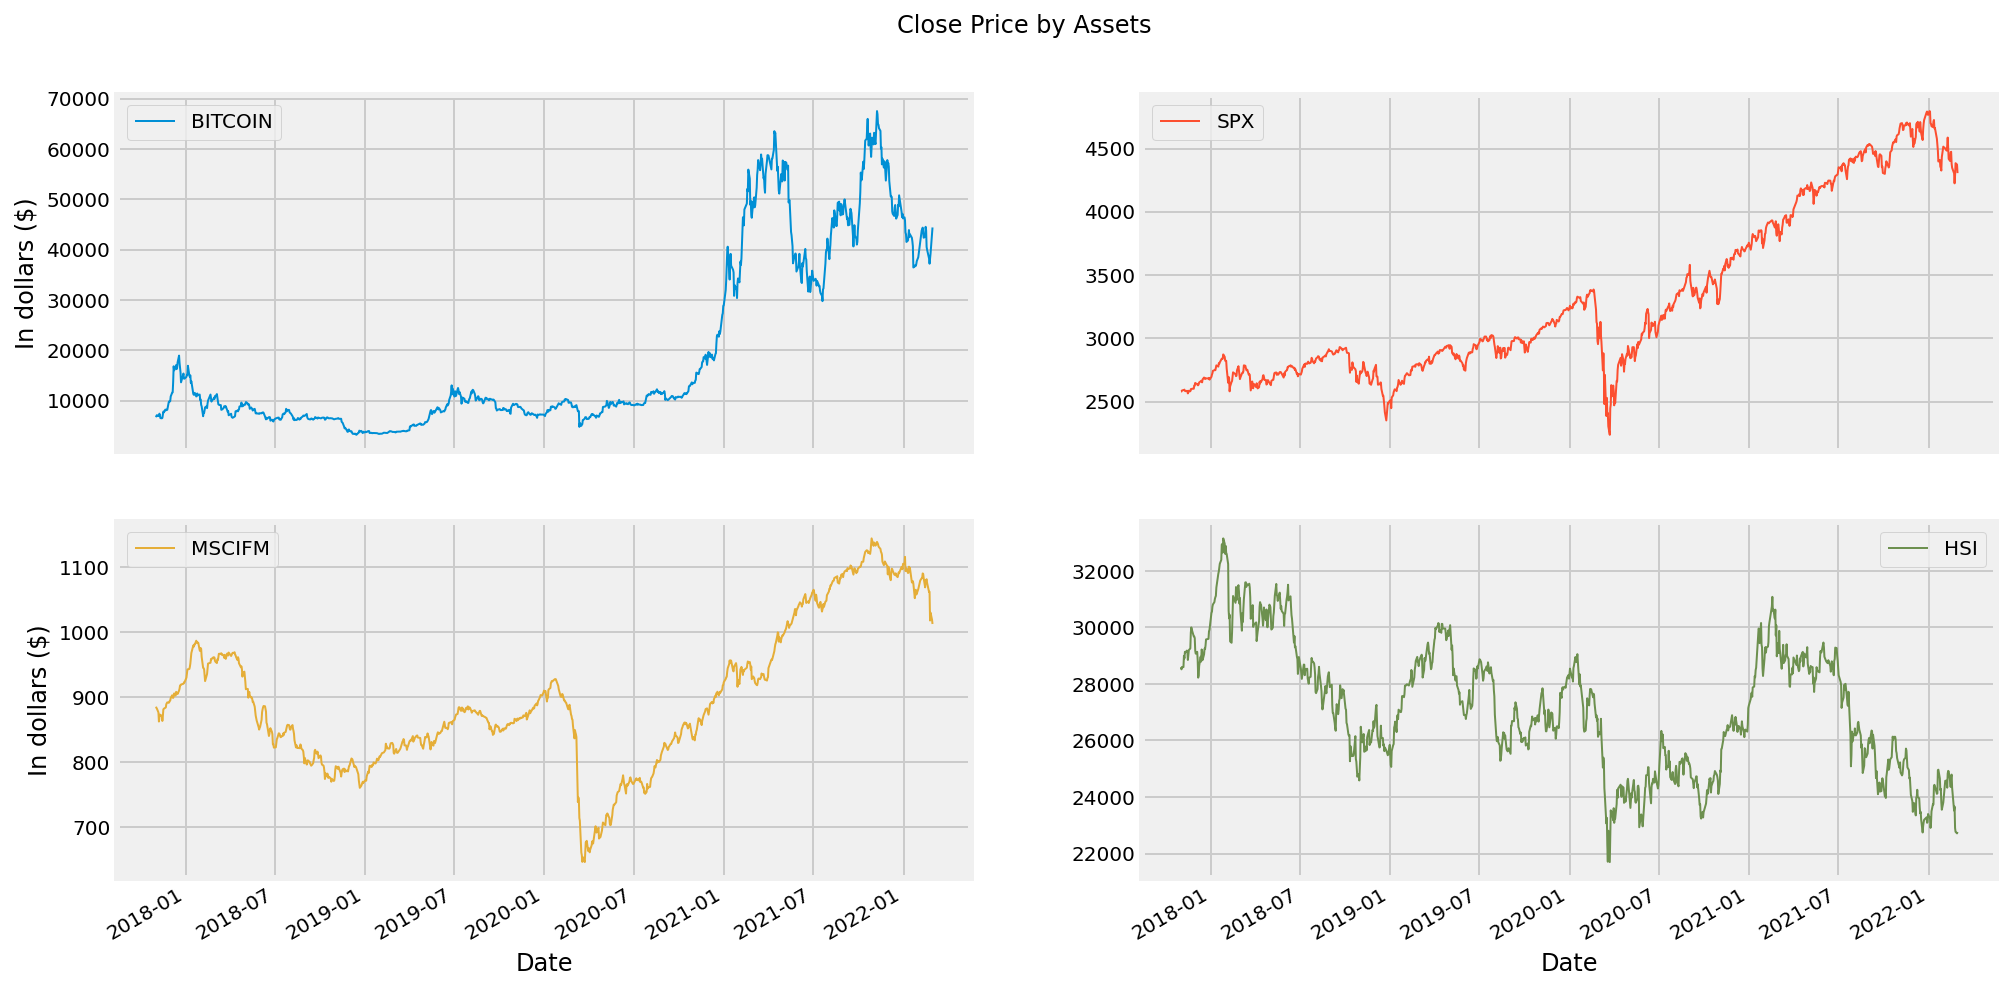

In [6]:
plot_prices(assets_df)
plt.savefig('./figures/1. Financial Time series.png')

### Method 1 (Ex-Post Orientation)
**This Method has an *Ex-Post Orientation*. Basically R/S method was devised to estimate the Hurst Value over an Interval. Thus in this method, we will attempt to estimate Hurst Value over an interval by looking back at the series.** 

Based on the length of the series. We will first divide the series in intervals of equal length. Then we will determine the **HURST VALUE** over that entire Interval. Based on Hurst Value, we will employ Moving Average cross over strategy to generate a LONG/SHORT signal depending on whether the entire interval is Trending or Mean reverting. 

#### EMA Crossover strategy over an interval based on Hurst Value:

In this strategy we first estimate the Hurst value over an interval by dividing the whole series into equal length – (3-4 months of Data points). We then compute short and long Exponential Moving Averages over that interval. Then based on Hurst value we will generate long or short signal depending on where the small and big Moving averages are: 


Case 1: If Hurst Value is greater than 0.5, then our series will be Trending. In that case if the shorter moving average crosses the longer moving average from below. We will take long position. Similarly, if the shorter moving average crosses the longer moving average from above. We will take a short position.


Case 2: If Hurst Value is less than 0.5, then our series will be Mean-Reverting. This essentially means that a value higher than the mean is like to reverse or revert towards its mean in the future. Hence, we will reverse our moving average signal in this case: for instance, if the shorter moving average crosses the longer moving average from below, we will take a short position and vice versa. 


We will test this strategy using “Bt” package in Python. We will compare the Total Return, CAGR (Compound Annual Growth Rate) and Sharpe ratio generated from this strategy with the passive “Buy and Hold” Strategy. We will assert that “EMA Crossover with Hurst” is a better strategy then passive “Buy and Hold” if we get better performance metrics.


### Implementing Strategies

In [7]:
H_spx = Hursts(spx,name = 'spx')
H_hsi = Hursts(hsi,name = 'hsi')
H_mscifm = Hursts(mscifm,name = 'fm')
H_btc = Hursts(bitco,name = 'btc')

#### Bitcoin

In [8]:
res_btc, visual_btc, name_btc = signal_int(bitco,H_btc, 10, 40,'bitcoin') #bitco,H_btc, 'bitcoin'

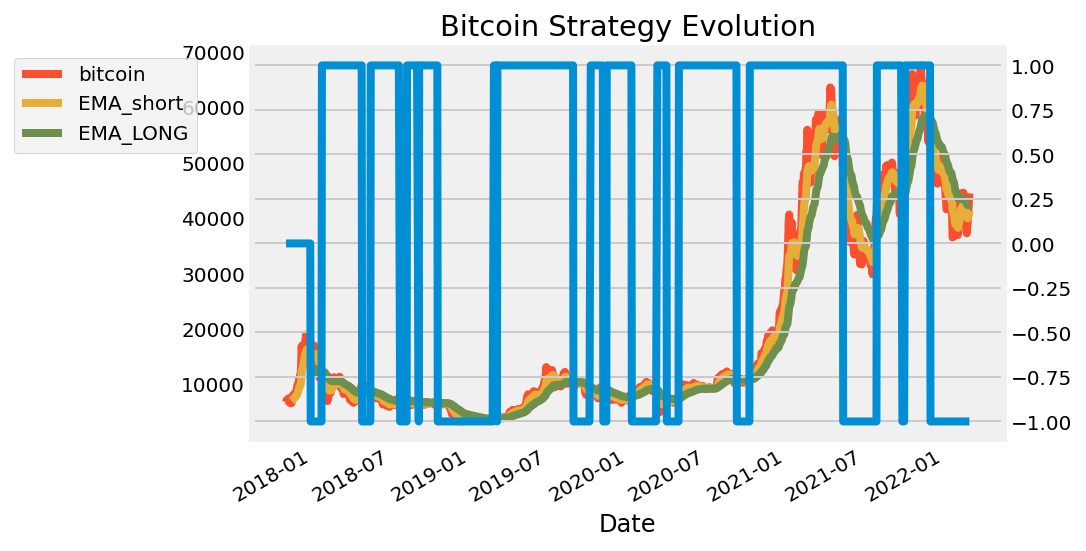

In [9]:
visual_btc.plot(secondary_y = name_btc, title = 'Bitcoin Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
# Use the following if the graph is no clear
plt.rcParams["figure.figsize"] = (12.5,12.5)
plt.savefig('./figures/2. Bitcoin Interval Based Strategy.png')

Stat                 EMA_crossover with Hurst for bitcoin
-------------------  --------------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         2715.73%
Daily Sharpe         1.43
Daily Sortino        2.40
CAGR                 116.11%
Max Drawdown         -44.50%
Calmar Ratio         2.61

MTD                  -2.86%
3m                   18.40%
6m                   0.36%
YTD                  -2.29%
1Y                   15.11%
3Y (ann.)            129.52%
5Y (ann.)            116.11%
10Y (ann.)           -
Since Incep. (ann.)  116.11%

Daily Sharpe         1.43
Daily Sortino        2.40
Daily Mean (ann.)    104.61%
Daily Vol (ann.)     73.25%
Daily Skew           -0.28
Daily Kurt           7.15
Best Day             22.23%
Worst Day            -39.16%

Monthly Sharpe       1.43
Monthly Sortino      4.11
Monthly Mean (ann.)  99.12%
Monthly Vol (ann.)   69.50%
Monthly Skew         0.59
Monthly Kurt       

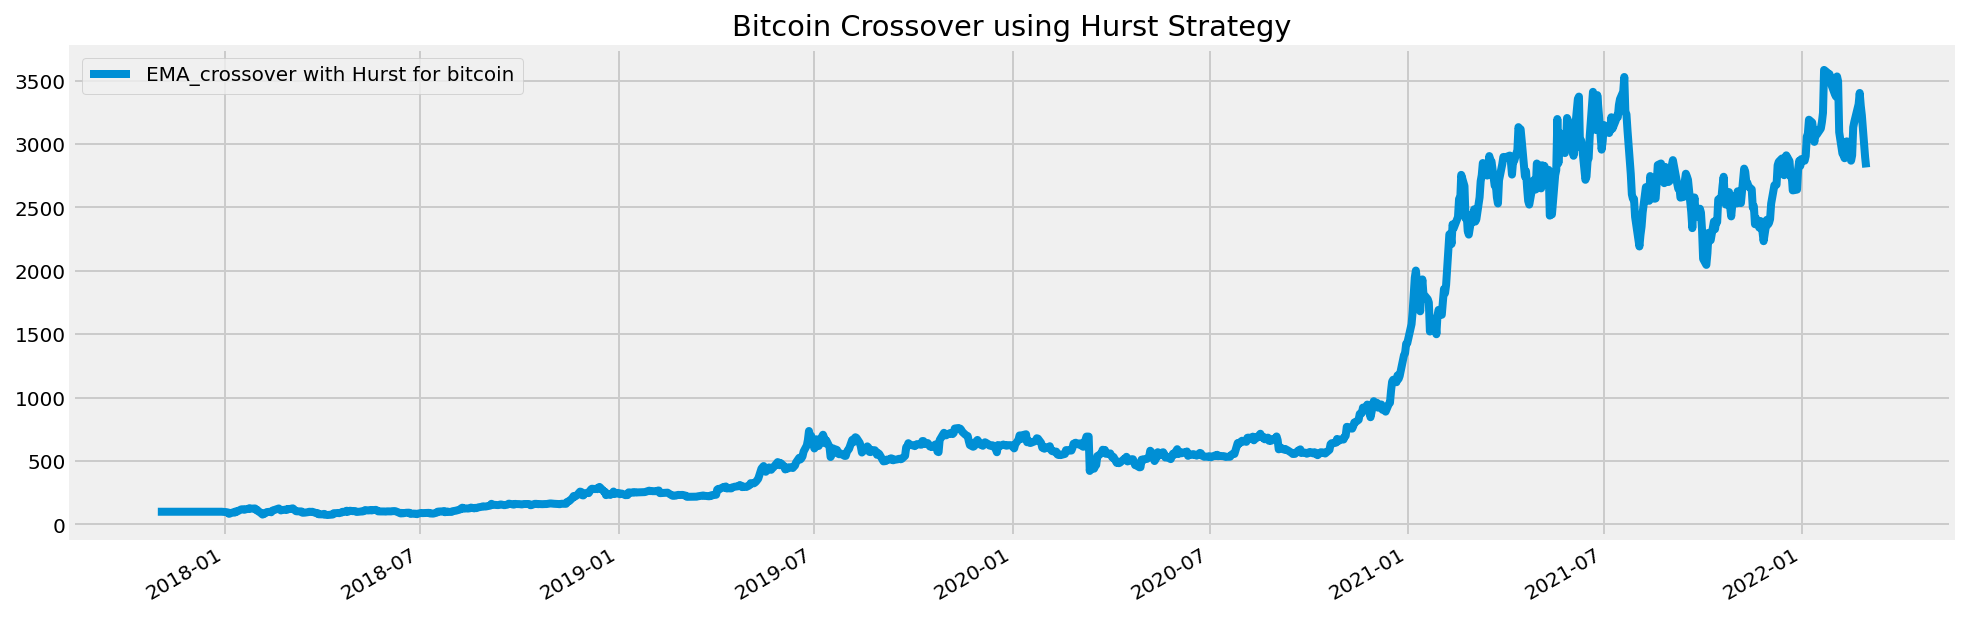

In [10]:
res_btc.plot(title = 'Bitcoin Crossover using Hurst Strategy')
res_btc.display()
plt.savefig('./figures/3. Bitcoin Crossover using Hurst Strategy.png')

#### S&P 500

In [11]:
res_spx, visual_spx, name_spx = signal_int(spx,H_spx, 10, 40,'spx')

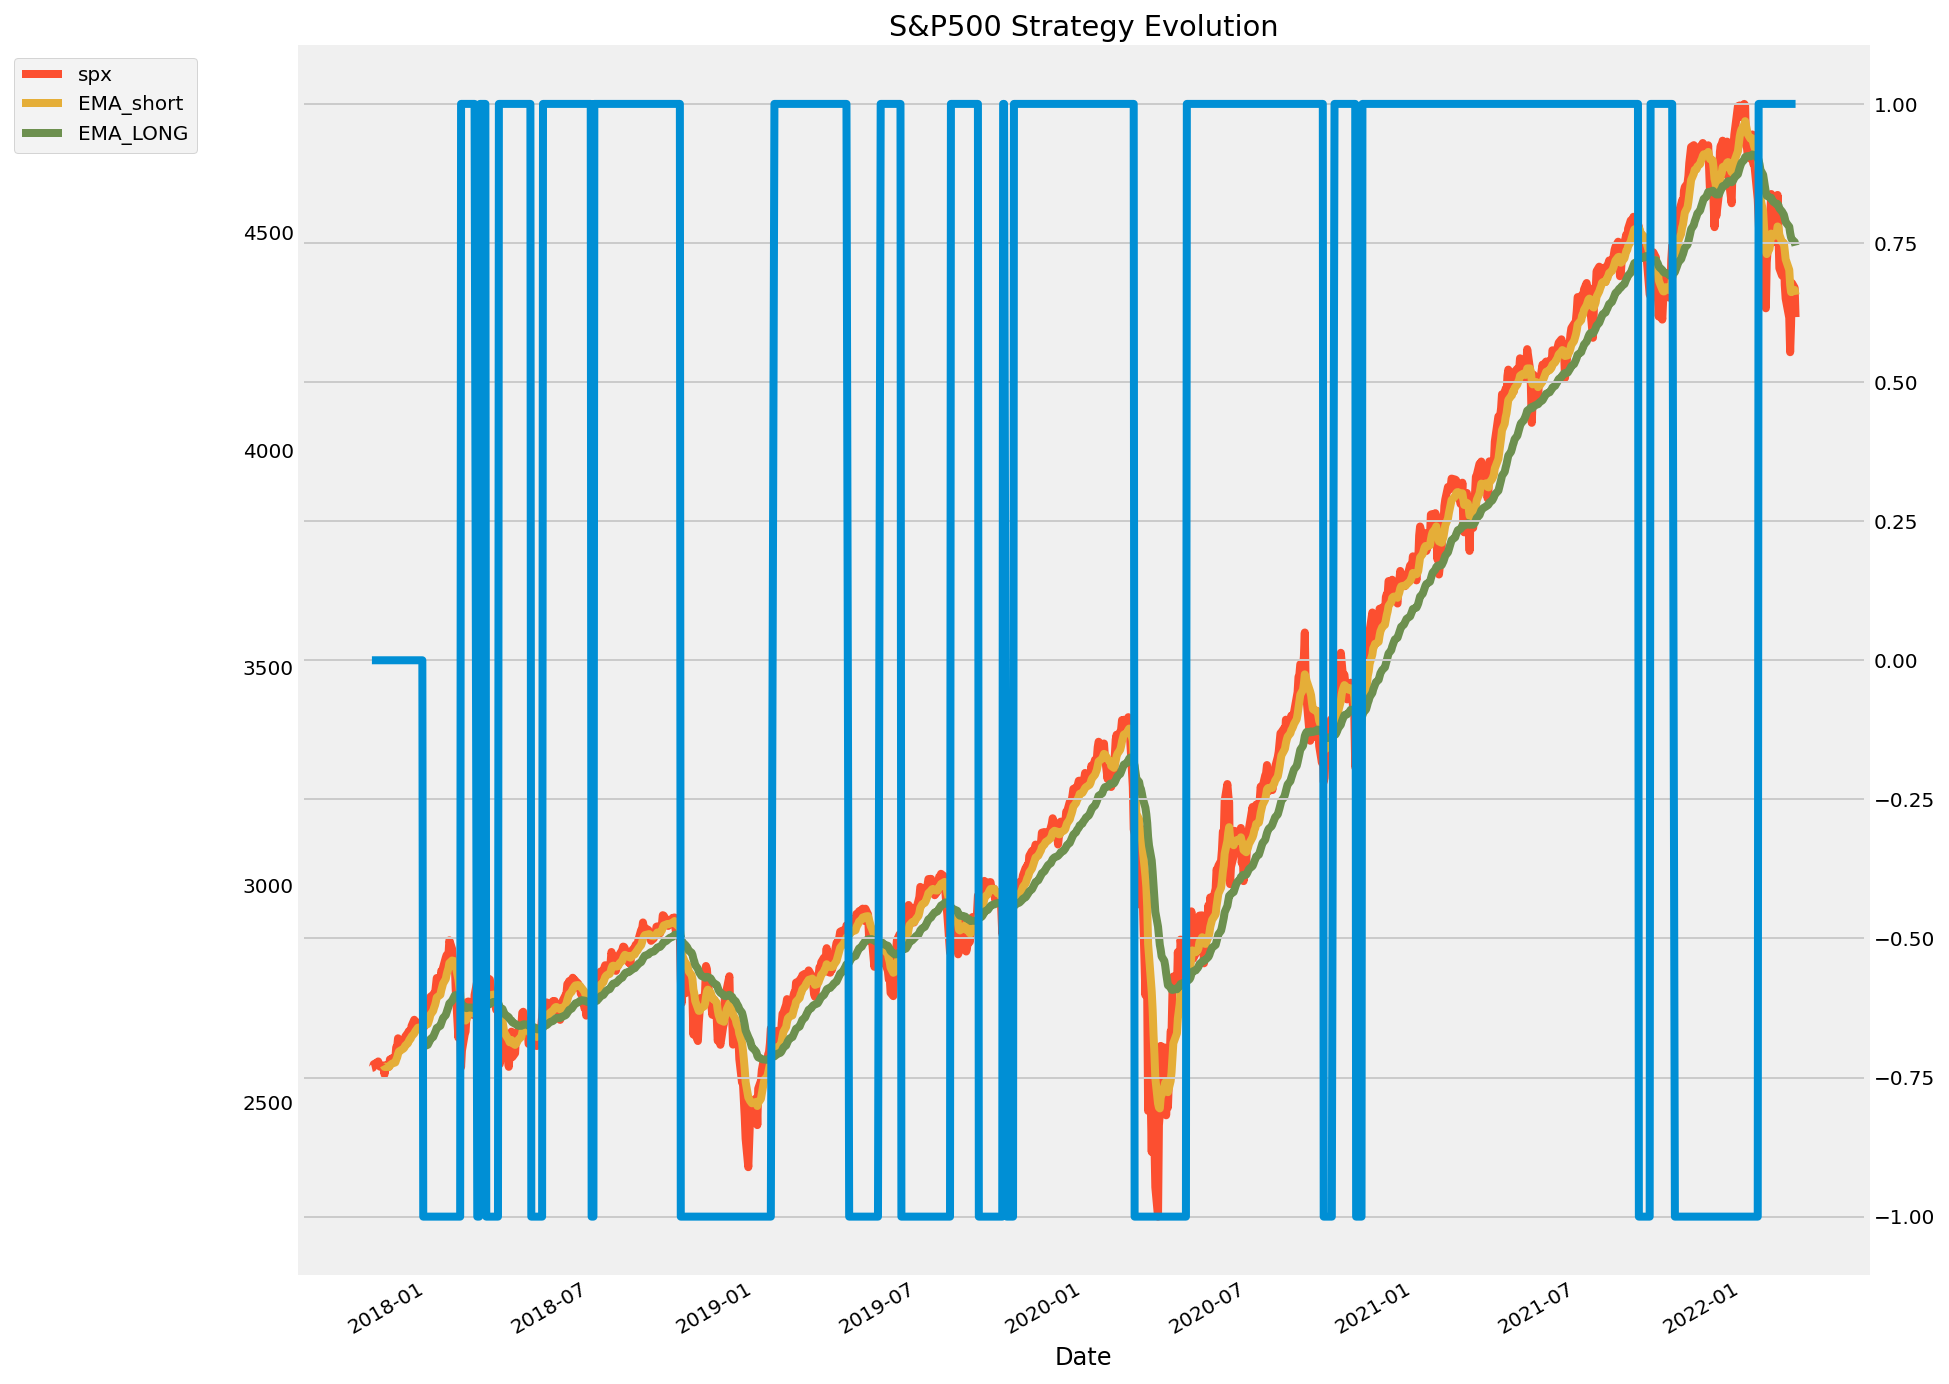

In [12]:
visual_spx.plot(secondary_y = name_spx, title = 'S&P500 Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
# Use the following if the graph is no clear
plt.rcParams["figure.figsize"] = (12.5,12.5)
plt.savefig('./figures/4. S&P500 Strategy Evolution.png')

Stat                 EMA_crossover with Hurst for spx
-------------------  ----------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         97.98%
Daily Sharpe         0.86
Daily Sortino        1.36
CAGR                 17.08%
Max Drawdown         -24.23%
Calmar Ratio         0.70

MTD                  -1.54%
3m                   -5.74%
6m                   -0.35%
YTD                  -0.21%
1Y                   15.54%
3Y (ann.)            14.17%
5Y (ann.)            17.08%
10Y (ann.)           -
Since Incep. (ann.)  17.08%

Daily Sharpe         0.86
Daily Sortino        1.36
Daily Mean (ann.)    17.97%
Daily Vol (ann.)     20.81%
Daily Skew           0.08
Daily Kurt           16.76
Best Day             11.99%
Worst Day            -9.39%

Monthly Sharpe       1.06
Monthly Sortino      2.23
Monthly Mean (ann.)  16.75%
Monthly Vol (ann.)   15.83%
Monthly Skew         0.85
Monthly Kurt         5.20
Best Mon

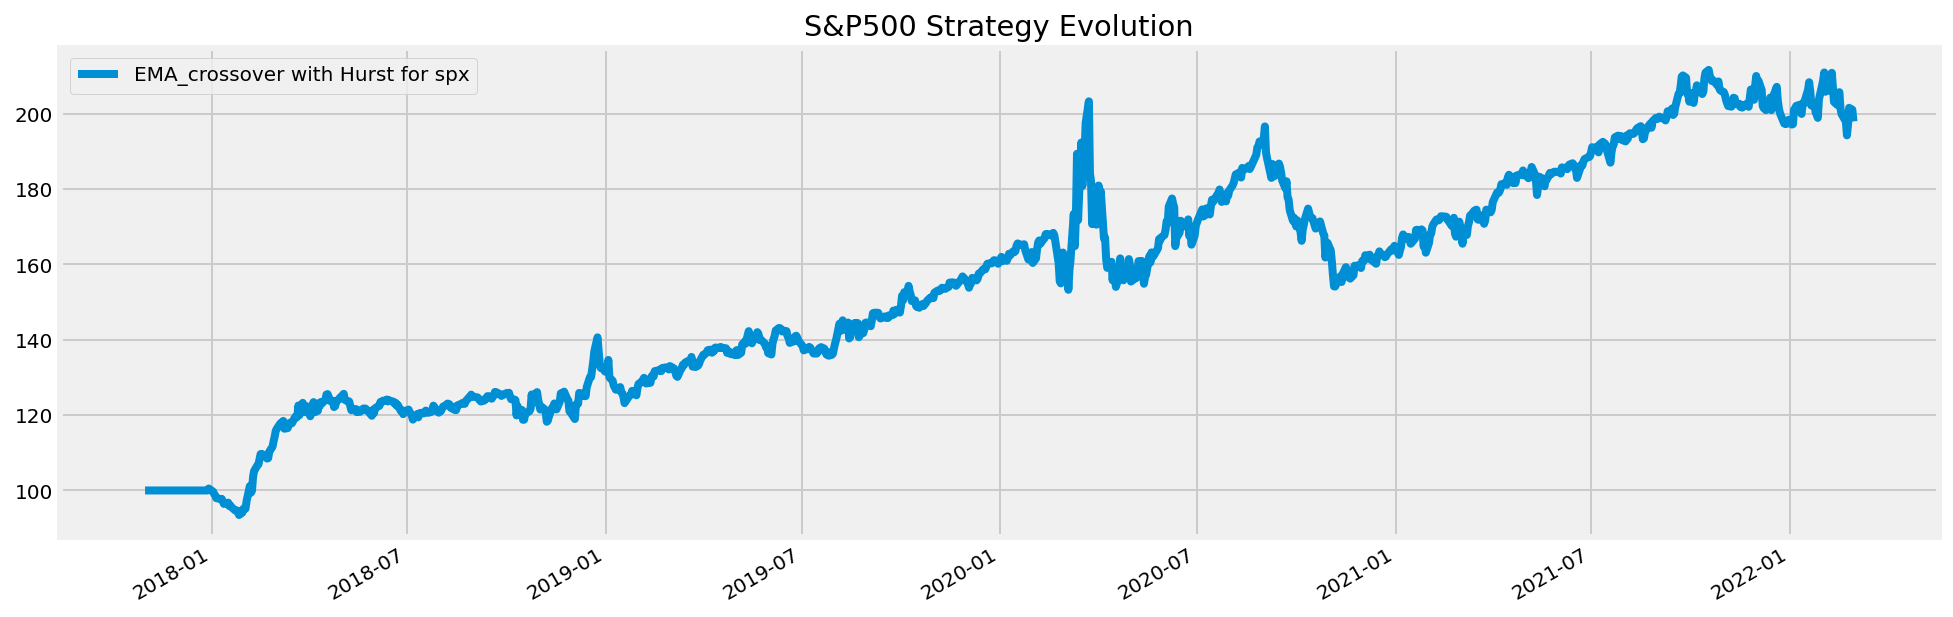

In [13]:
res_spx.display()
res_spx.plot(title = 'S&P500 Strategy Evolution')
plt.savefig('./figures/5. EMA_crossover with Hurst for spx.png')

#### HANG SENG 

In [14]:
res_hsi, visual_hsi, name_hsi = signal_int(hsi,H_hsi, 15, 45,'hsi')

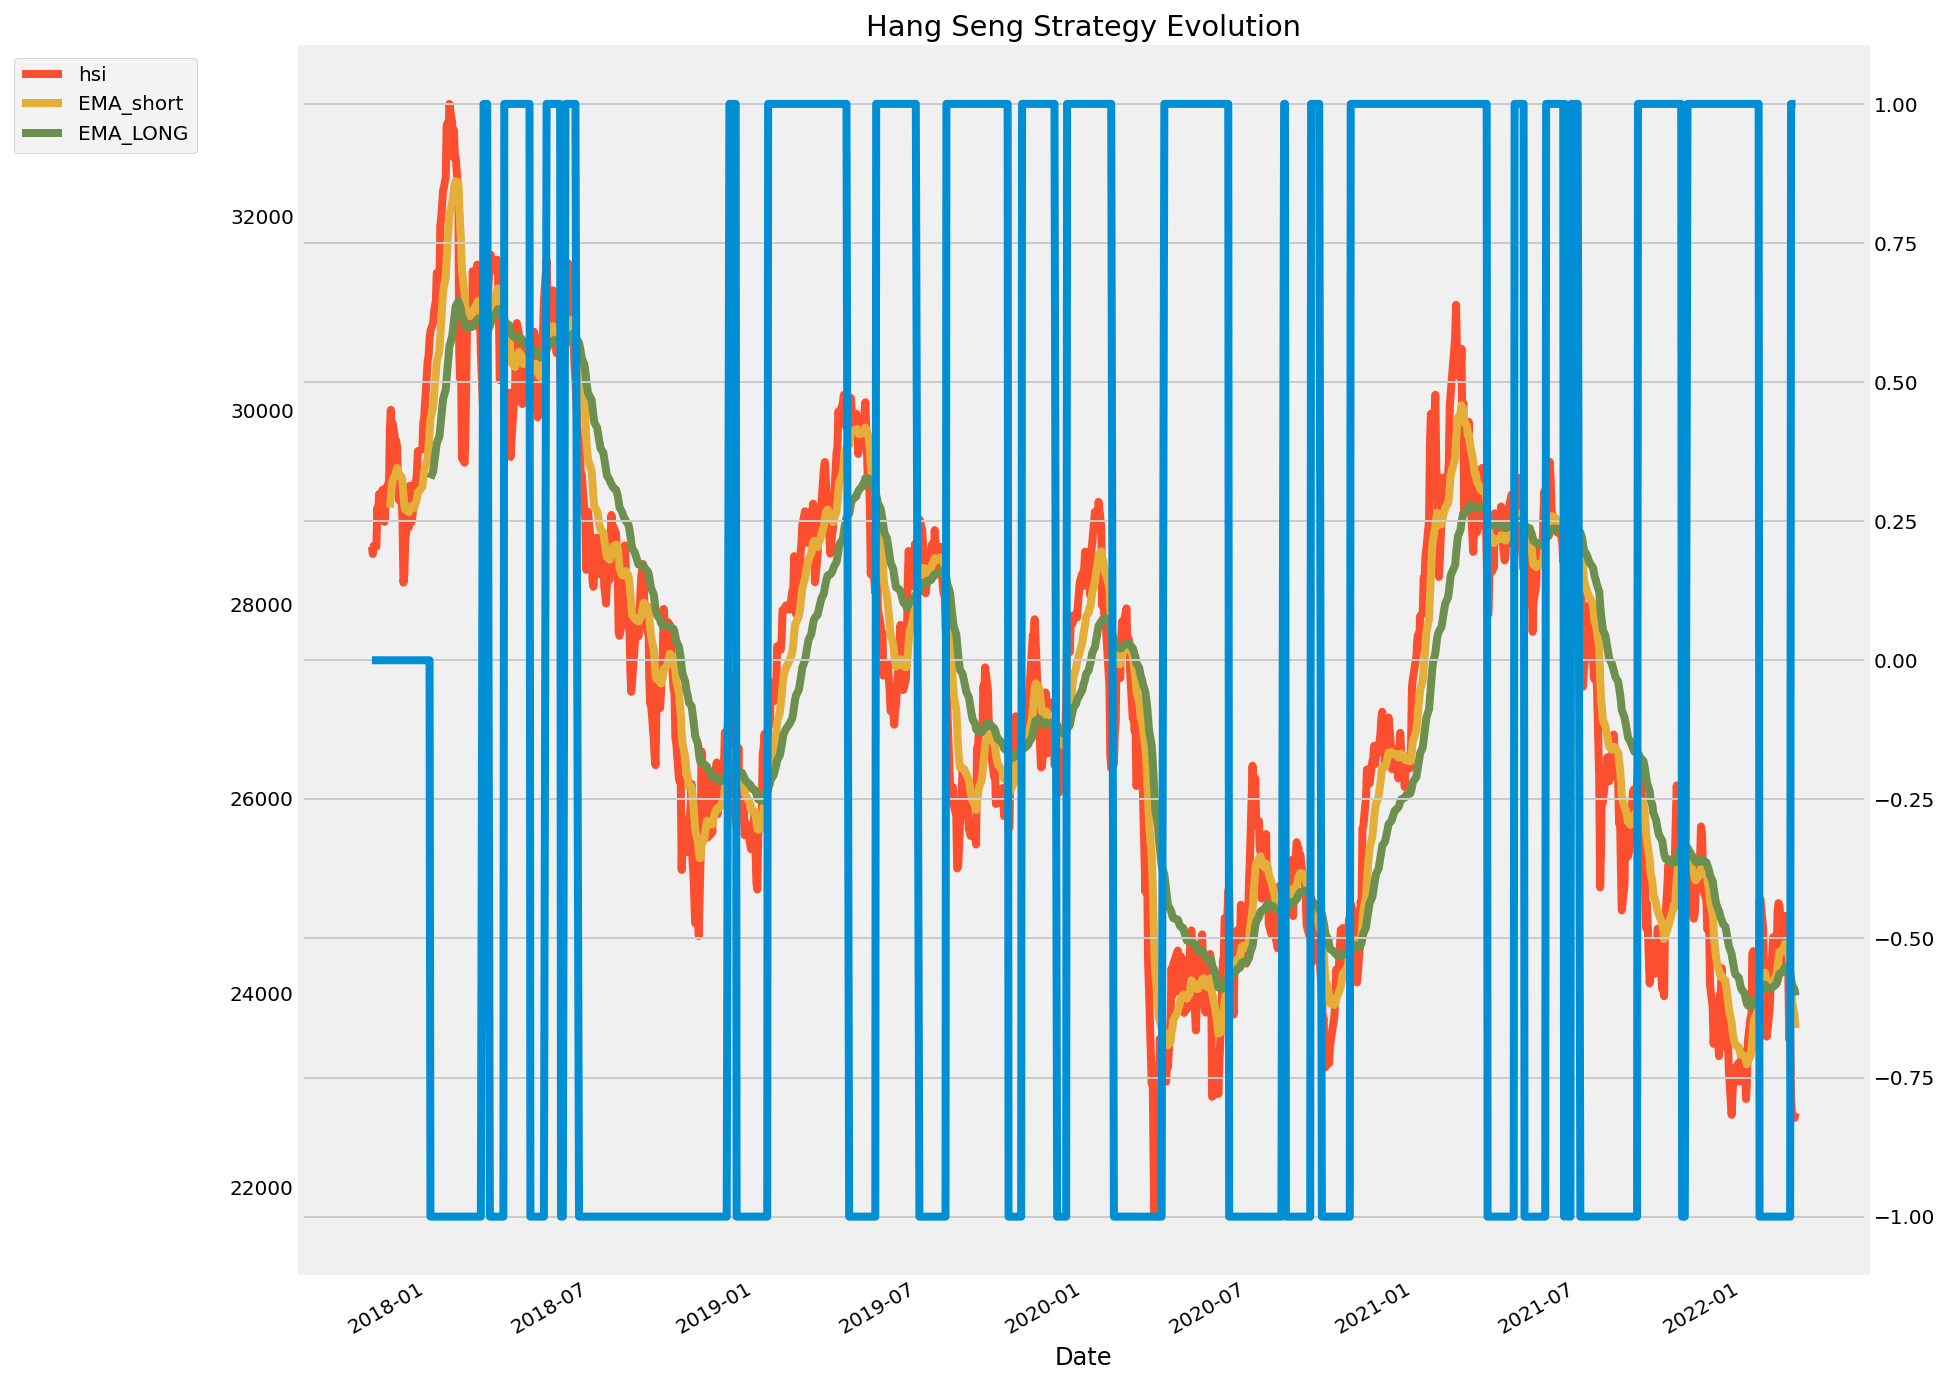

In [15]:
visual_hsi.plot(secondary_y = name_spx, title = 'Hang Seng Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
# Use the following if the graph is no clear
plt.rcParams["figure.figsize"] = (12.5,12.5)
plt.savefig('./figures/6. Hang Seng Strategy Evolutio.png')

Stat                 EMA_crossover with Hurst for hsi
-------------------  ----------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         20.67%
Daily Sharpe         0.32
Daily Sortino        0.54
CAGR                 4.43%
Max Drawdown         -28.38%
Calmar Ratio         0.16

MTD                  0.21%
3m                   13.56%
6m                   8.01%
YTD                  14.80%
1Y                   -9.29%
3Y (ann.)            7.12%
5Y (ann.)            4.43%
10Y (ann.)           -
Since Incep. (ann.)  4.43%

Daily Sharpe         0.32
Daily Sortino        0.54
Daily Mean (ann.)    6.35%
Daily Vol (ann.)     19.61%
Daily Skew           0.02
Daily Kurt           1.82
Best Day             5.19%
Worst Day            -5.55%

Monthly Sharpe       0.31
Monthly Sortino      0.60
Monthly Mean (ann.)  6.33%
Monthly Vol (ann.)   20.73%
Monthly Skew         0.40
Monthly Kurt         -0.36
Best Month       

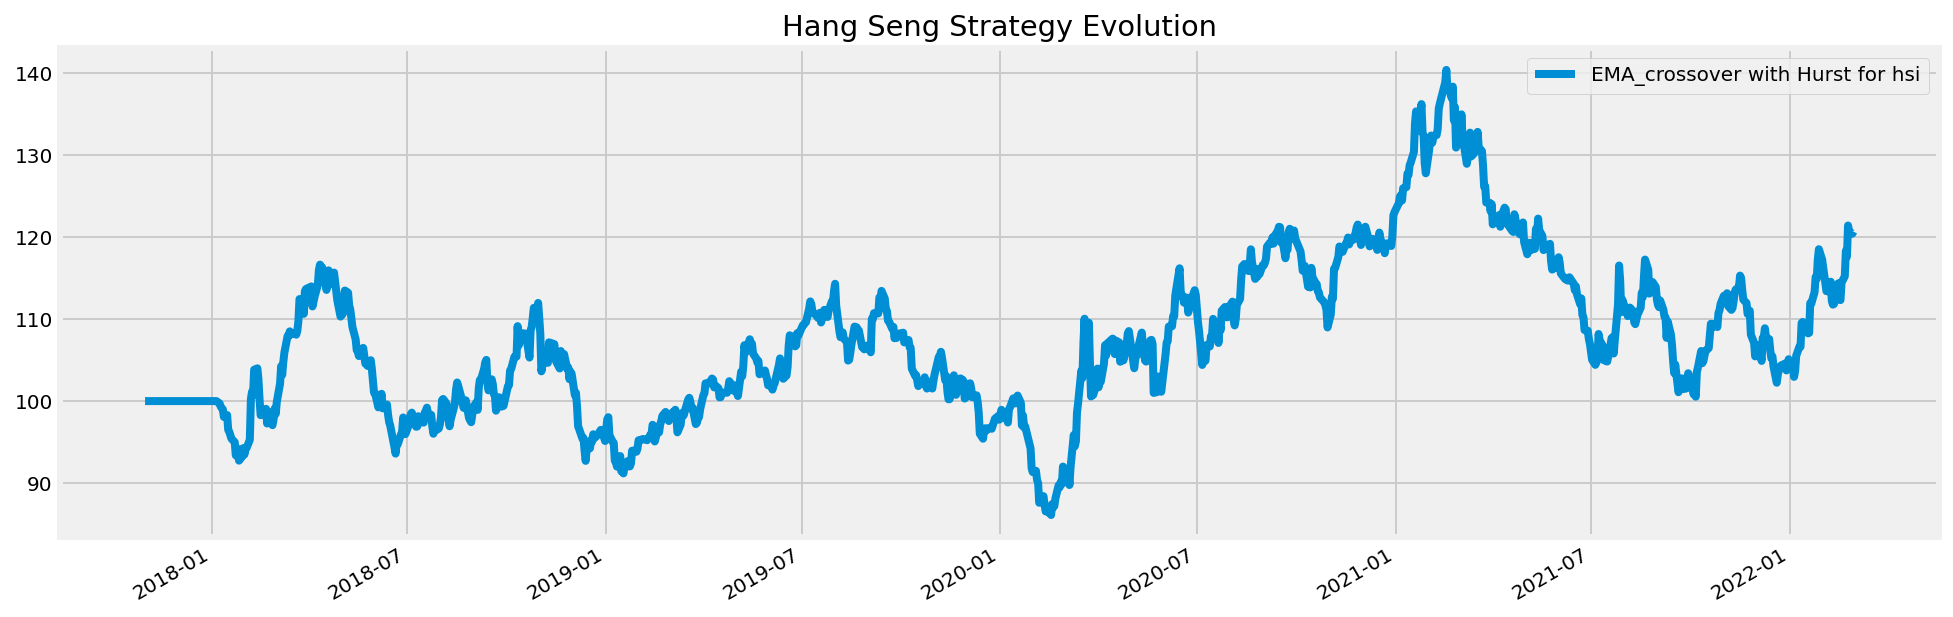

In [16]:
res_hsi.display()
res_hsi.plot(title = 'Hang Seng Strategy Evolution')
plt.savefig('./figures/7. EMA_crossover with Hurst for hsi.png')

#### MSCI FRONTIER MARKETS

In [17]:
# To ignore Runtime divide by Zero error --- it didn't Impact the code in any manner
#np.seterr(divide='ignore', invalid = 'ignore')
res_mscifm, visual_mscifm, name_mscifm = signal_int(mscifm,H_mscifm, 10, 40,'MSCI_FM')

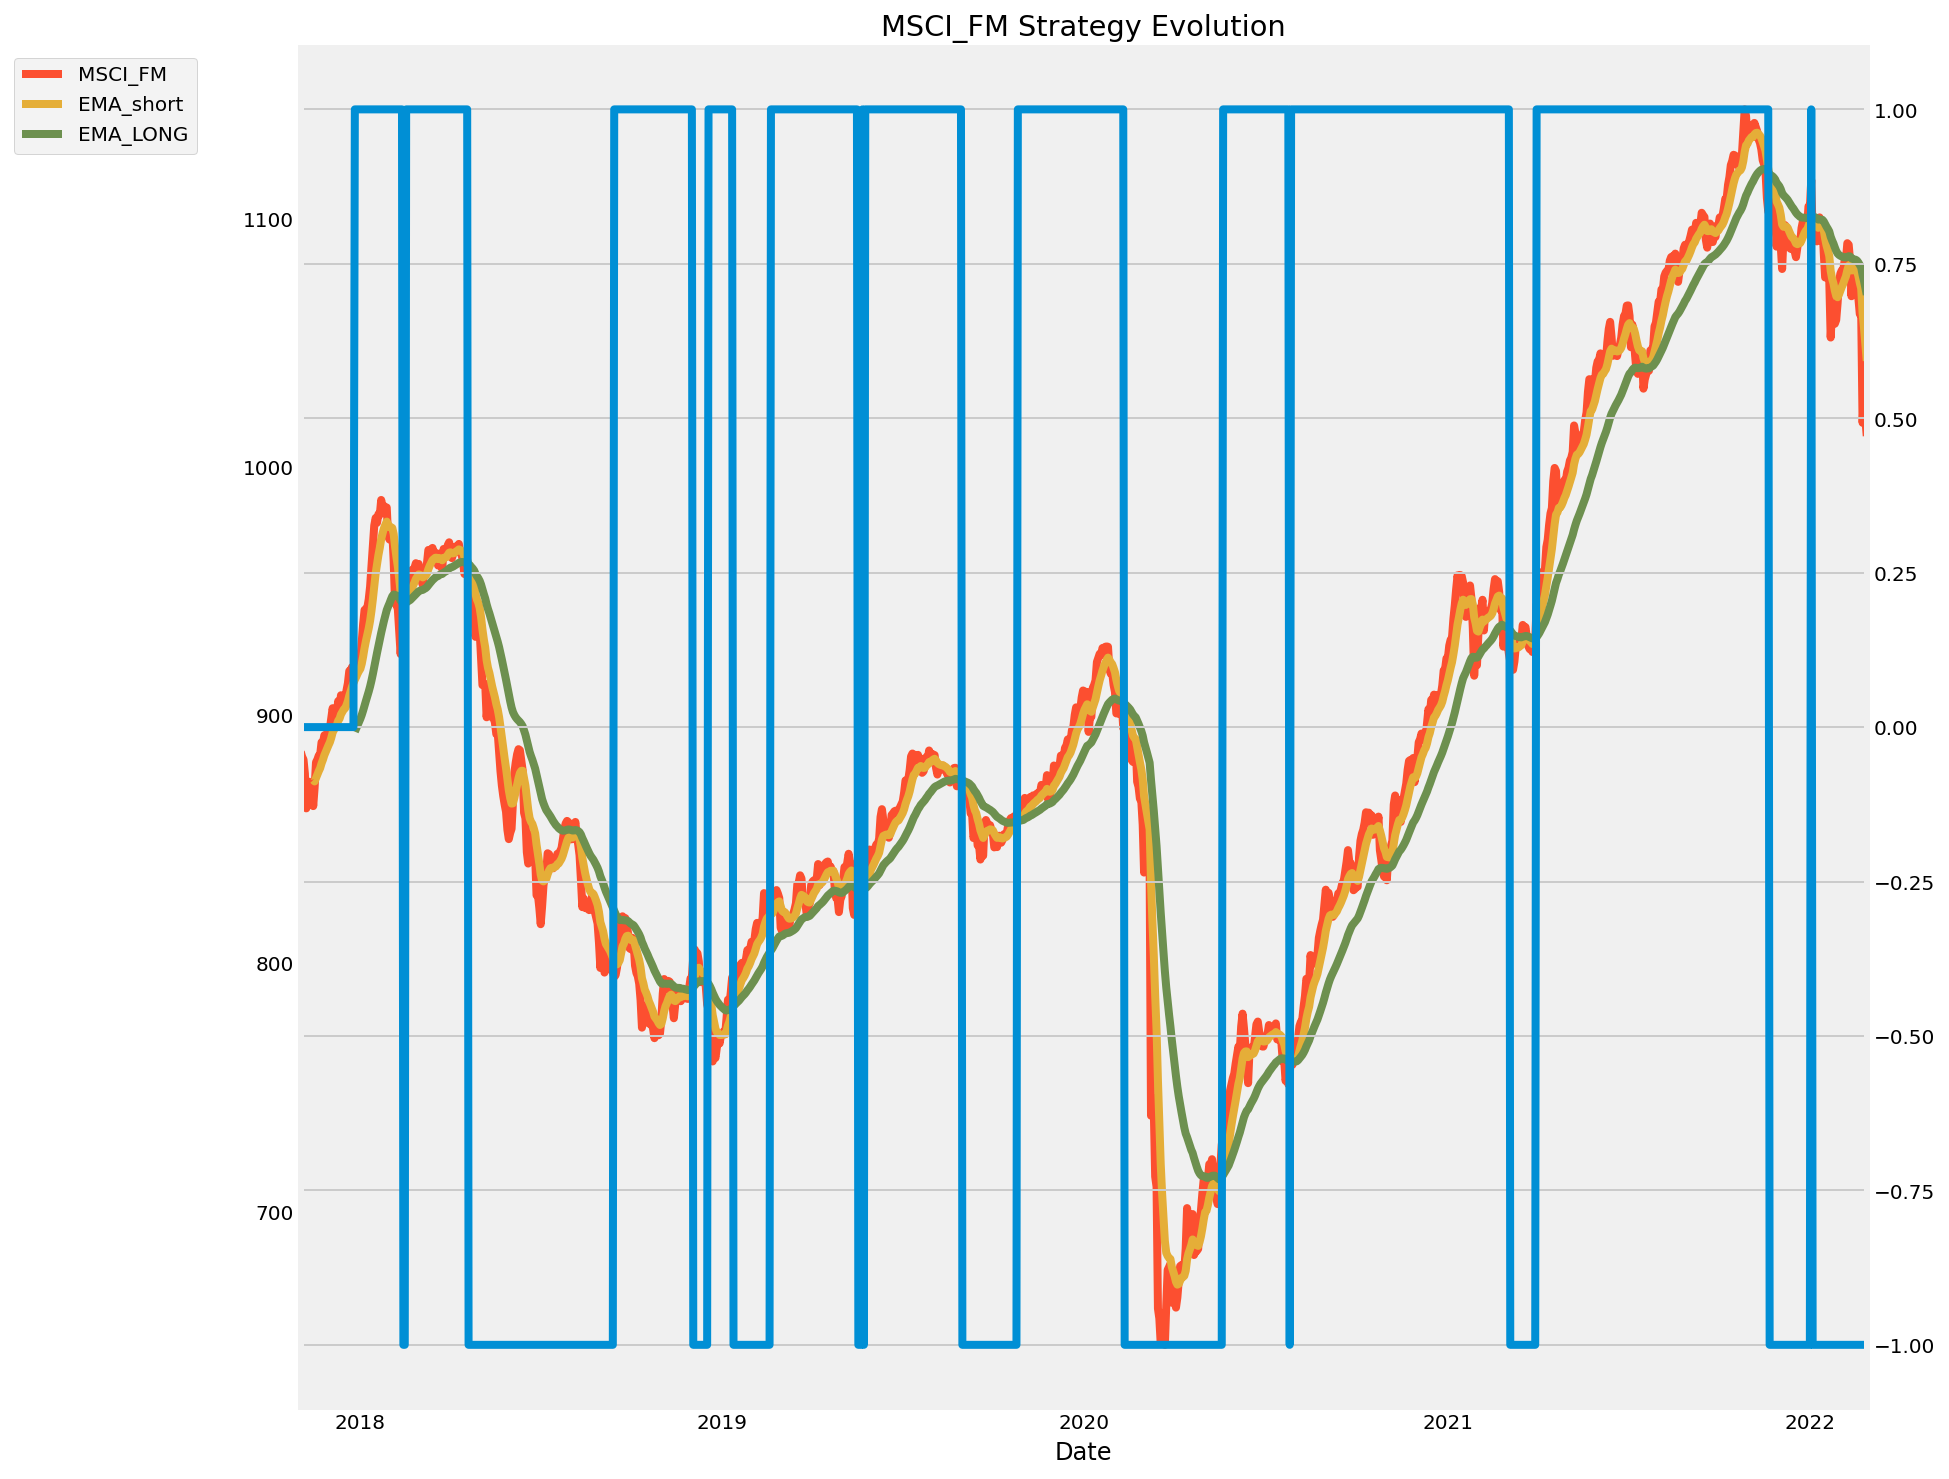

In [18]:
visual_mscifm.plot(secondary_y = name_mscifm, title = 'MSCI_FM Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
# Use the following if the graph is no clear
plt.rcParams["figure.figsize"] = (12.5,12.5)
plt.savefig('./figures/8. MSCI_FM Strategy Evolution.png')

Stat                 EMA_crossover with Hurst for MSCI_FM
-------------------  --------------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         130.27%
Daily Sharpe         1.68
Daily Sortino        3.43
CAGR                 21.24%
Max Drawdown         -12.06%
Calmar Ratio         1.76

MTD                  0.66%
3m                   4.05%
6m                   5.92%
YTD                  4.53%
1Y                   17.87%
3Y (ann.)            24.07%
5Y (ann.)            21.24%
10Y (ann.)           -
Since Incep. (ann.)  21.24%

Daily Sharpe         1.68
Daily Sortino        3.43
Daily Mean (ann.)    19.25%
Daily Vol (ann.)     11.43%
Daily Skew           4.74
Daily Kurt           72.96
Best Day             11.92%
Worst Day            -2.47%

Monthly Sharpe       1.29
Monthly Sortino      4.14
Monthly Mean (ann.)  20.13%
Monthly Vol (ann.)   15.60%
Monthly Skew         2.75
Monthly Kurt         13.72
Be

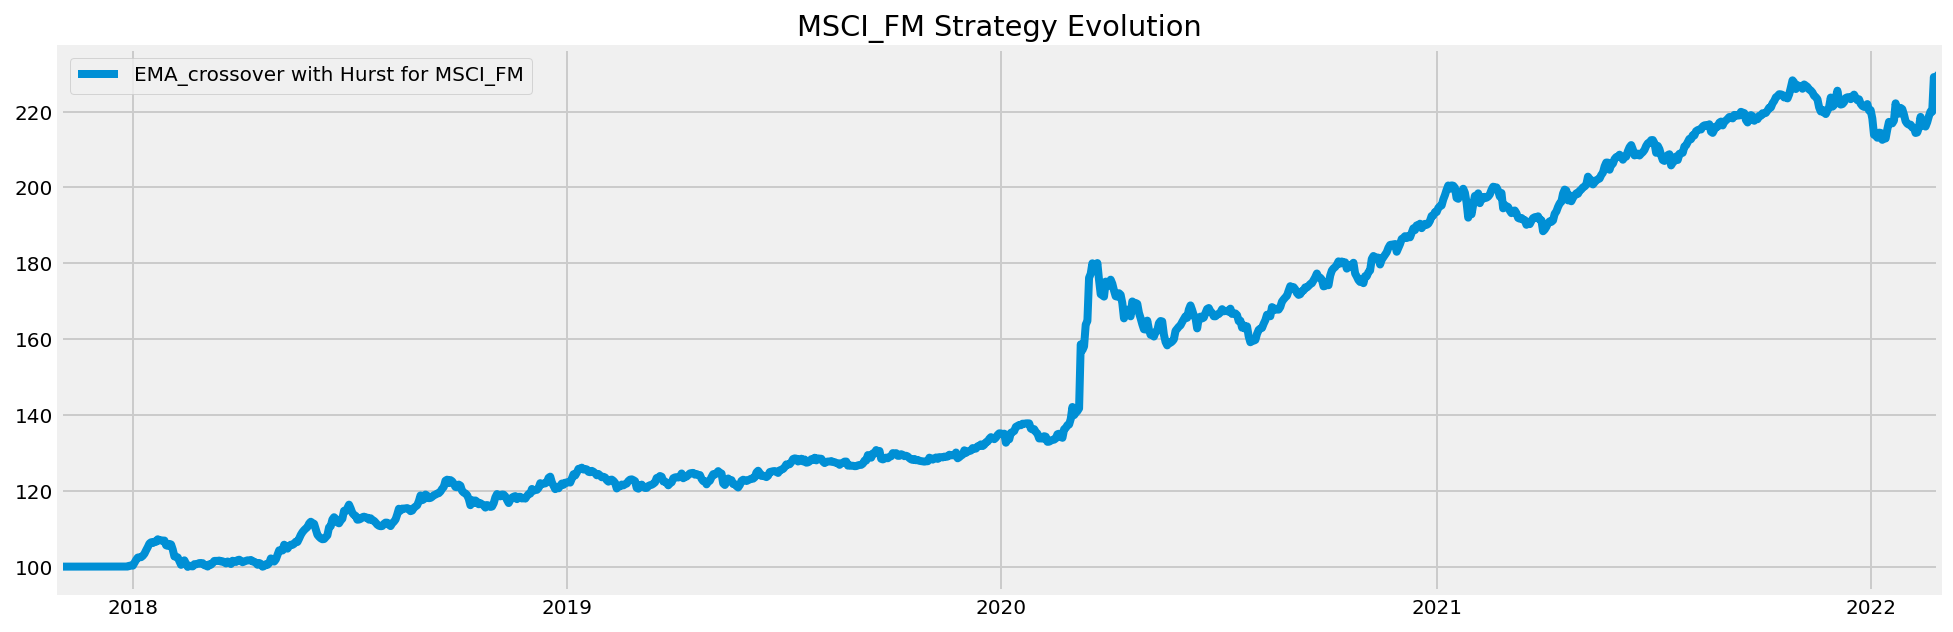

In [19]:
res_mscifm.display()
res_mscifm.plot(title = 'MSCI_FM Strategy Evolution')
plt.savefig('./figures/9. EMA_crossover with Hurst for MSCI_FM.png')

#### Benchmark Buy and Hold Strategy

Stat                 Benchmark Bitcoin
-------------------  -------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         557.70%
Daily Sharpe         0.96
Daily Sortino        1.60
CAGR                 54.48%
Max Drawdown         -82.80%
Calmar Ratio         0.66

MTD                  2.85%
3m                   -22.35%
6m                   -9.01%
YTD                  -3.89%
1Y                   -10.43%
3Y (ann.)            126.13%
5Y (ann.)            54.48%
10Y (ann.)           -
Since Incep. (ann.)  54.48%

Daily Sharpe         0.96
Daily Sortino        1.60
Daily Mean (ann.)    73.71%
Daily Vol (ann.)     76.99%
Daily Skew           -0.21
Daily Kurt           6.25
Best Day             22.52%
Worst Day            -39.09%

Monthly Sharpe       0.90
Monthly Sortino      2.16
Monthly Mean (ann.)  76.12%
Monthly Vol (ann.)   84.20%
Monthly Skew         0.30
Monthly Kurt         -0.73
Best Month           60.63%
Worst

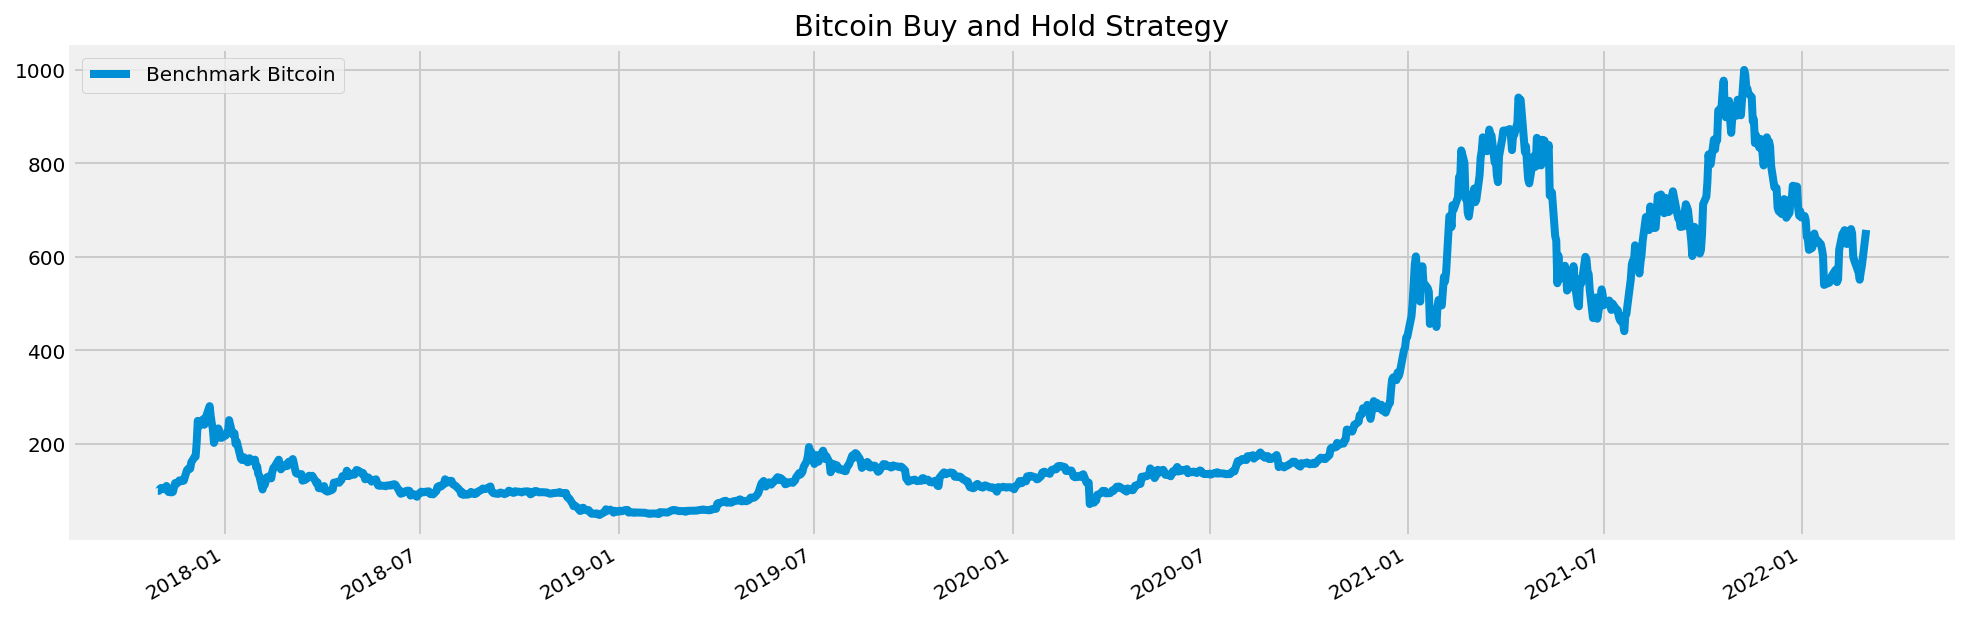

In [20]:
benchmark_btc = buy_and_hold(bitco, name='Benchmark Bitcoin')
# Run all backtests and plot the resutls
bt_res_passive_btc = bt.run(benchmark_btc)
bt_res_passive_btc.plot(title='Bitcoin Buy and Hold Strategy')
bt_res_passive_btc.display()
plt.savefig('./figures/10. Bitcoin Buy and Hold Strategy.png')

Stat                 Benchmark S&P500
-------------------  ------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         66.83%
Daily Sharpe         0.67
Daily Sortino        1.01
CAGR                 12.54%
Max Drawdown         -33.88%
Calmar Ratio         0.37

MTD                  -1.54%
3m                   -4.58%
6m                   -4.81%
YTD                  -9.64%
1Y                   10.35%
3Y (ann.)            15.35%
5Y (ann.)            12.54%
10Y (ann.)           -
Since Incep. (ann.)  12.54%

Daily Sharpe         0.67
Daily Sortino        1.01
Daily Mean (ann.)    14.03%
Daily Vol (ann.)     20.81%
Daily Skew           -0.66
Daily Kurt           16.69
Best Day             9.36%
Worst Day            -11.96%

Monthly Sharpe       0.78
Monthly Sortino      1.34
Monthly Mean (ann.)  13.03%
Monthly Vol (ann.)   16.76%
Monthly Skew         -0.45
Monthly Kurt         0.74
Best Month           12.66%
Worst Mont

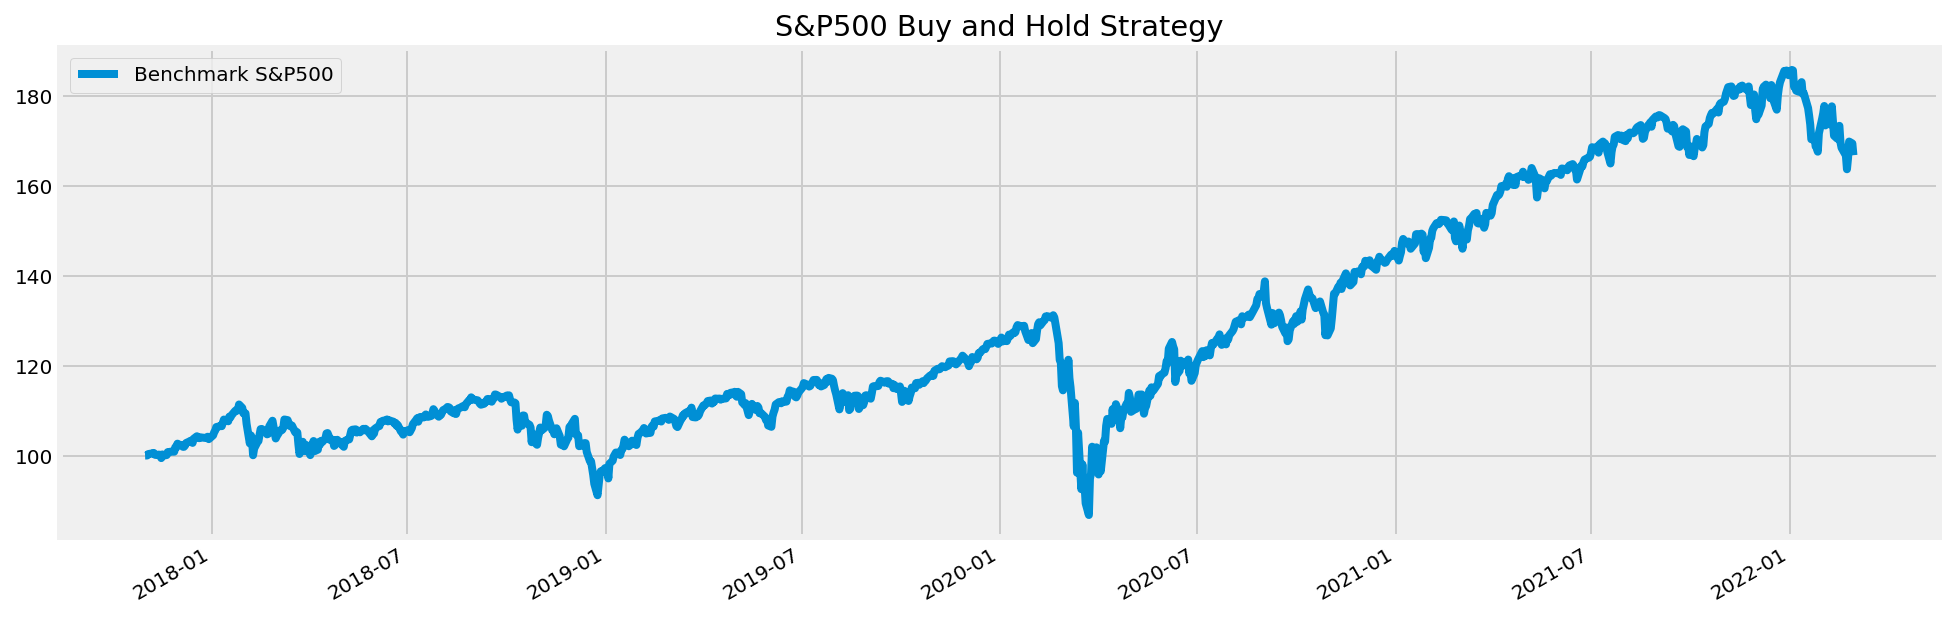

In [21]:
benchmark_spx = buy_and_hold(spx, name='Benchmark S&P500')
# Run all backtests and plot the resutls
bt_res_passive_spx = bt.run(benchmark_spx)
bt_res_passive_spx.plot(title='S&P500 Buy and Hold Strategy')
bt_res_passive_spx.display()
plt.savefig('./figures/11. S&P500 Buy and Hold Strategy.png')

Stat                 Benchmark Hang Seng
-------------------  ---------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         -19.83%
Daily Sharpe         -0.17
Daily Sortino        -0.28
CAGR                 -4.97%
Max Drawdown         -33.73%
Calmar Ratio         -0.15

MTD                  0.21%
3m                   -3.67%
6m                   -12.17%
YTD                  -2.63%
1Y                   -22.10%
3Y (ann.)            -7.33%
5Y (ann.)            -4.97%
10Y (ann.)           -
Since Incep. (ann.)  -4.97%

Daily Sharpe         -0.17
Daily Sortino        -0.28
Daily Mean (ann.)    -3.36%
Daily Vol (ann.)     19.21%
Daily Skew           -0.29
Daily Kurt           1.59
Best Day             4.87%
Worst Day            -5.38%

Monthly Sharpe       -0.21
Monthly Sortino      -0.33
Monthly Mean (ann.)  -3.58%
Monthly Vol (ann.)   16.90%
Monthly Skew         -0.20
Monthly Kurt         -0.48
Best Month           9.6

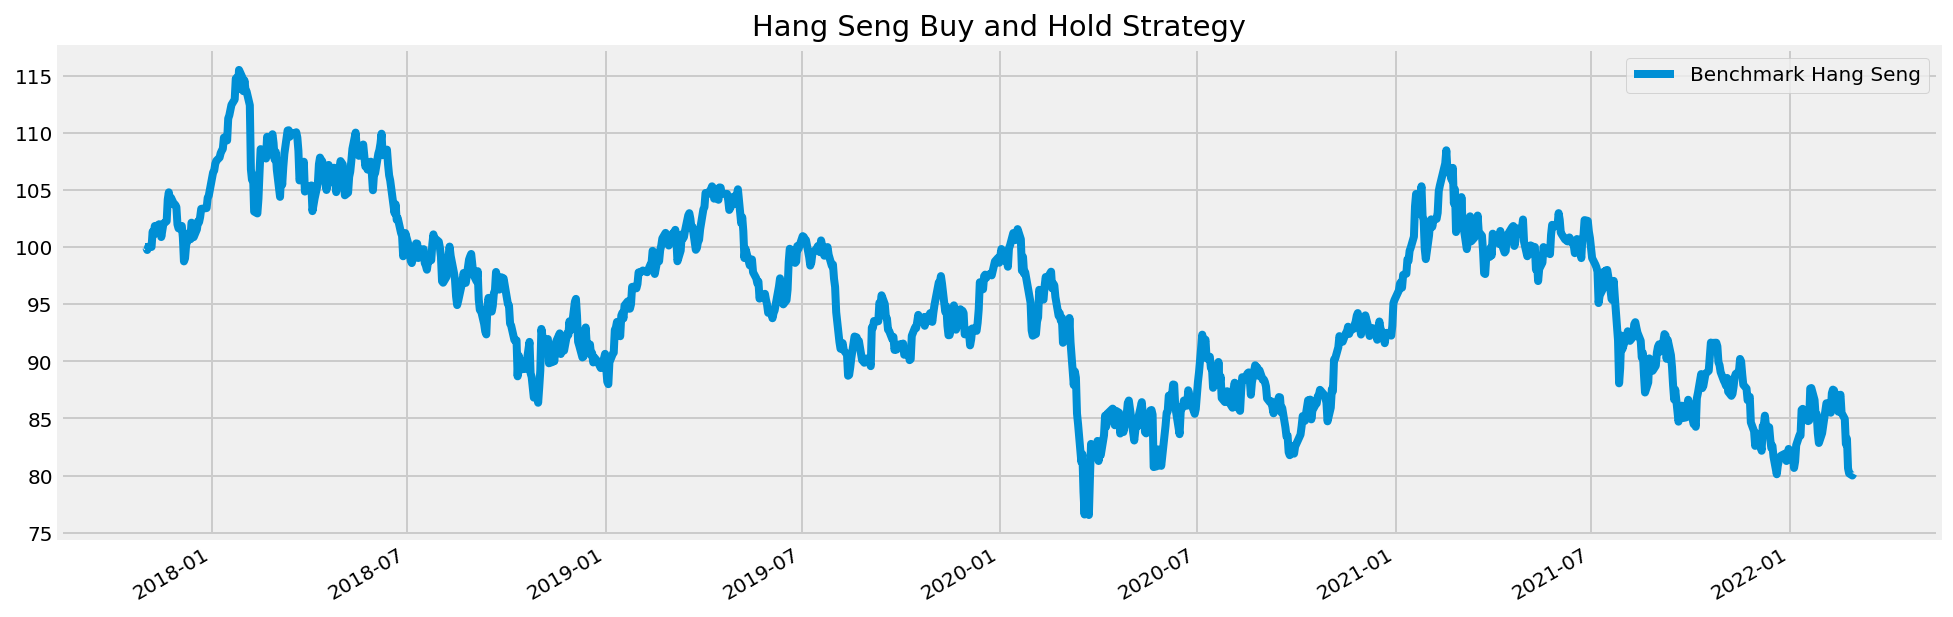

In [22]:
benchmark_hsi = buy_and_hold(hsi, name='Benchmark Hang Seng')
# Run all backtests and plot the resutls
bt_res_passive_hsi = bt.run(benchmark_hsi)
bt_res_passive_hsi.plot(title='Hang Seng Buy and Hold Strategy')
bt_res_passive_hsi.display()
plt.savefig('./figures/12. Hang Seng Buy and Hold Strateg.png')

Stat                 Benchmark MSCI_FM
-------------------  -------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         14.36%
Daily Sharpe         0.32
Daily Sortino        0.41
CAGR                 3.15%
Max Drawdown         -34.48%
Calmar Ratio         0.09

MTD                  -0.66%
3m                   -8.00%
6m                   -7.08%
YTD                  -8.37%
1Y                   8.66%
3Y (ann.)            7.58%
5Y (ann.)            3.15%
10Y (ann.)           -
Since Incep. (ann.)  3.15%

Daily Sharpe         0.32
Daily Sortino        0.41
Daily Mean (ann.)    3.68%
Daily Vol (ann.)     11.58%
Daily Skew           -5.05
Daily Kurt           71.27
Best Day             2.46%
Worst Day            -11.91%

Monthly Sharpe       0.27
Monthly Sortino      0.37
Monthly Mean (ann.)  4.44%
Monthly Vol (ann.)   16.29%
Monthly Skew         -2.13
Monthly Kurt         8.85
Best Month           8.23%
Worst Month     

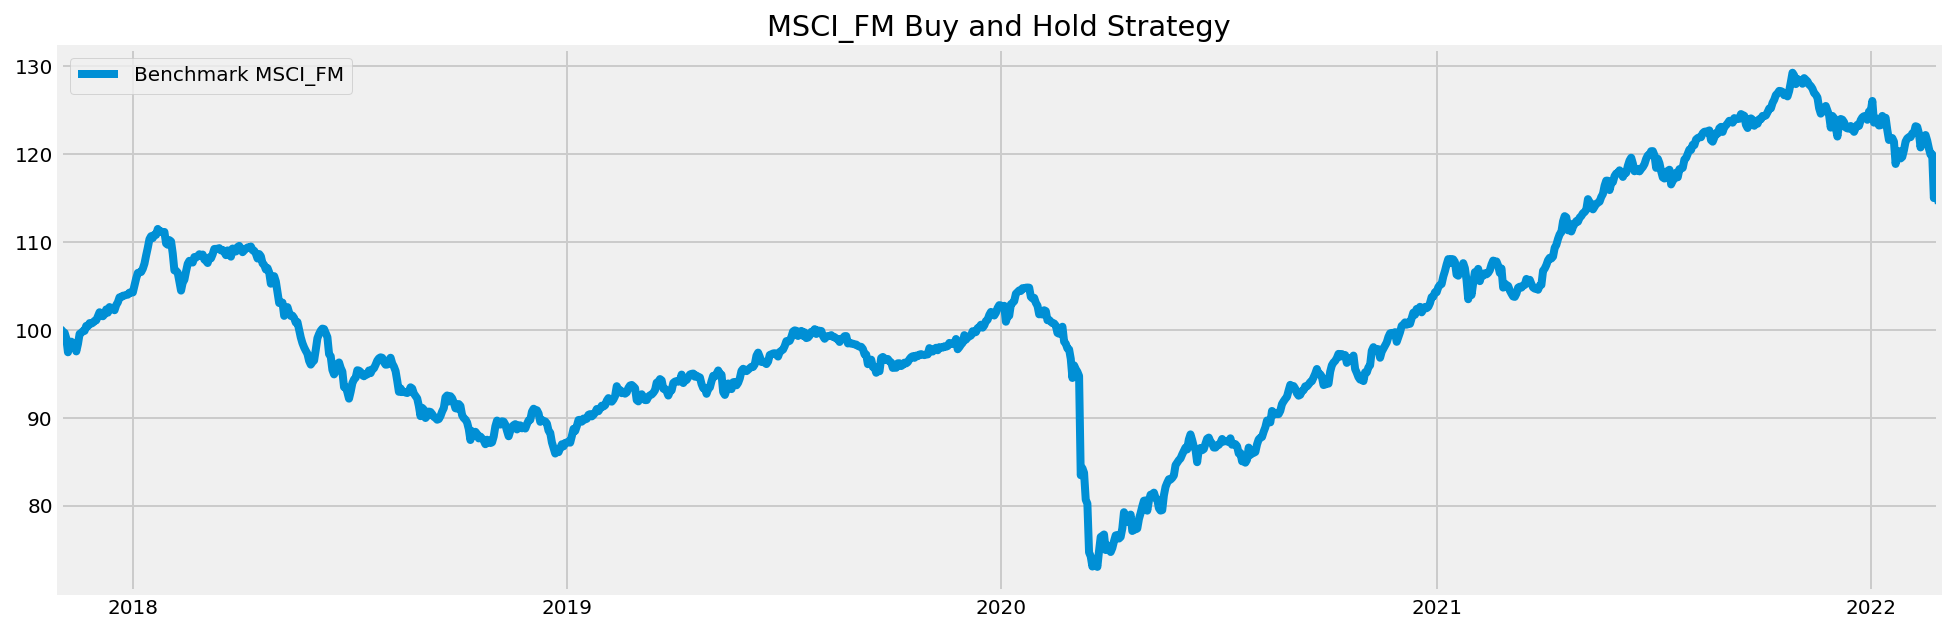

In [23]:
benchmark_mscifm = buy_and_hold(mscifm, name='Benchmark MSCI_FM')
# Run all backtests and plot the resutls
bt_res_passive_mscifm = bt.run(benchmark_mscifm)
bt_res_passive_mscifm.plot(title='MSCI_FM Buy and Hold Strategy')
bt_res_passive_mscifm.display()
plt.savefig('./figures/13. MSCI_FM Buy and Hold Strategy.png')

### METHOD 2: (EX-ANTE ORIENTATION)- "ROLLING HURST METHODOLOGY"

**Moving Hurst**


We initially estimated the rolling prices of the individual assets' closing prices over 128-day intervals. The hurst exponent function was then applied to each rolling window, and the resulting statistic was dubbed "rolling hurst" or "moving hurst."


To determine the trade signal, we used a Moving Average Convergence Divergence (MACD) Technical indicator on our moving hurst statistic. We substituted the price data with moving hurst data instead of utilizing asset prices to generate the MACD.

The difference between the 9-day exponentially weighted moving average and the 26-day exponentially weighted moving average is used to calculate the MACD. Similarly, the 9-day day exponentially weighted moving average was used to calculate the signal. 

We selected three positions: buy, hold, and sell. A buy is signified by a signal of 1, a sell by a signal of -1, and a hold by not taking any action.

A buy position was taken anytime the MACD at a certain point in time was greater than the signal, while a sell position was taken in the opposite case. We opted to hold in all other cases.

Finally, we utilised the "bt" back testing library to evaluate the performance of our model.


In [24]:
roll_days = 128
spx_roll_prices = spx.rolling(roll_days)
bitco_roll_prices= bitco.rolling(roll_days)
hsi_roll_prices = hsi.rolling(roll_days)
mscifm_roll_prices = mscifm.rolling(roll_days)

roll_hursts = list(map(lambda s: s.apply(lambda s: hurst_exponent(s, method='RS')).dropna(), [bitco_roll_prices, spx_roll_prices,
 mscifm_roll_prices, hsi_roll_prices
 ]))

bitco_rolling_hursts, spx_rolling_hursts, mscifm_rolling_hursts, hsi_rolling_hursts = roll_hursts



macd_array = list(map(lambda s: get_macd(s, 26,12,9), roll_hursts))    #[get_macd(s, 26,12,9) for _,s in rolling_hursts.iteritems()]
bitco_hurst_macd, spx_hurst_macd, mscifm_hurst_macd, hsi_hurst_macd = macd_array

In [25]:
rolling_prices = assets_df.rolling(roll_days)
rolling_hursts = rolling_prices.apply(lambda s: hurst_exponent(s, method='RS')).dropna()

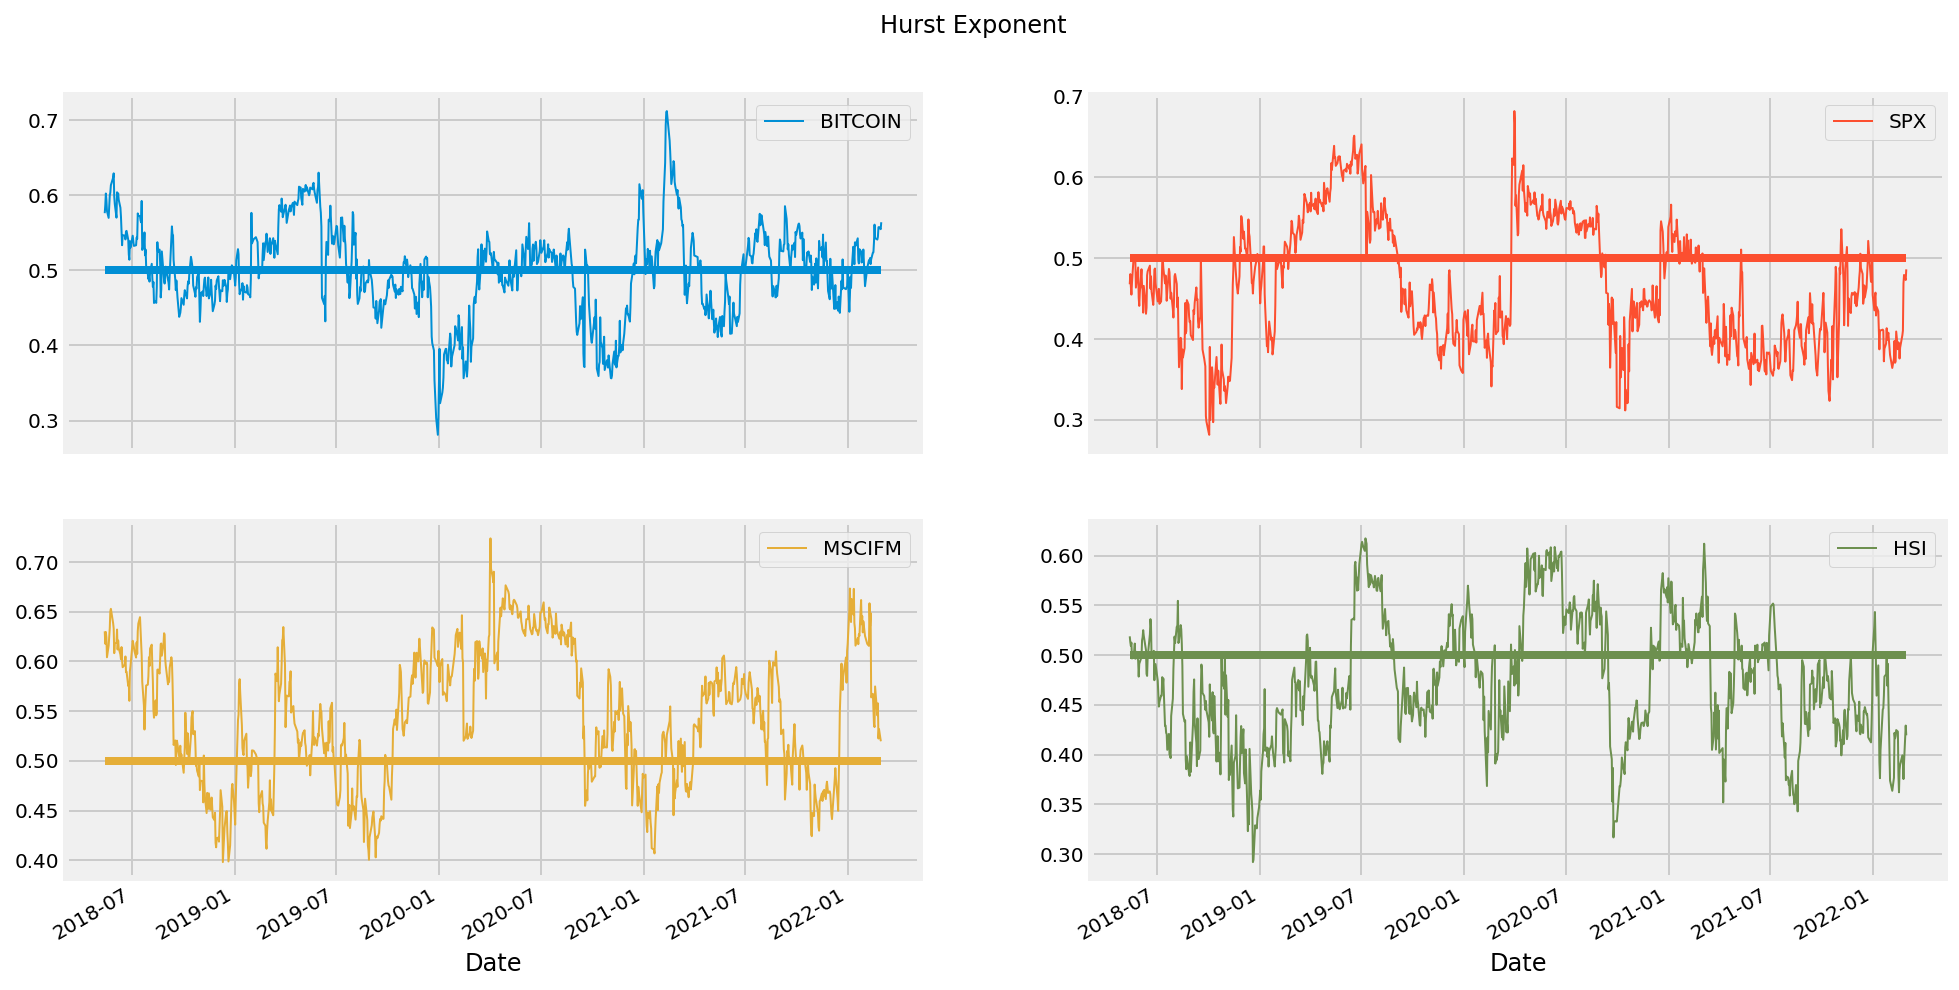

In [26]:
plot_rolling_hurst(rolling_hursts)

#### First we will plot our Financial Time Series alongwith MACD 

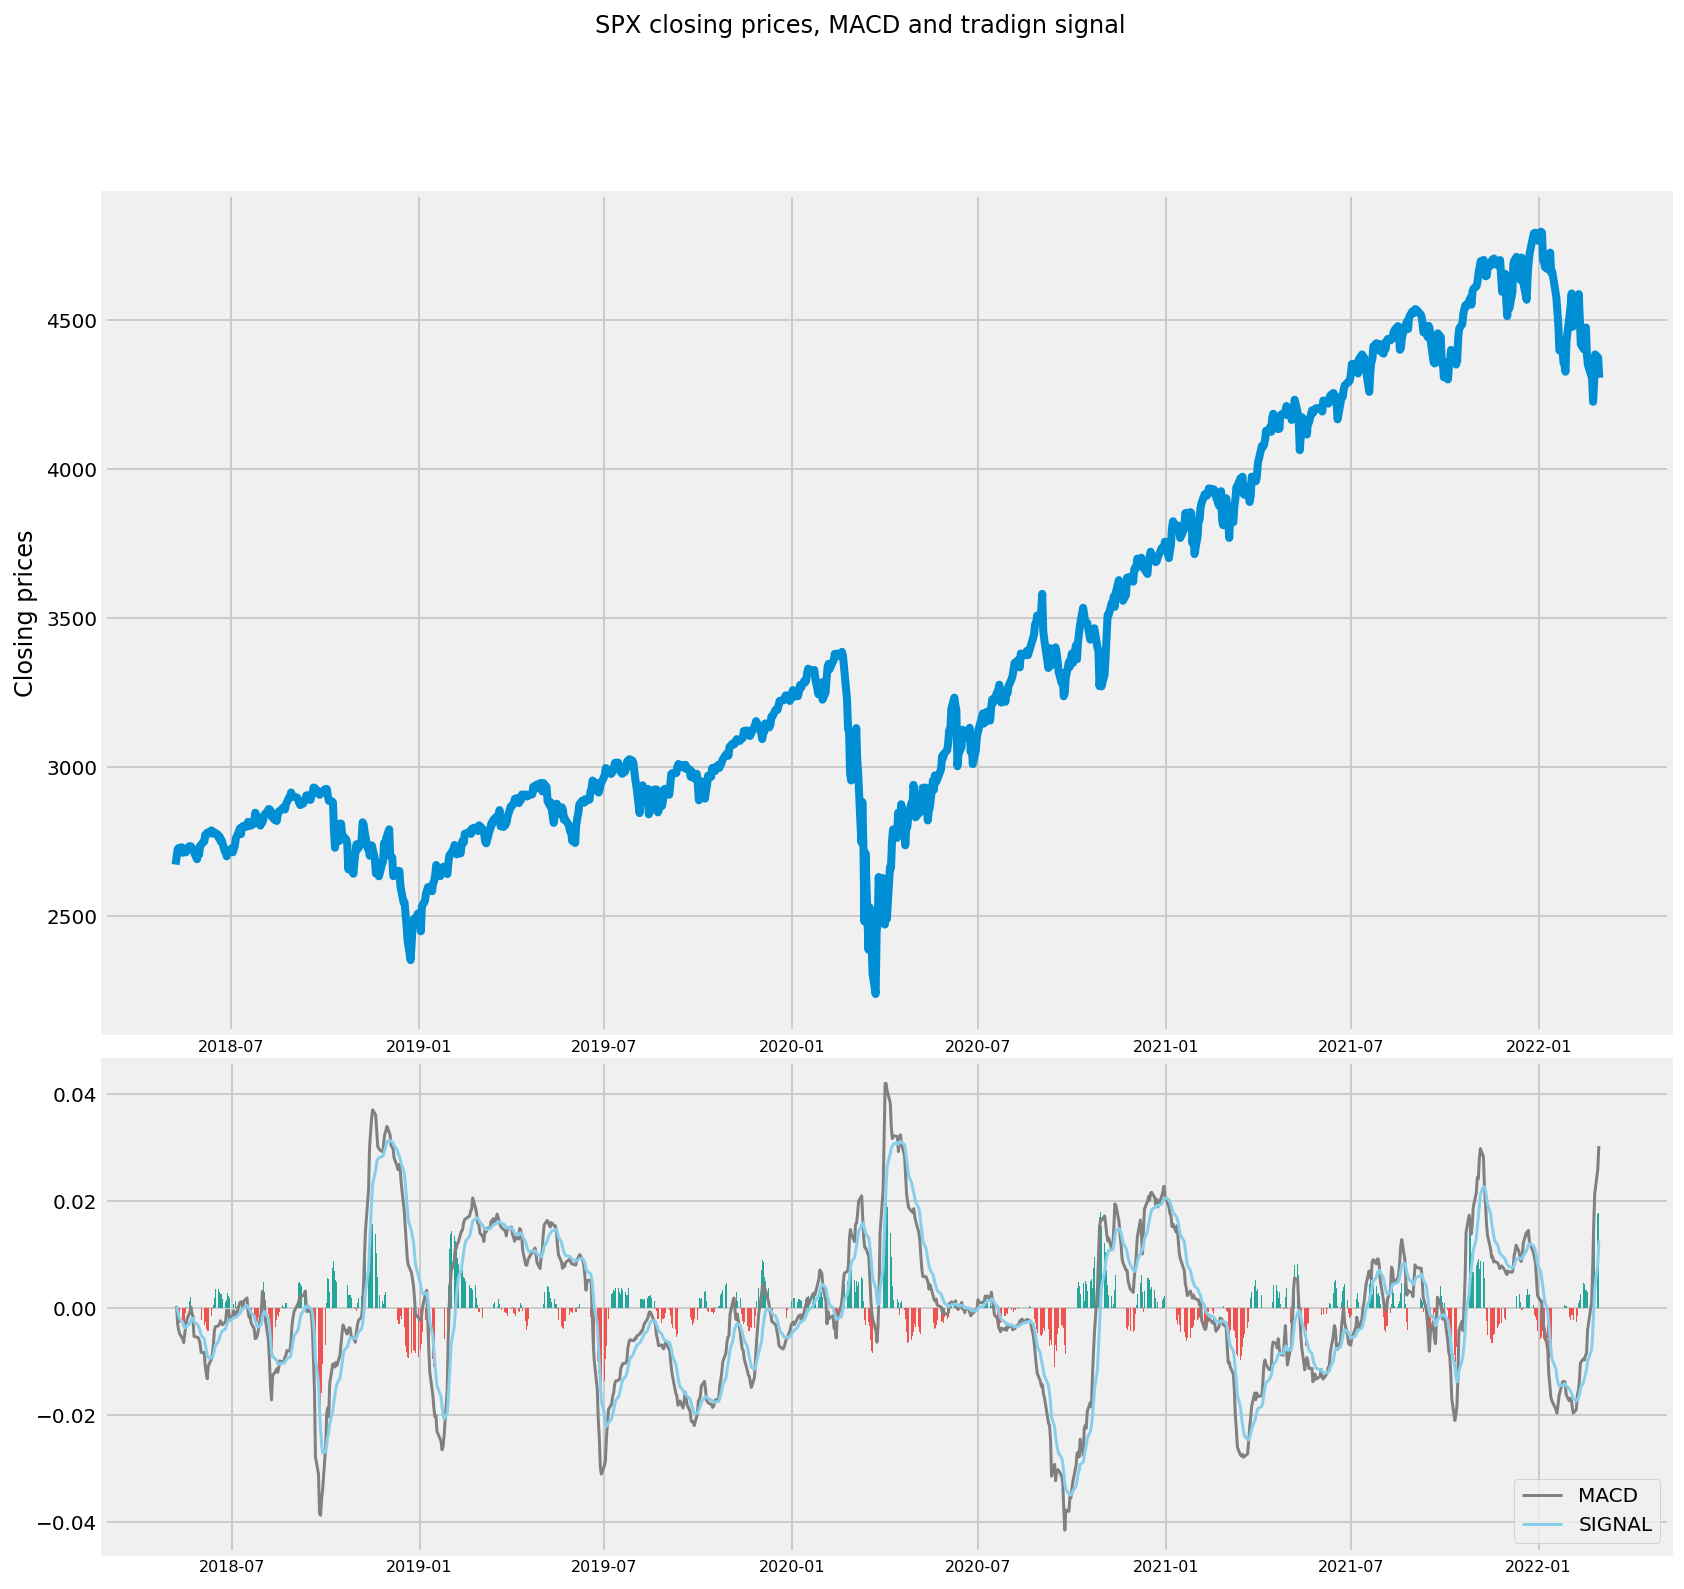

In [27]:
plt.rcParams["figure.figsize"] = (12.5,12.5)
plot_macd(spx_df, spx_hurst_macd)
plt.savefig('./figures/15. SPX with MACD signal.png')

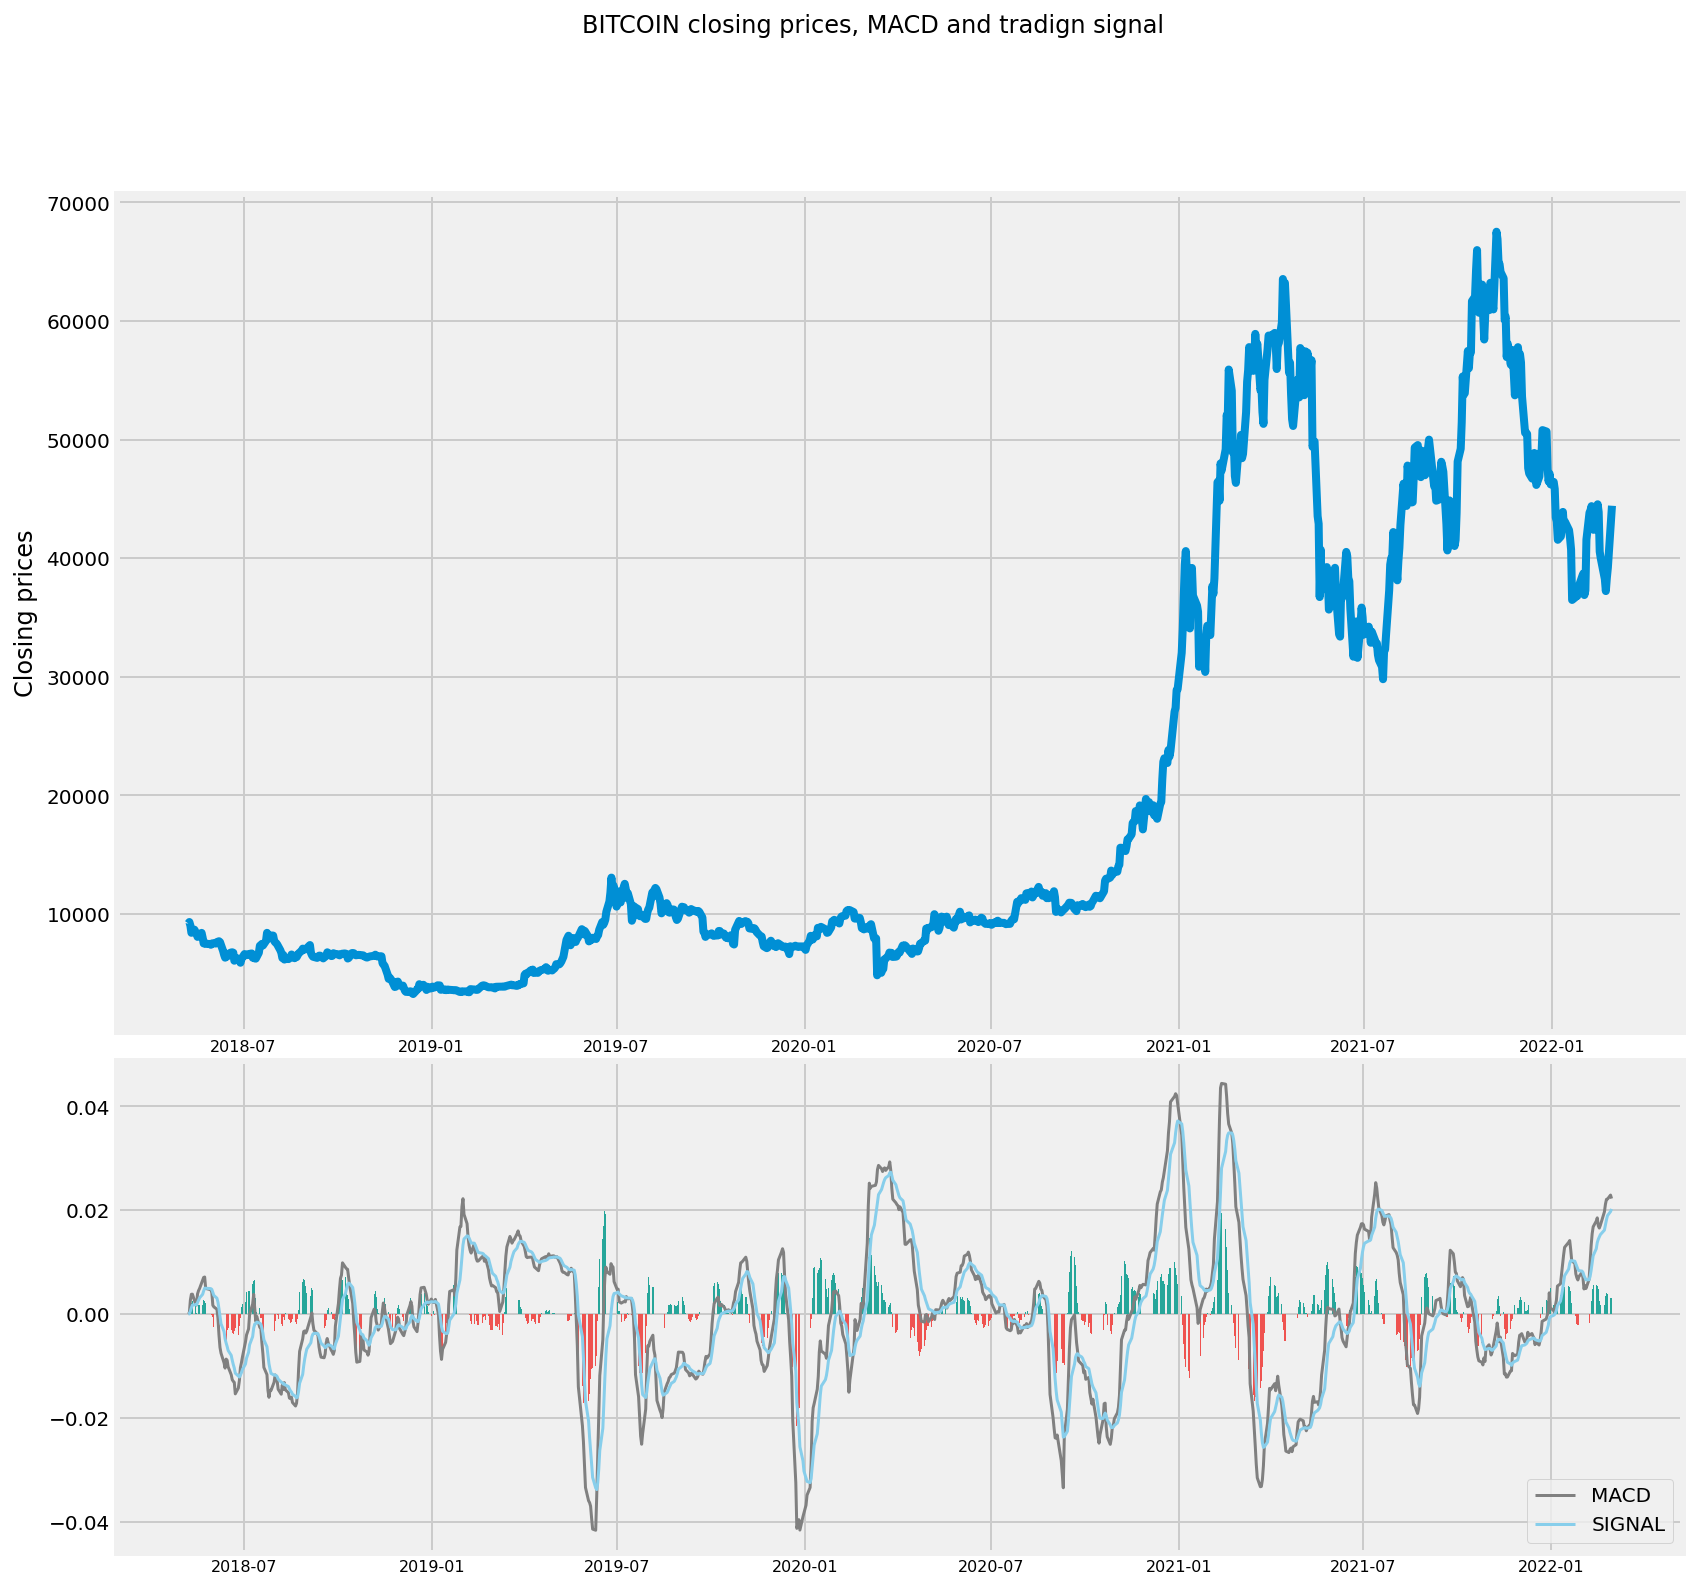

In [28]:
plot_macd(bitco_df, bitco_hurst_macd)
plt.savefig('./figures/16. BITCOIN with MACD signal.png')

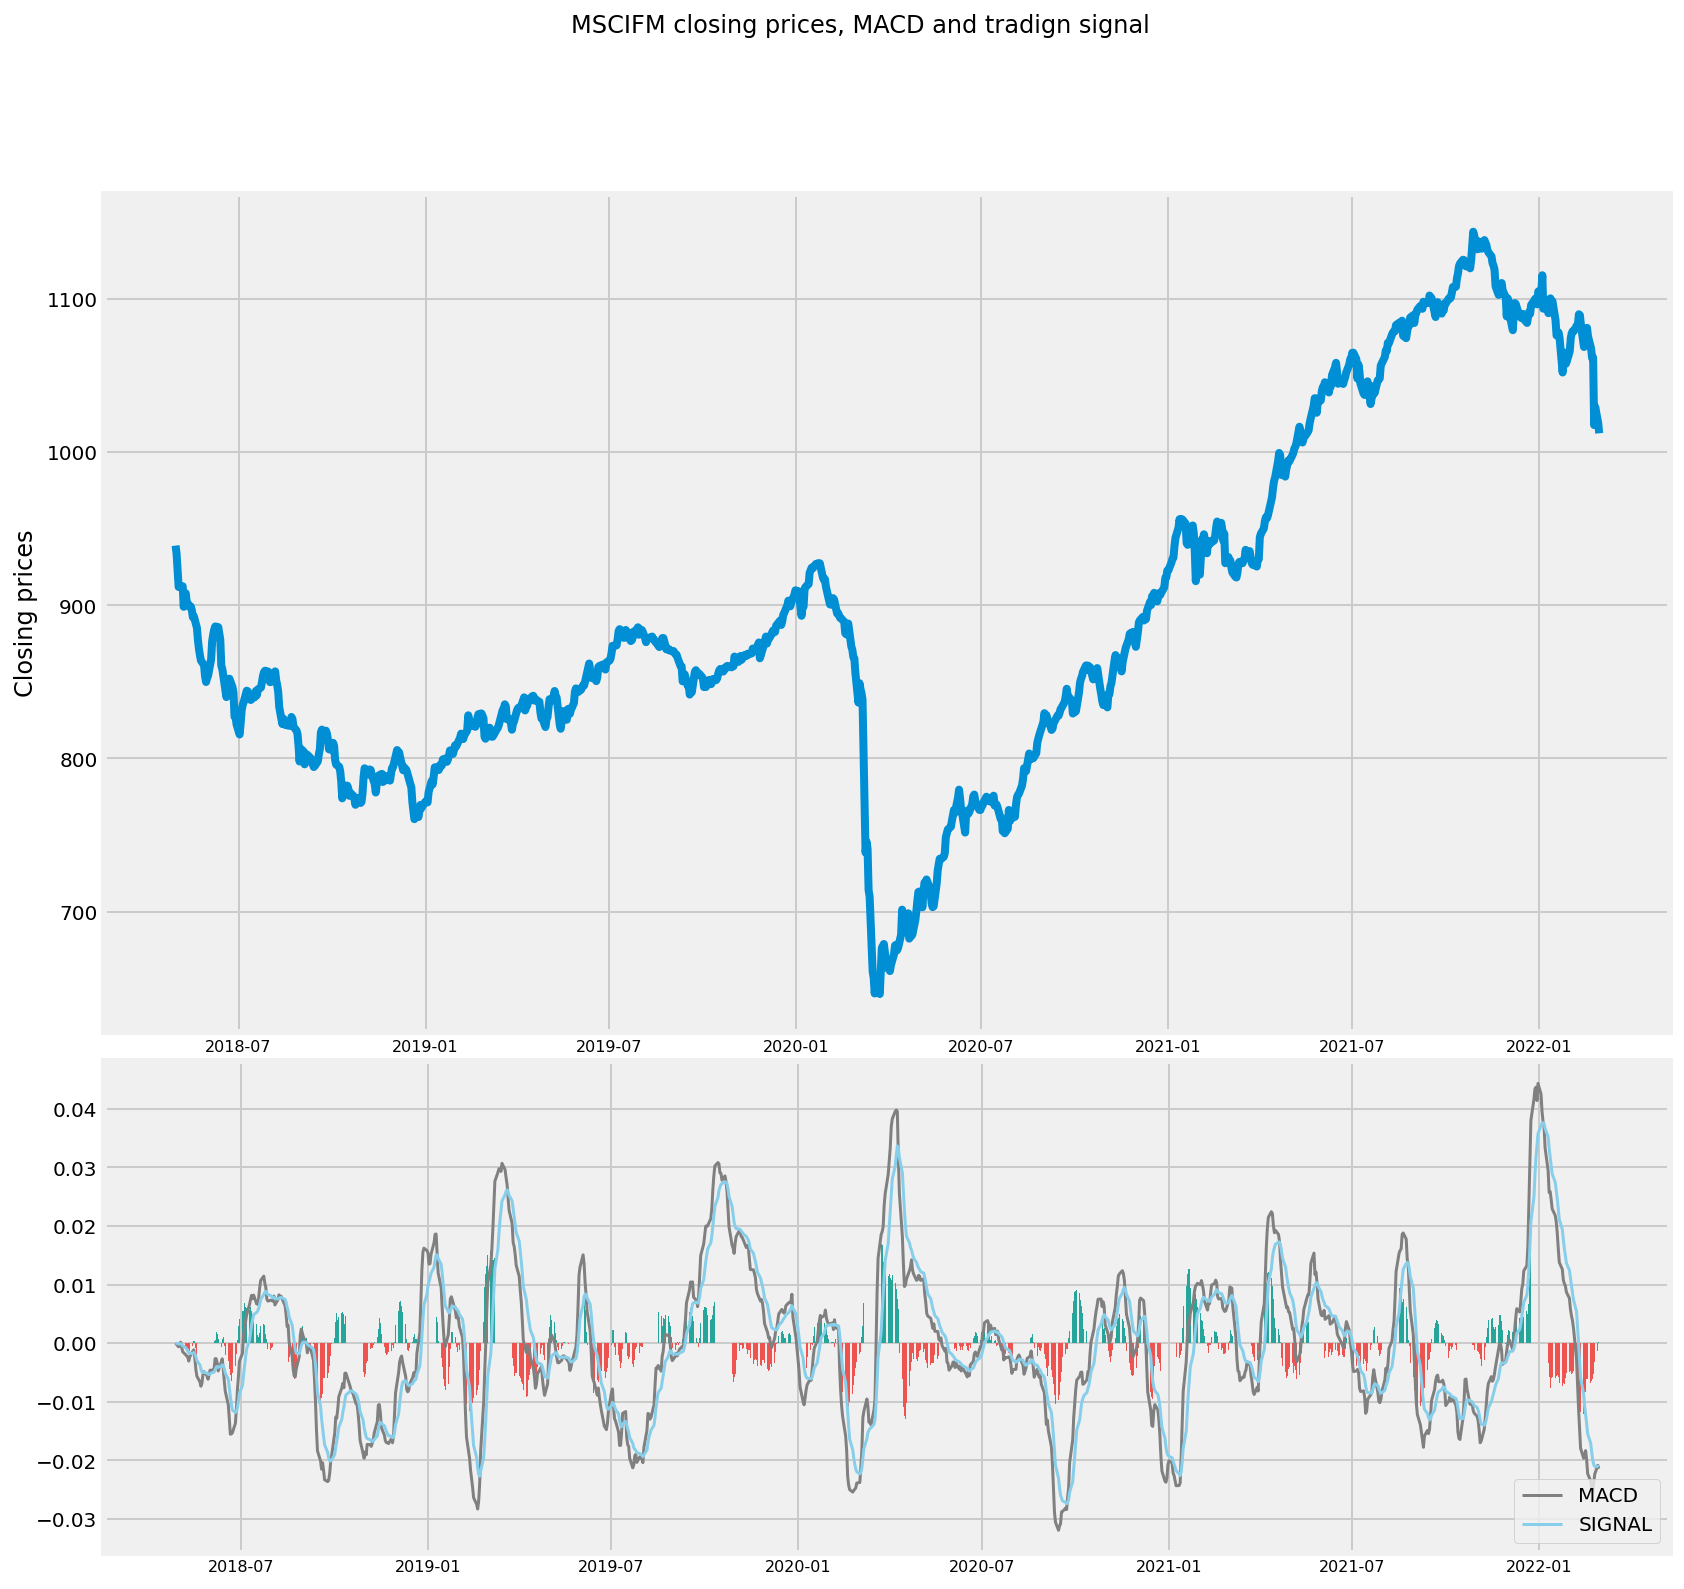

In [29]:
plot_macd(mscifm_df, mscifm_hurst_macd)
plt.savefig('./figures/17. MSCI_FM with MACD signal.png')

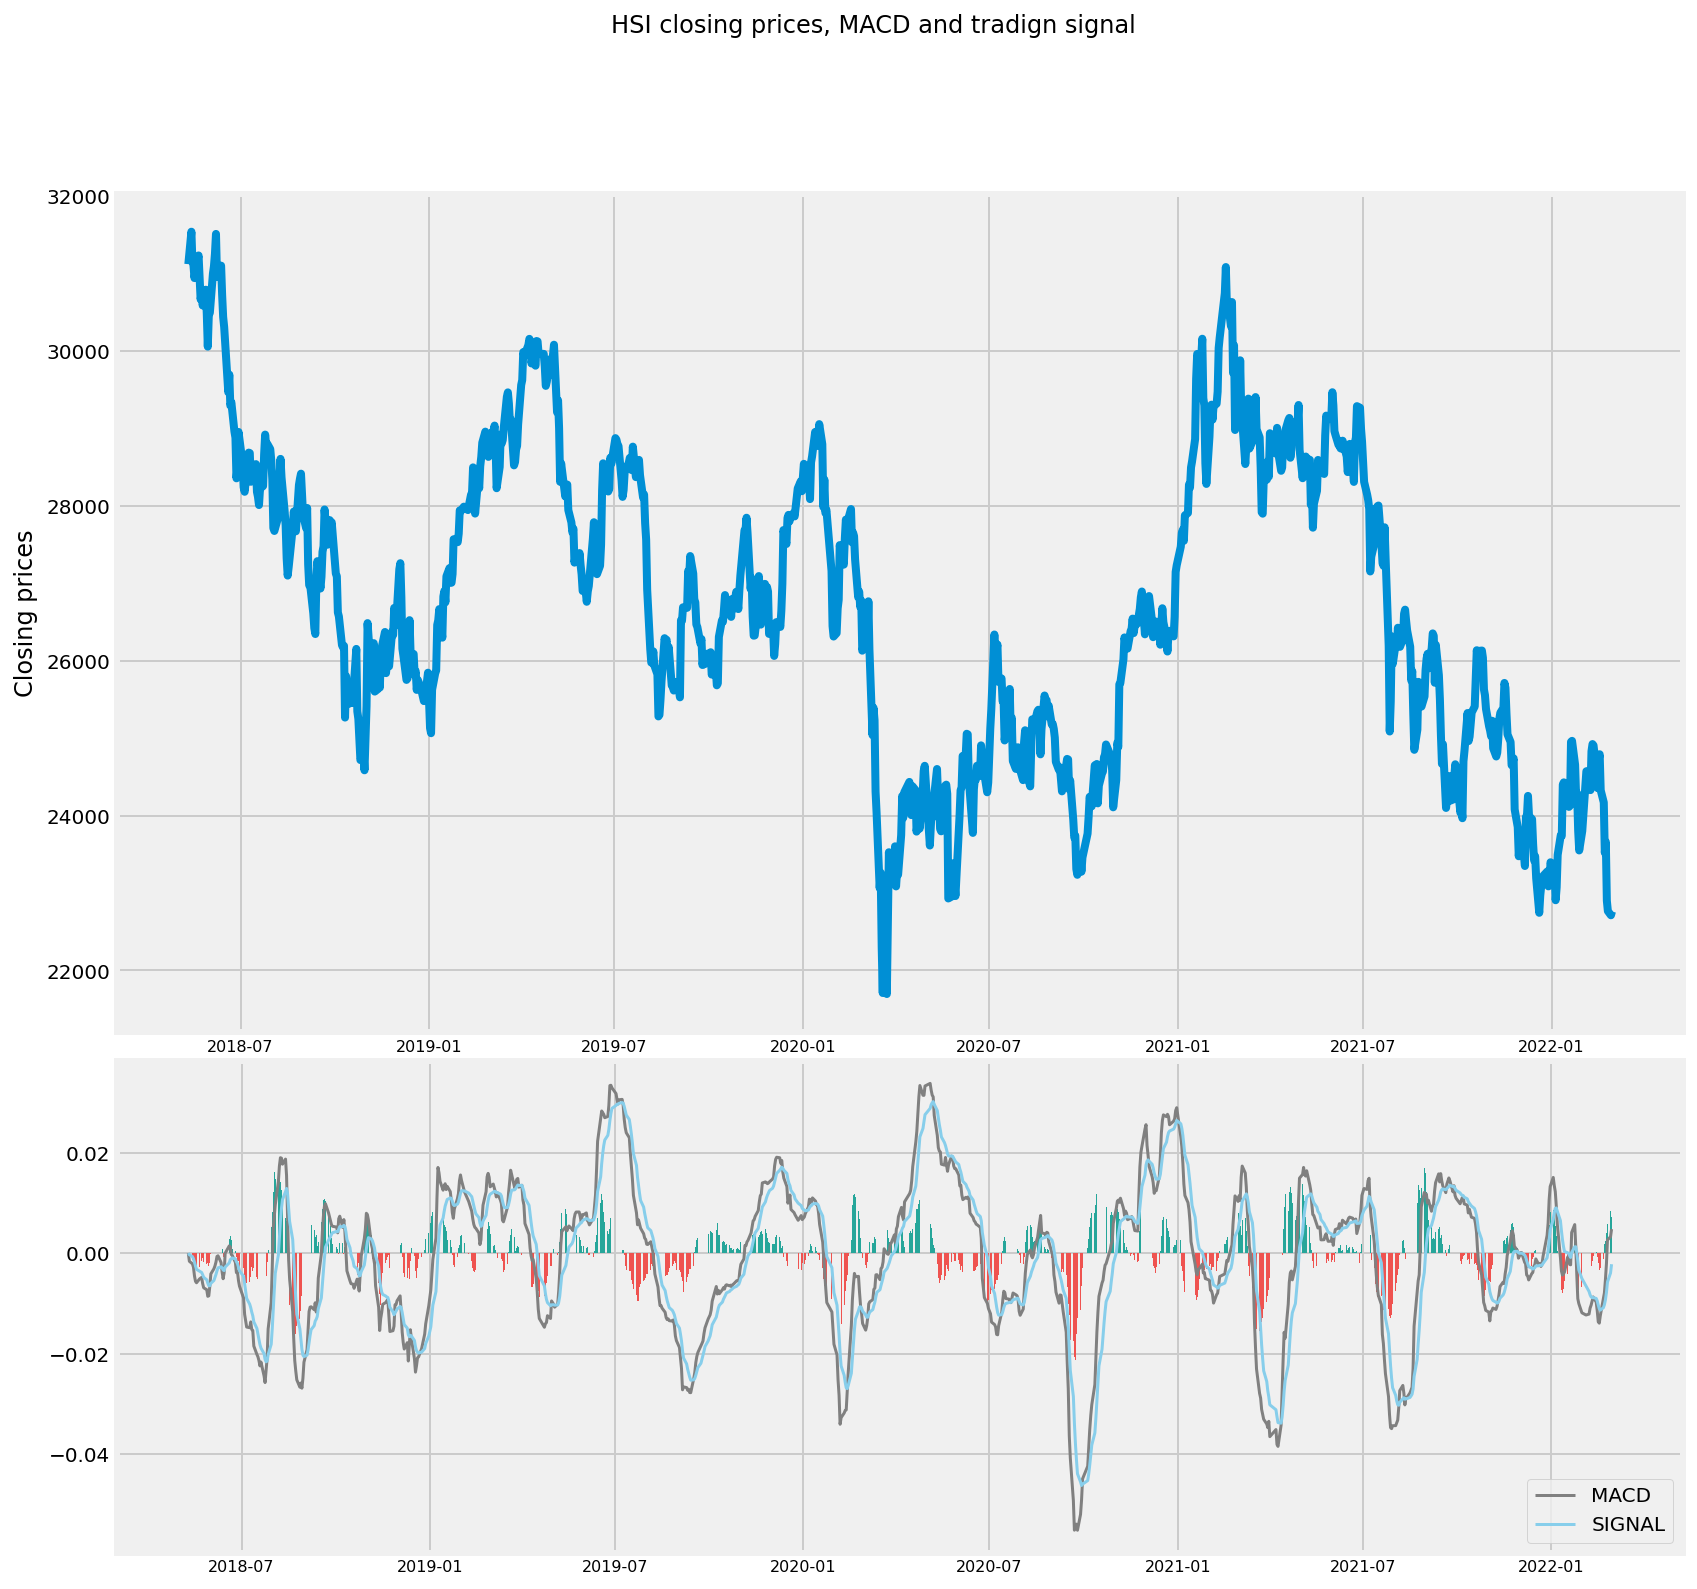

In [30]:
plot_macd(hsi_df, hsi_hurst_macd)
plt.savefig('./figures/18. HSI with MACD signal.png')

In [31]:
bitco_buy_price, bitco_sell_price, bitco_macd_signal = implement_macd_strategy(bitco.iloc[roll_days-1:], bitco_hurst_macd)
spx_buy_price, spx_sell_price, spx_macd_signal = implement_macd_strategy(spx.iloc[roll_days-1:], spx_hurst_macd)
mscifm_buy_price, mscifm_sell_price, mscifm_macd_signal = implement_macd_strategy(mscifm.iloc[roll_days-1:], mscifm_hurst_macd)
hsi_buy_price, hsi_sell_price, hsi_macd_signal = implement_macd_strategy(hsi.iloc[roll_days-1:], hsi_hurst_macd)


#### Here we will plot our MACD signal along with Hurst signal to determine Long/Short position

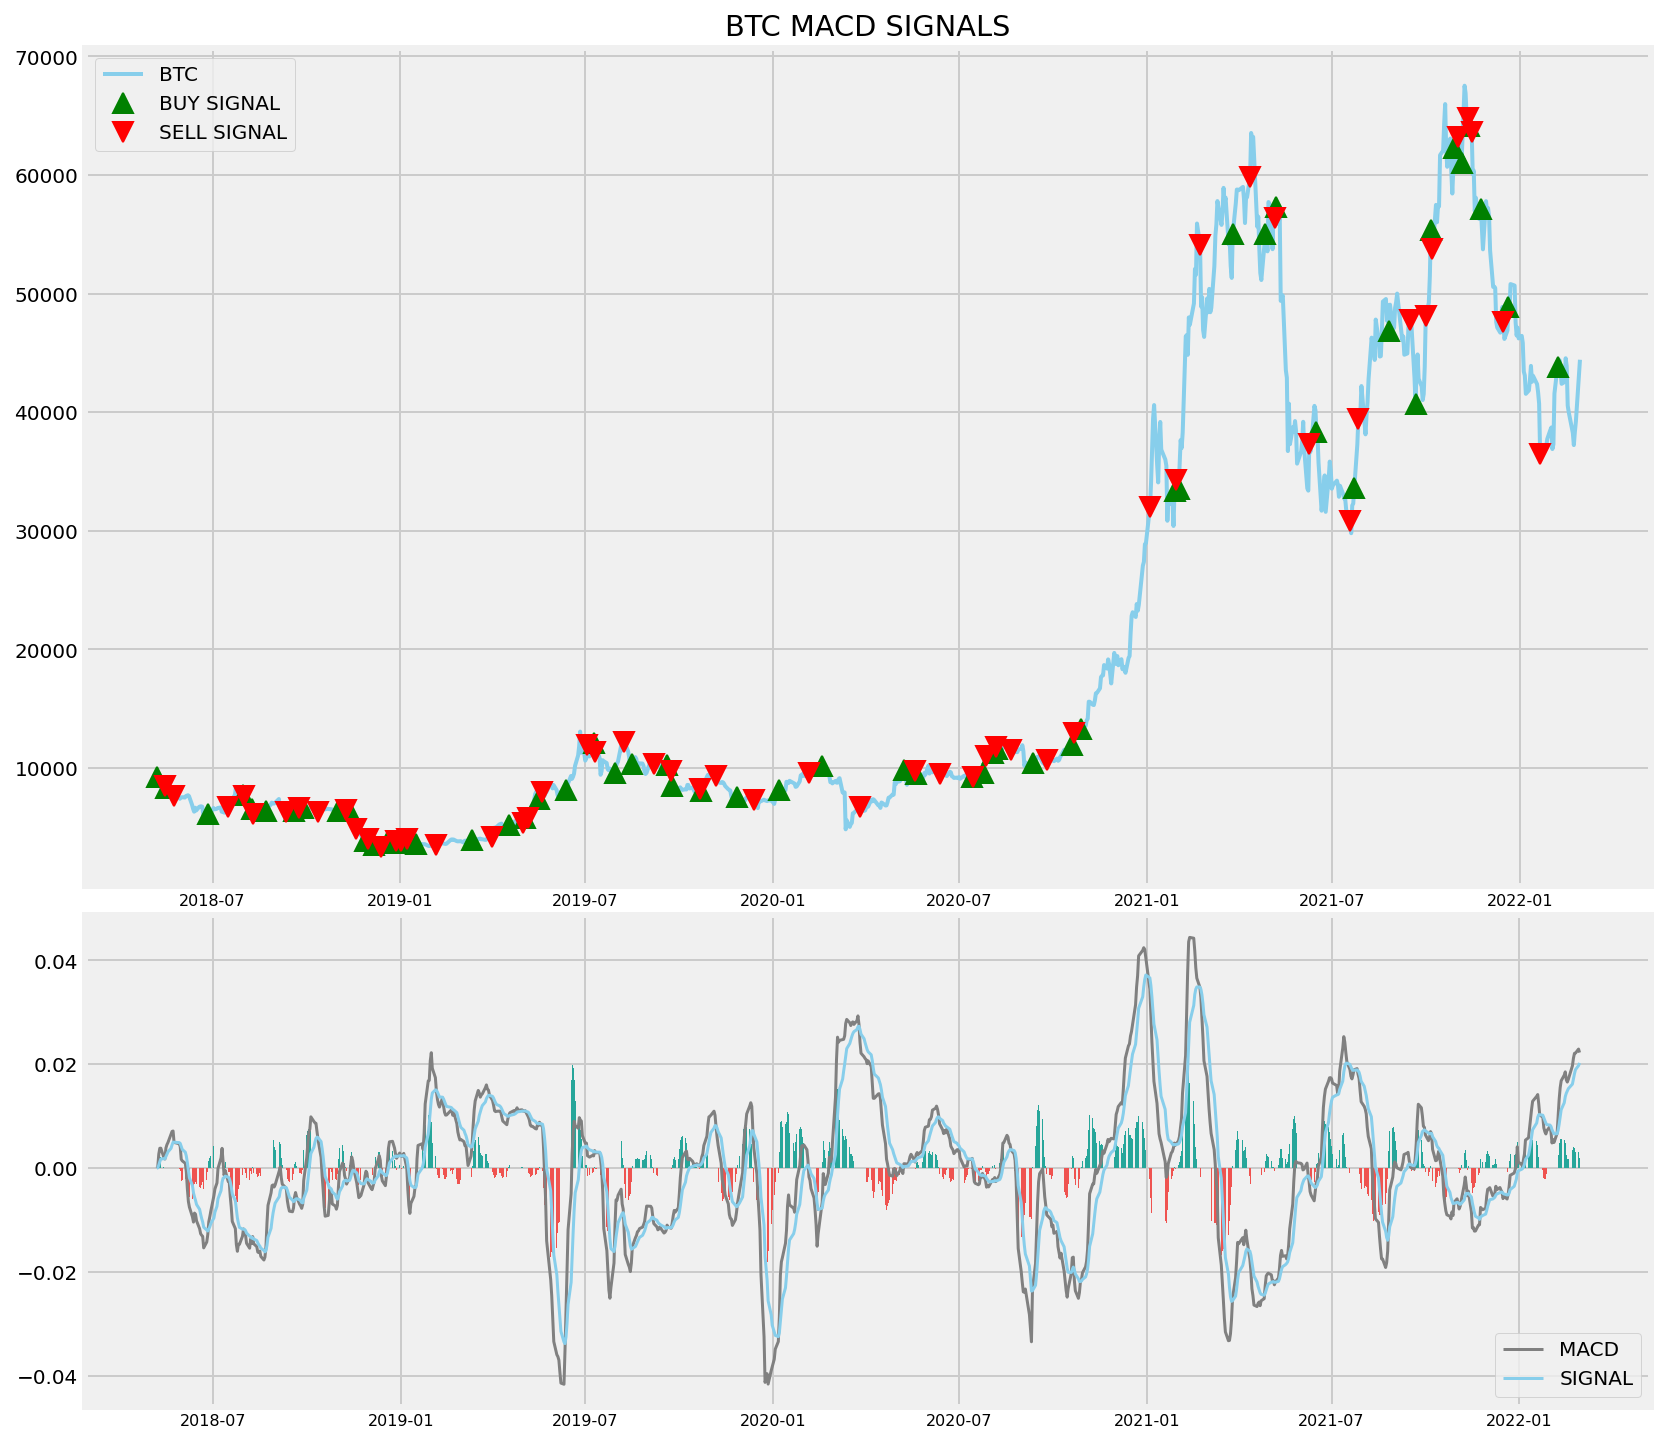

In [32]:
plt.rcParams["figure.figsize"] = (12.5,12.5)
plot_macd_strategy(bitco.iloc[roll_days-1:], bitco_hurst_macd, bitco_buy_price, bitco_sell_price, ticker='BTC')

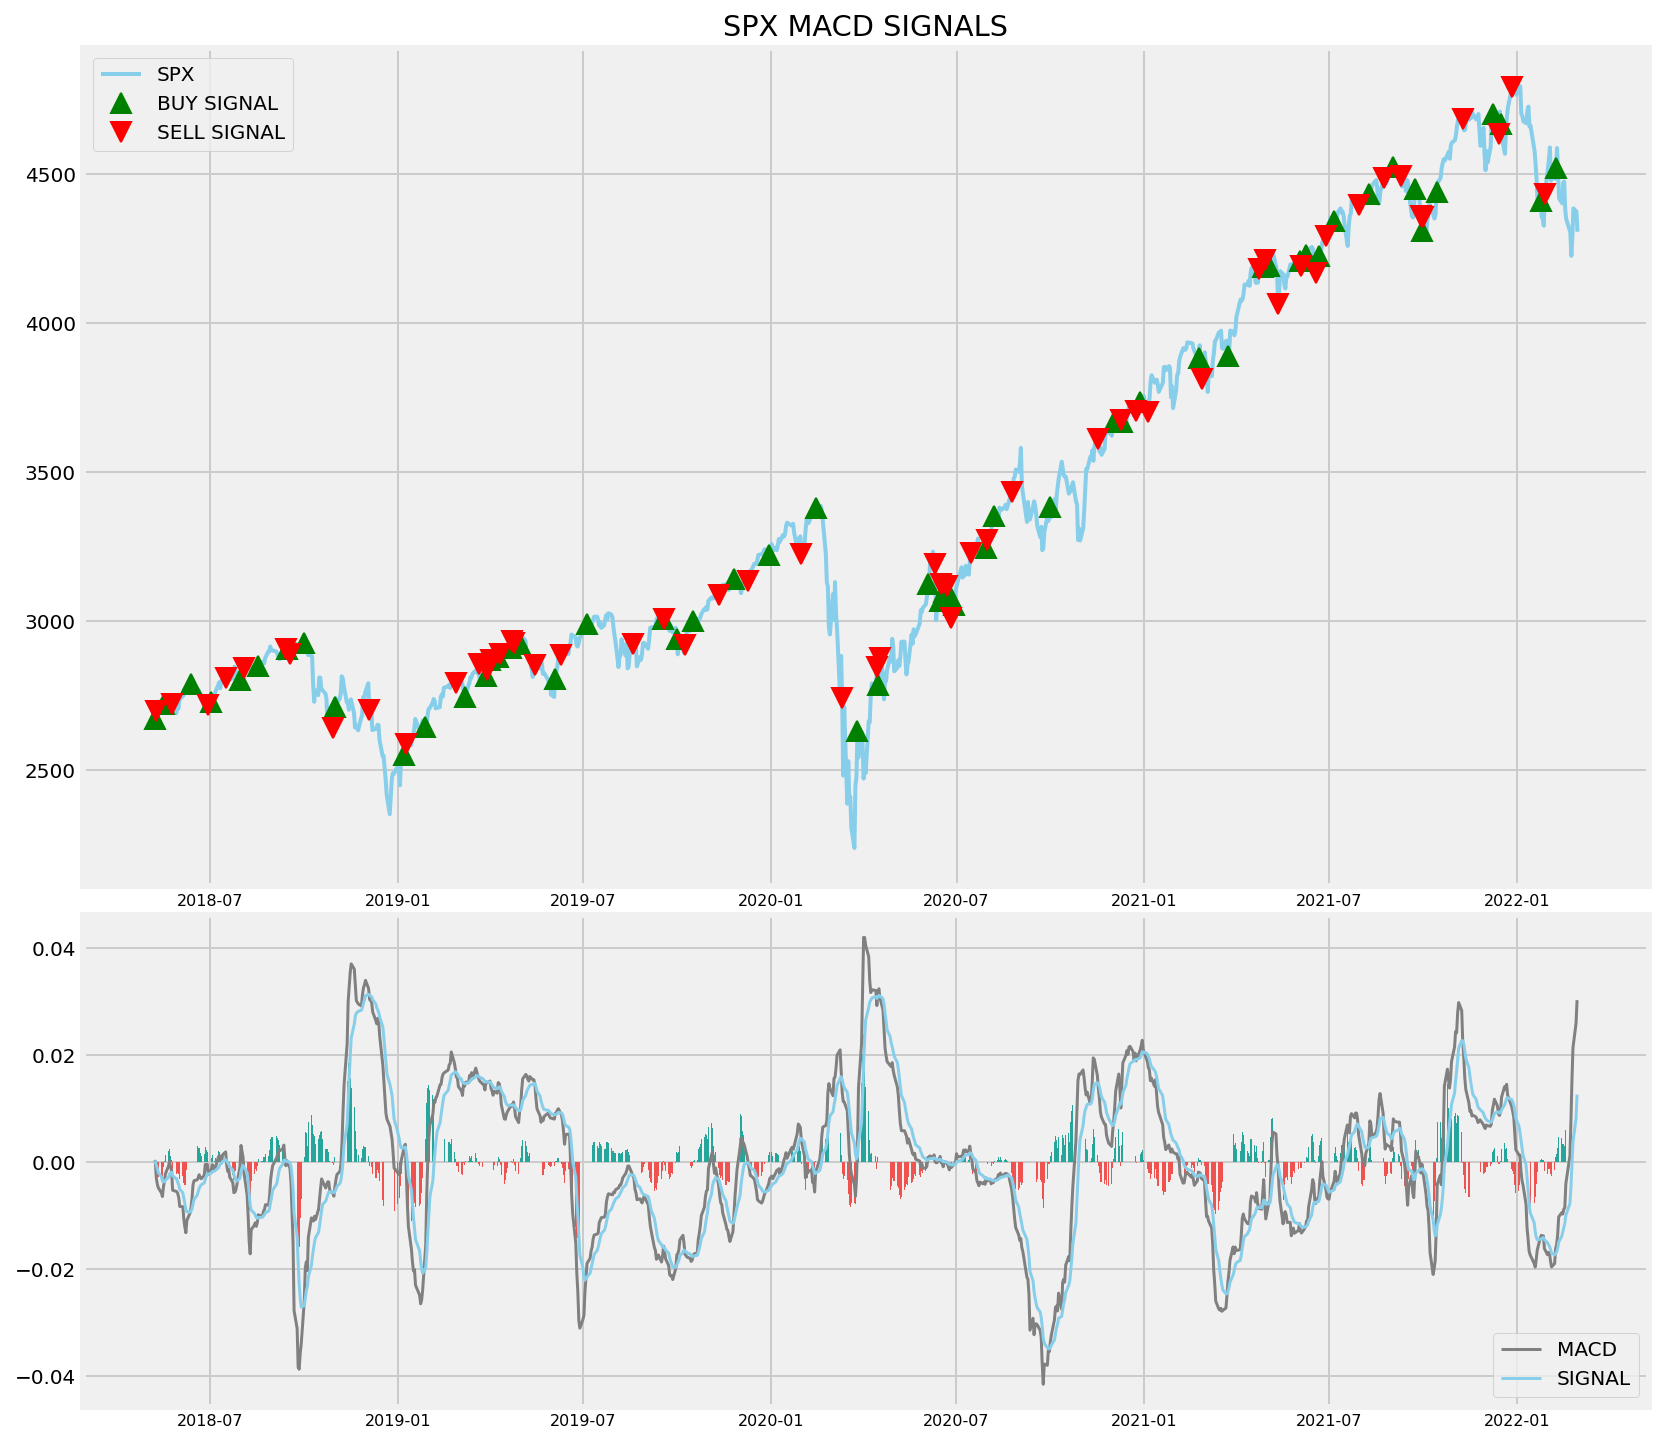

In [33]:
plot_macd_strategy(spx.iloc[roll_days-1:], spx_hurst_macd, spx_buy_price, spx_sell_price, ticker='SPX')

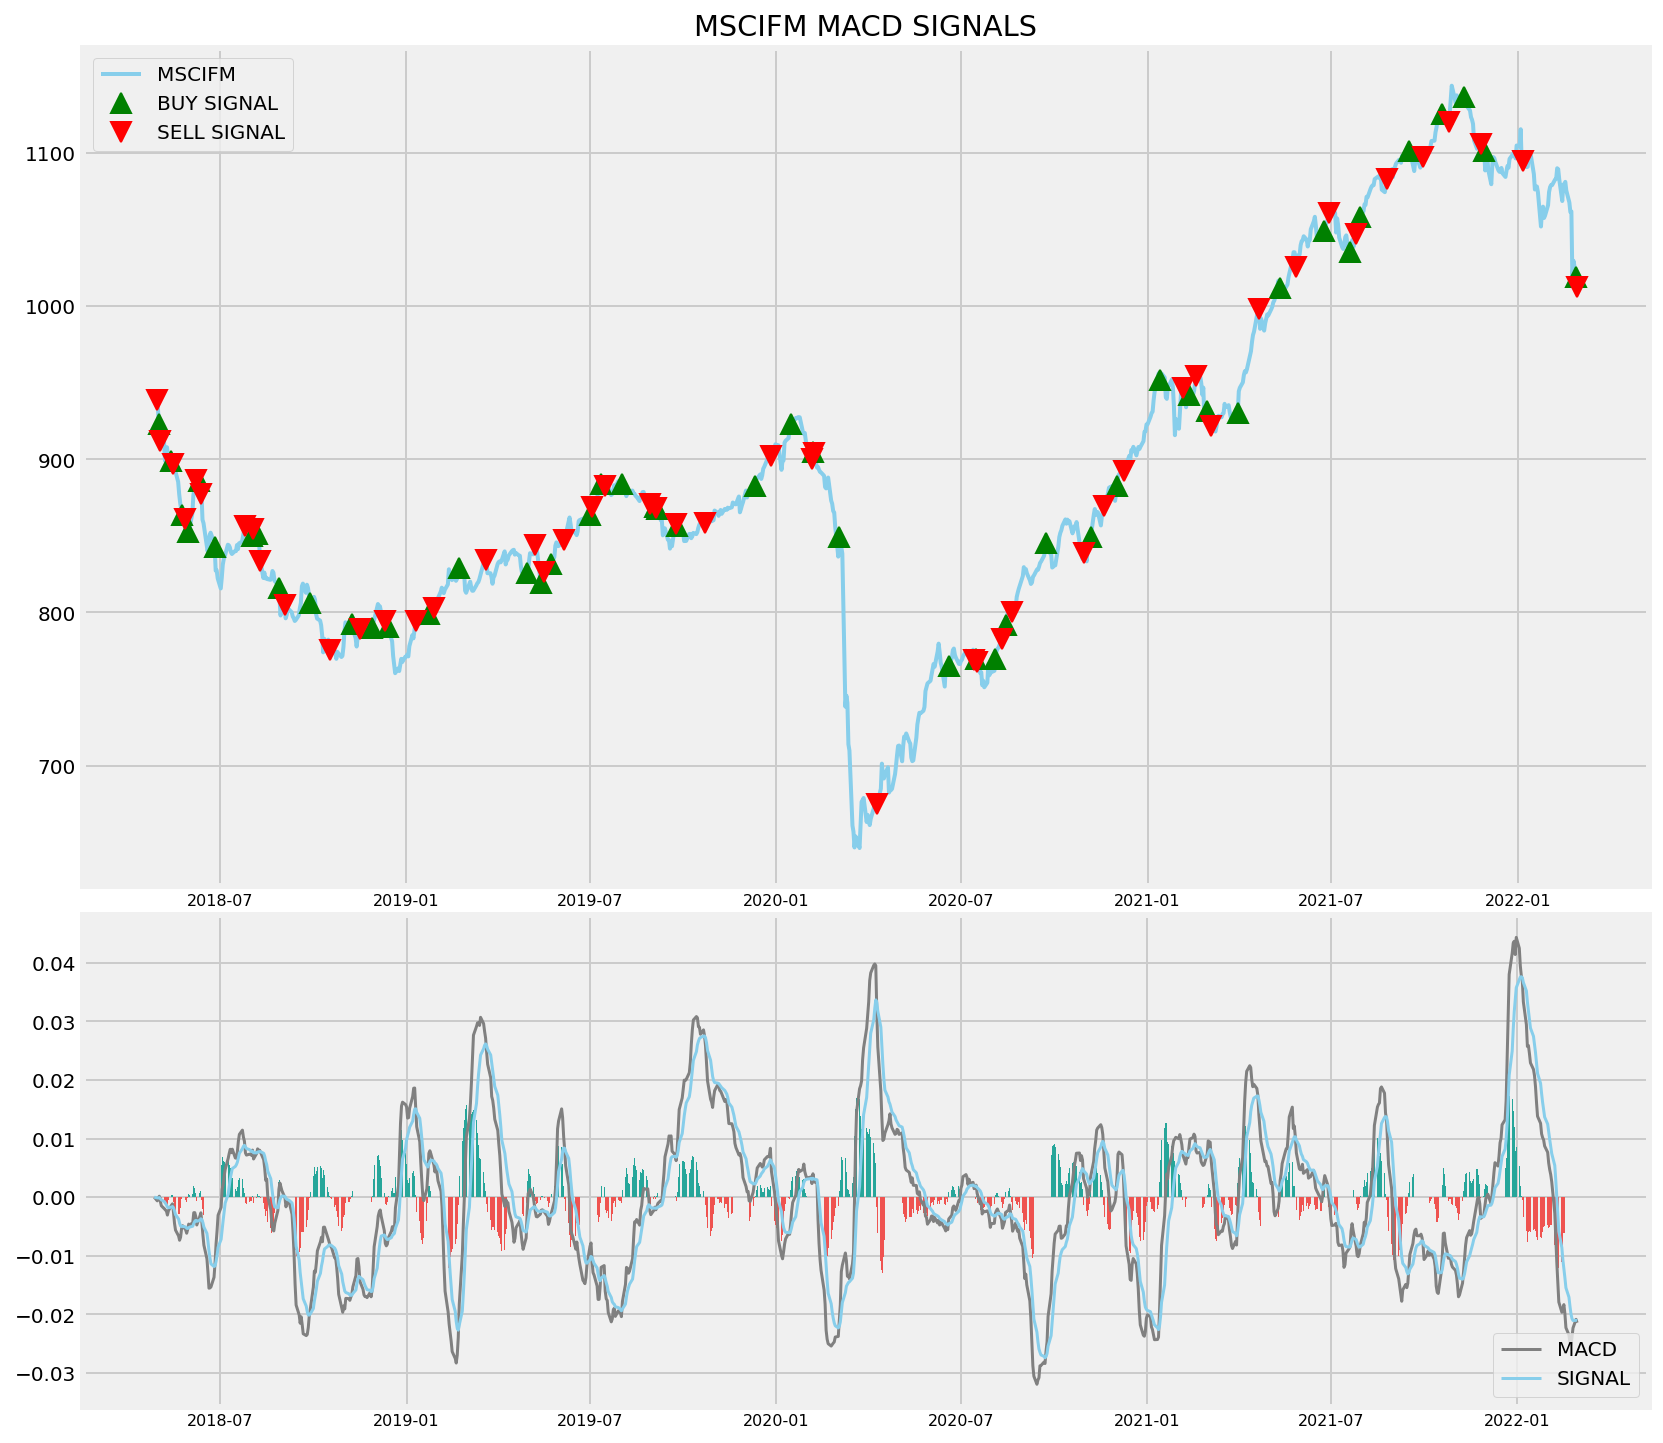

In [34]:
plot_macd_strategy(mscifm.iloc[roll_days-1:], mscifm_hurst_macd, mscifm_buy_price, mscifm_sell_price, ticker='MSCIFM')

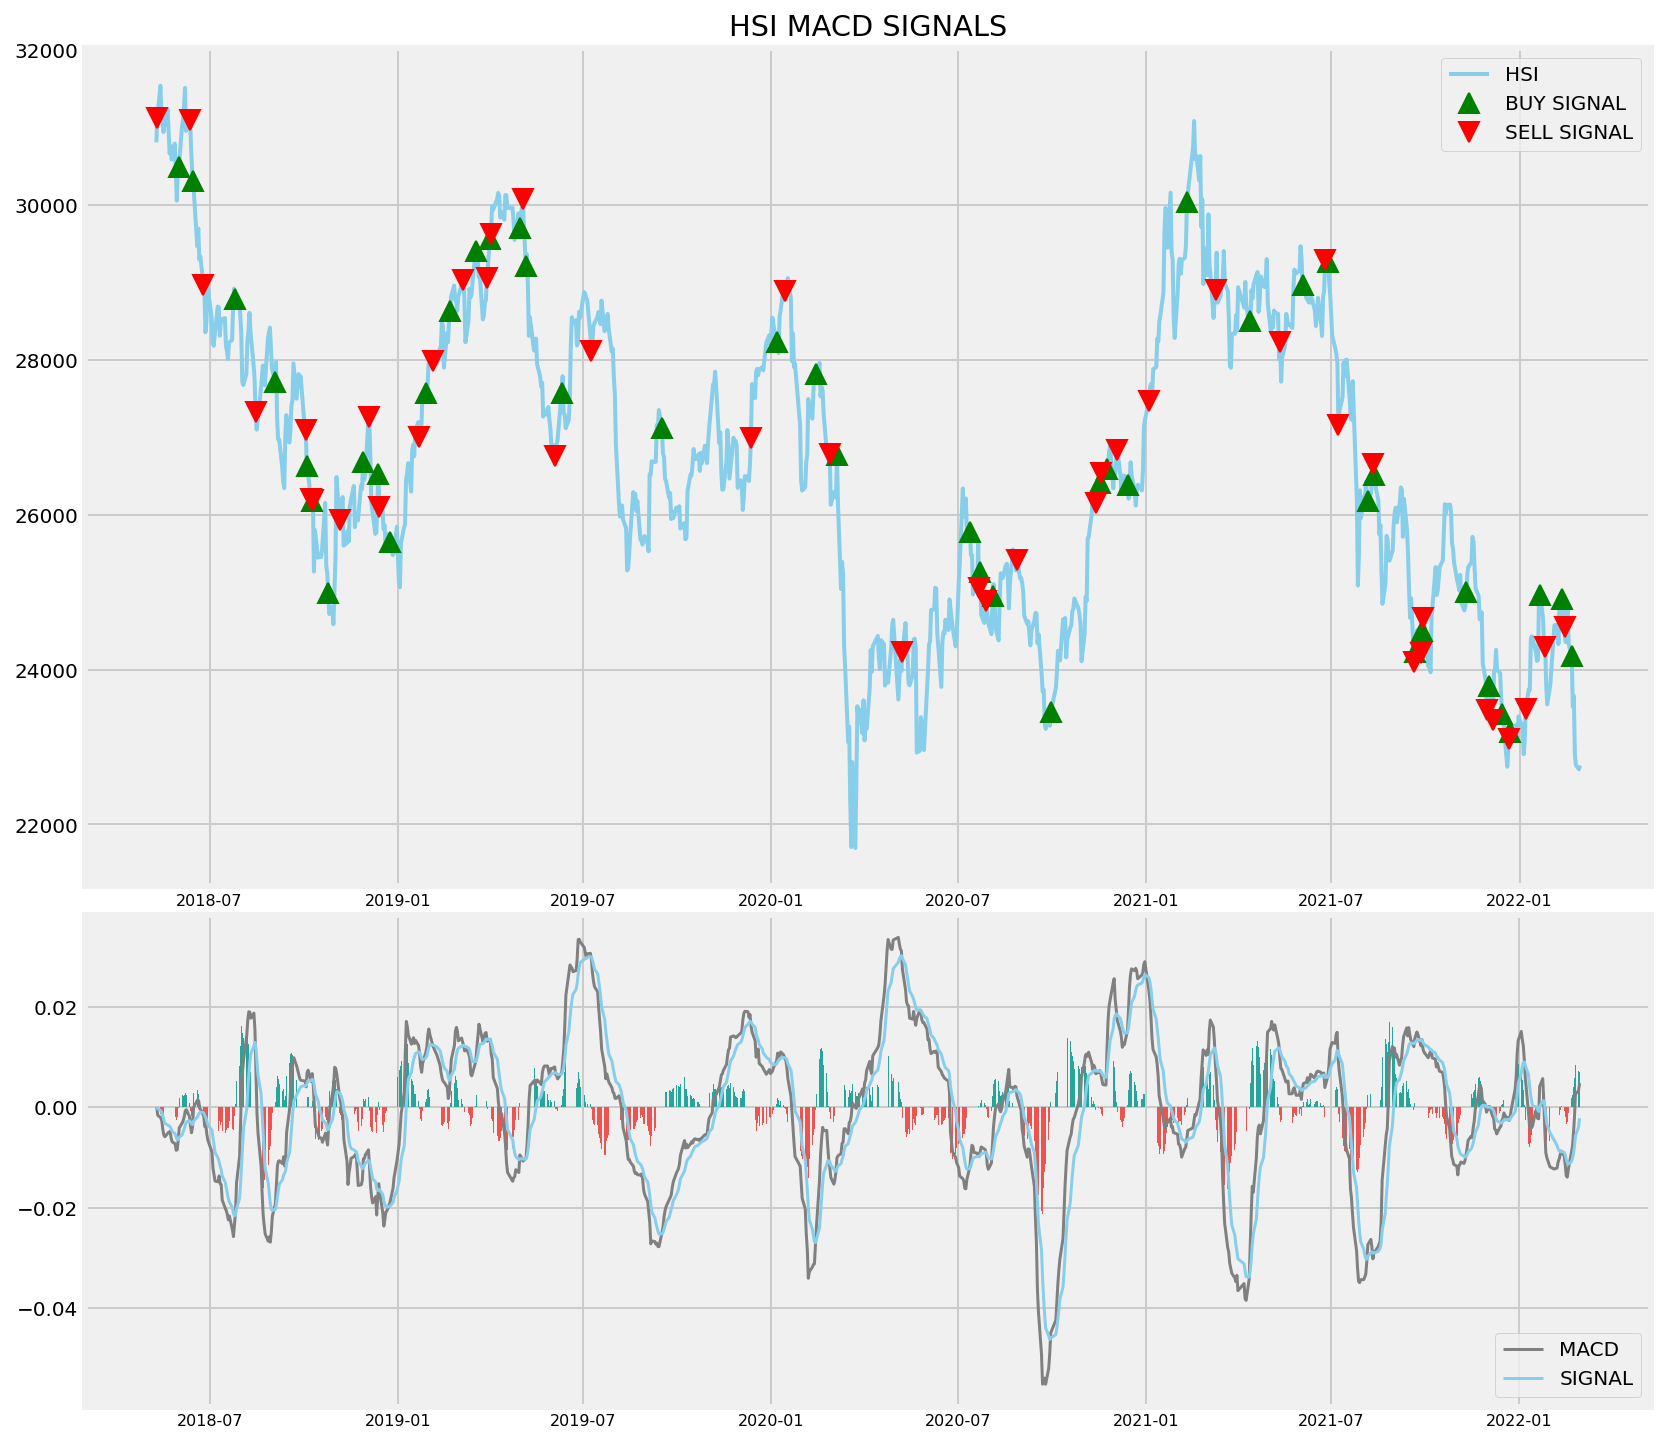

In [35]:
plot_macd_strategy(hsi.iloc[roll_days-1:], hsi_hurst_macd, hsi_buy_price, hsi_sell_price, ticker='HSI')
plt.rcParams["figure.figsize"] = (12.5,12.5)

#### Now we will test the strategy with Bt package 

In [36]:
res_hsi_hurst, plot_data_hsi_hurst, ax_name_hsi_hurst = signal_strategy(hsi, series_name="bt_hsi_hurst", model_type="Hurst")

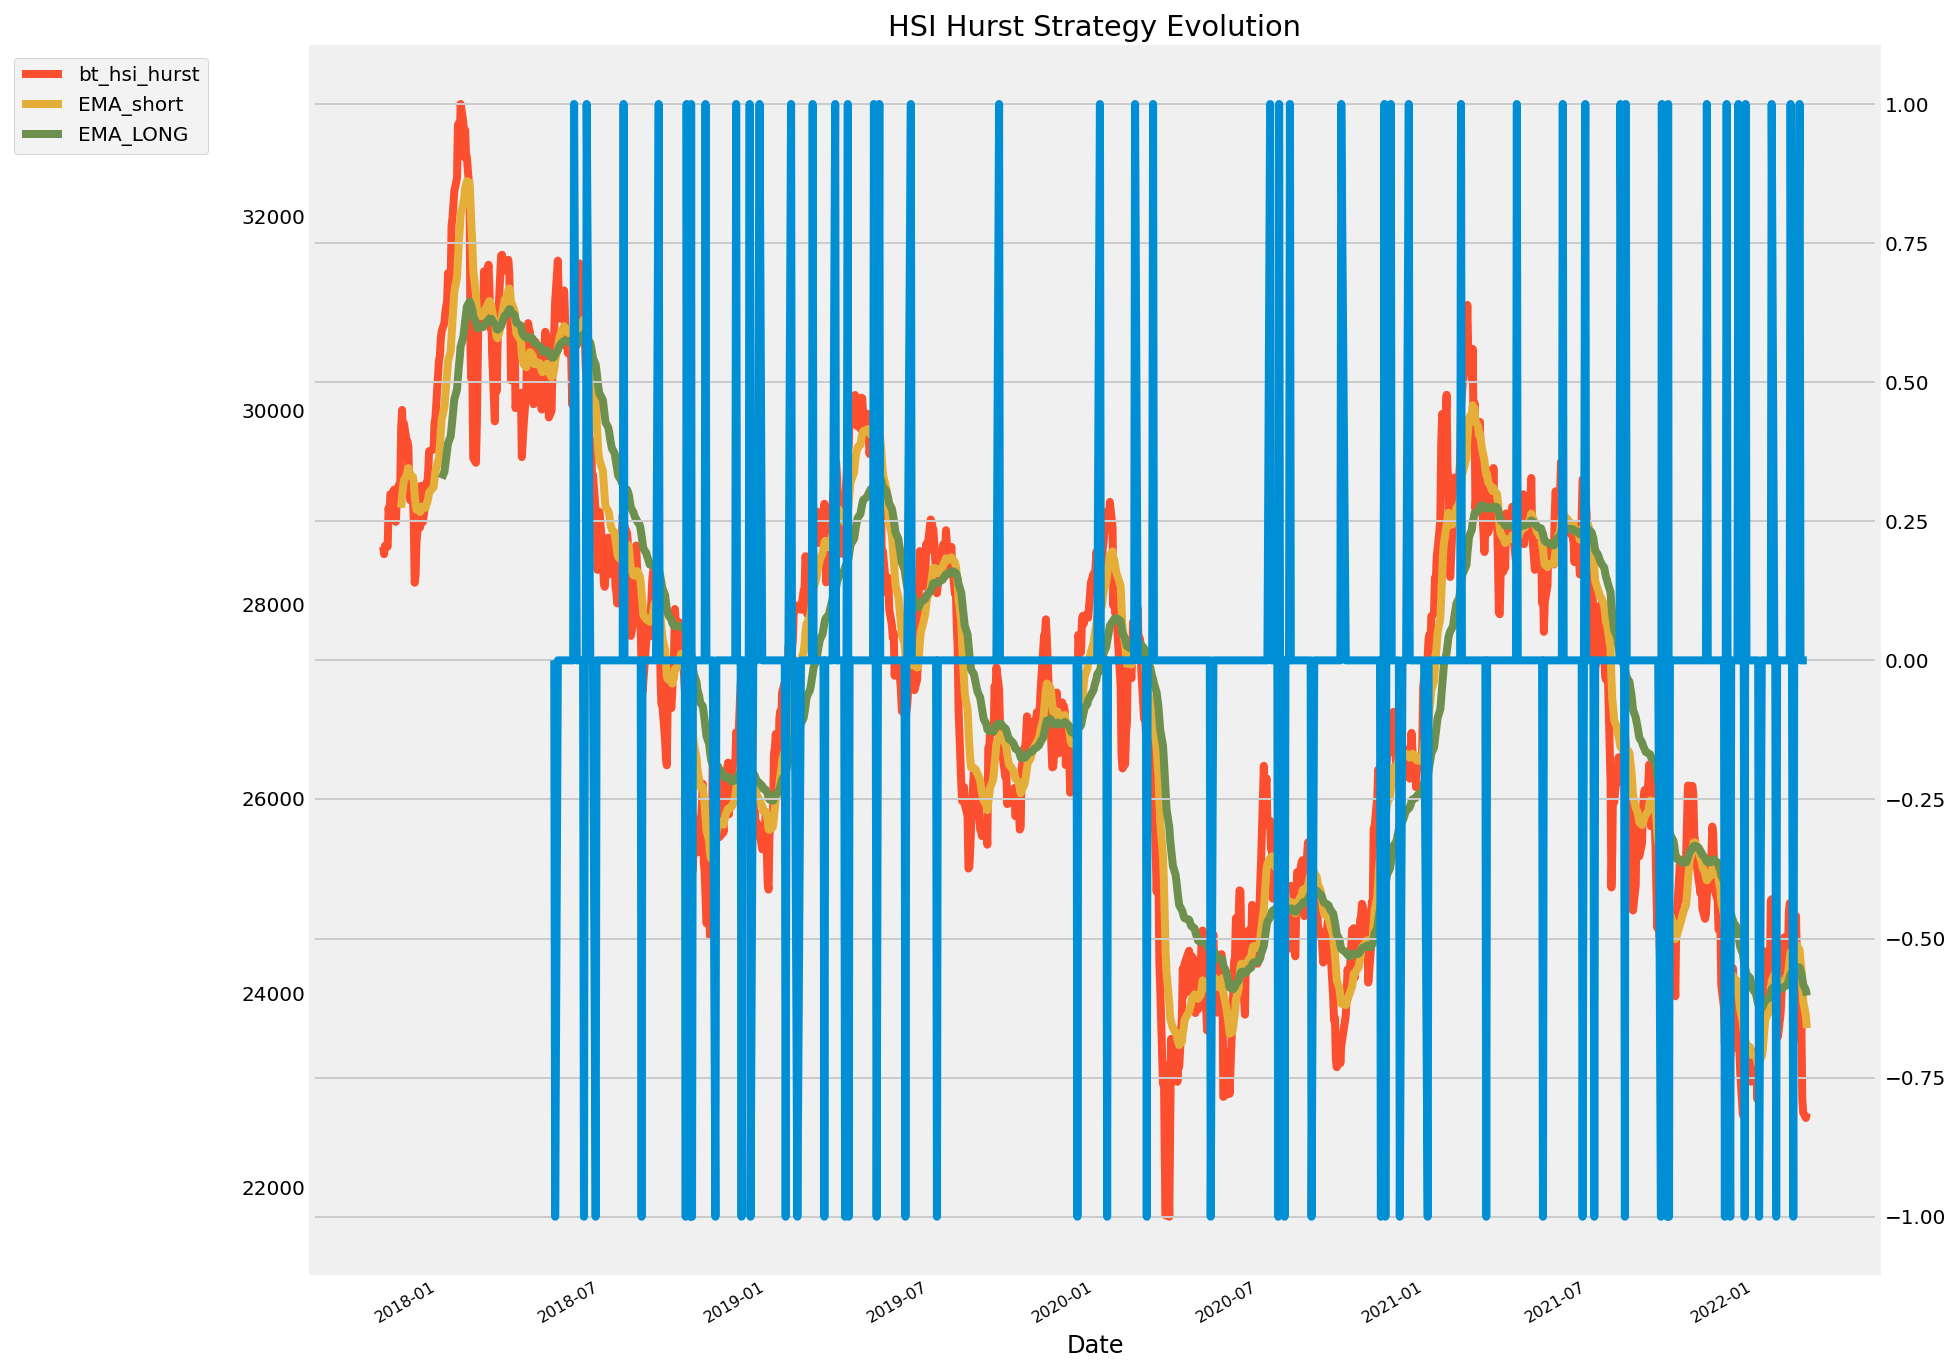

In [37]:
plot_data_hsi_hurst.plot(secondary_y = ax_name_hsi_hurst, title = 'HSI Hurst Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
plt.rcParams["figure.figsize"] = (12.5,12.5)


In [38]:
res_spx_hurst, plot_data_spx_hurst, ax_name_spx_hurst = signal_strategy(spx, series_name="bt_spx_hurst", model_type="Hurst")


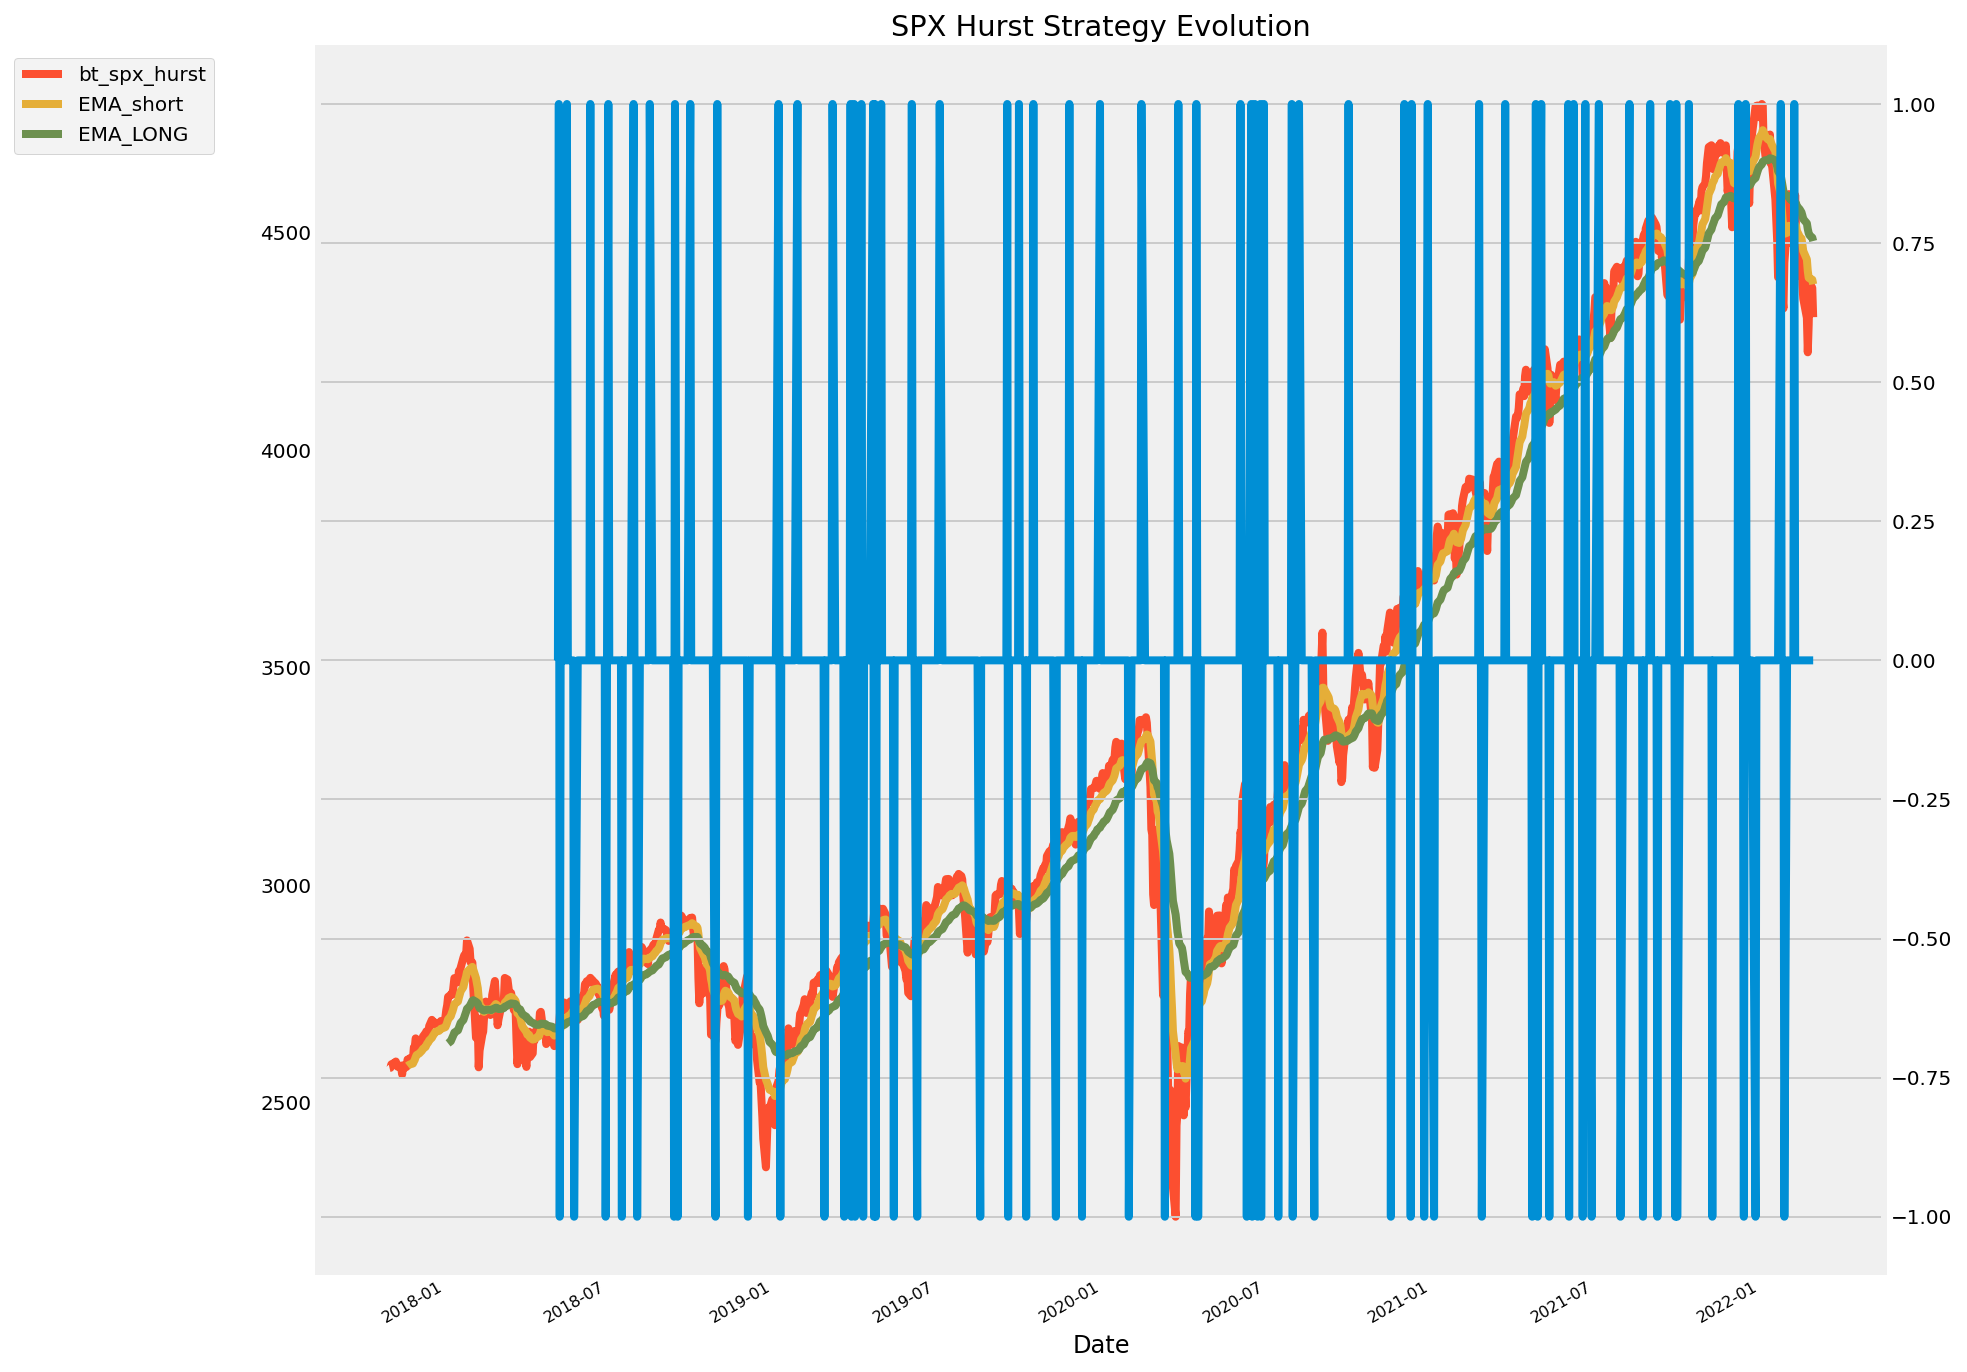

In [39]:
plot_data_spx_hurst.plot(secondary_y = ax_name_spx_hurst, title = 'SPX Hurst Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
# Use the following if the graph is no clear
plt.rcParams["figure.figsize"] = (12.5,12.5)

In [40]:
res_btc_hurst, plot_data_btc_hurst, ax_name_btc_hurst = signal_strategy(bitco, series_name="bt_btc_hurst", model_type="Hurst")

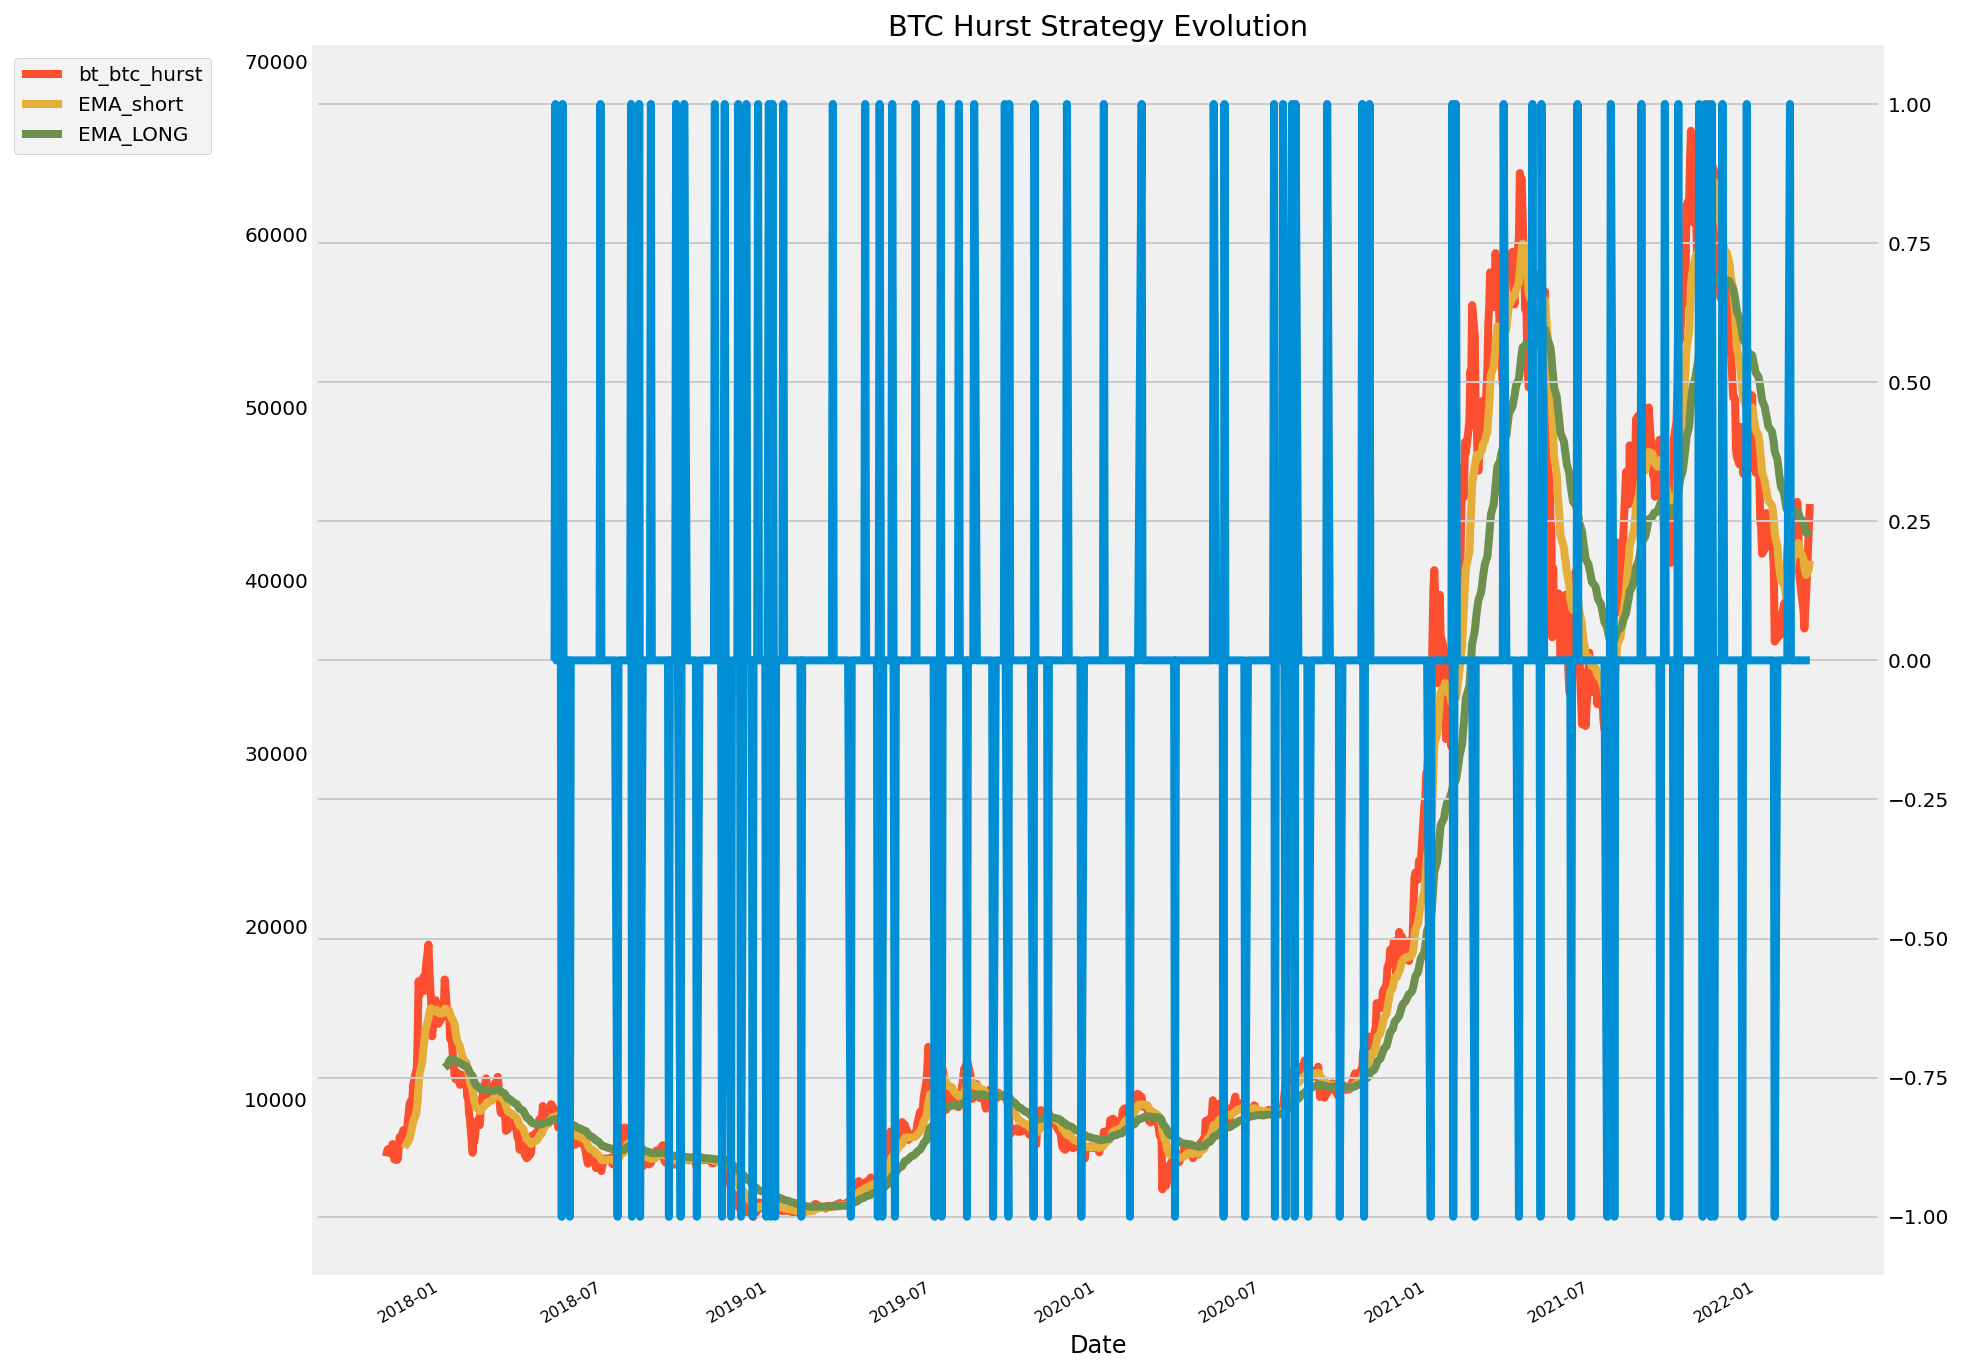

In [41]:
plot_data_btc_hurst.plot(secondary_y = ax_name_btc_hurst, title = 'BTC Hurst Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
# Use the following if the graph is no clear
plt.rcParams["figure.figsize"] = (12.5,12.5)


In [42]:
res_mscifm_hurst, plot_data_mscifm_hurst, ax_name_mscifm_hurst = signal_strategy(mscifm, series_name="bt_mscifm_hurst", model_type="Hurst")

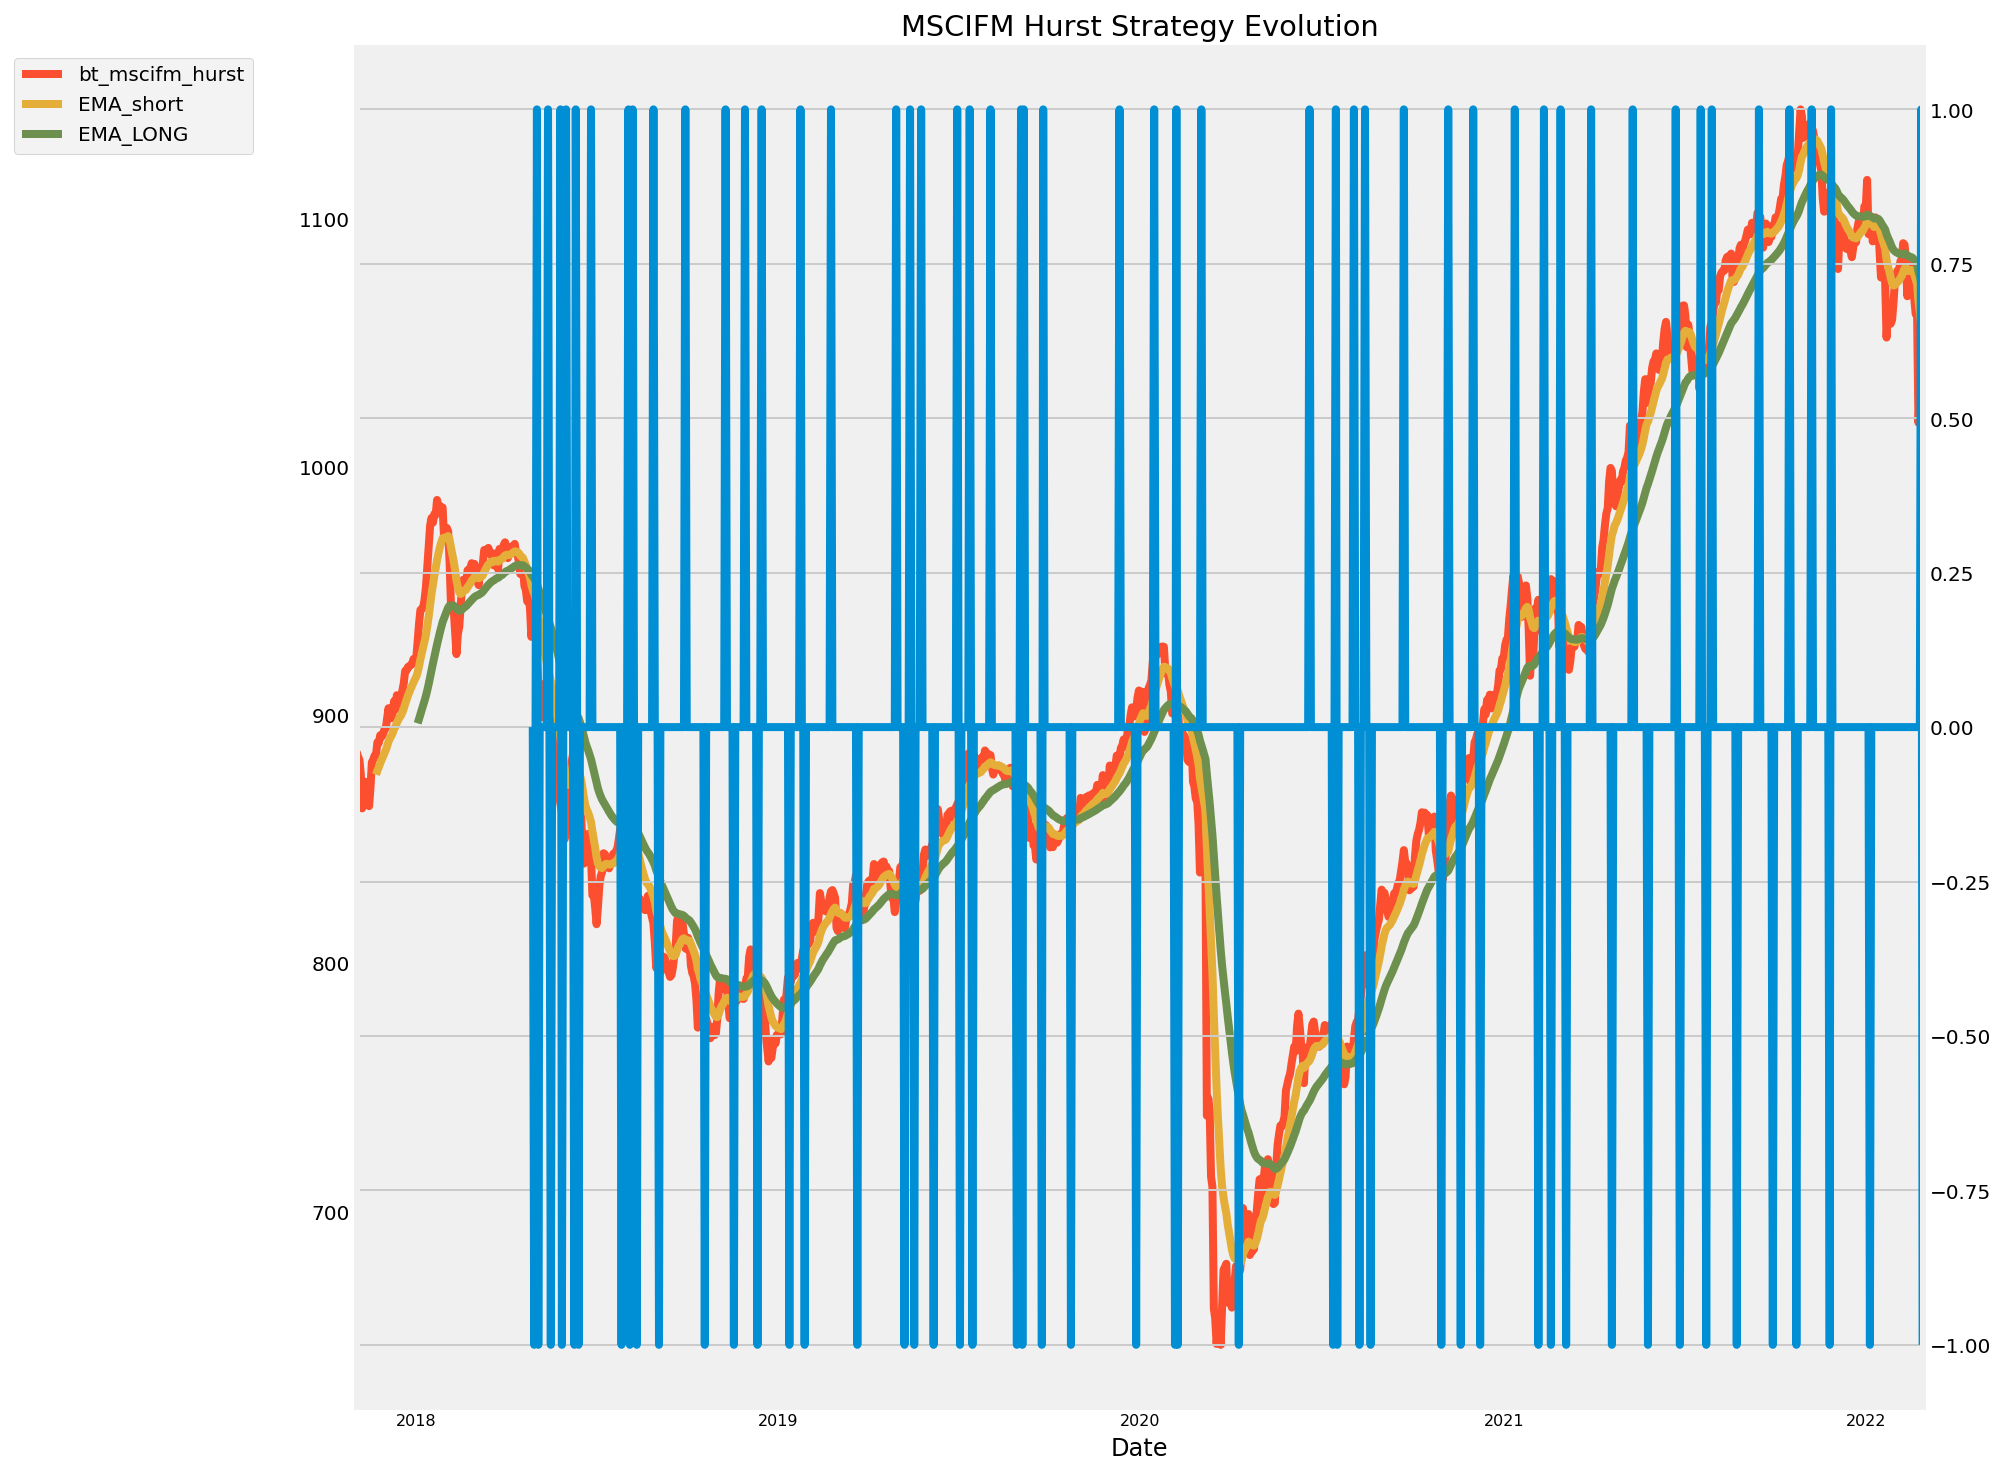

In [43]:

plot_data_mscifm_hurst.plot(secondary_y = ax_name_mscifm_hurst, title = 'MSCIFM Hurst Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
# Use the following if the graph is no clear
plt.rcParams["figure.figsize"] = (12.5,12.5)


#### Here we will display the Return profile of our Rolling Hurst strategy

In [44]:
# S&P 500 Moving Hurst results
res_spx_hurst.display()

Stat                 EMA_crossover with Hurst model for bt_spx_hurst
-------------------  -------------------------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         10.82%
Daily Sharpe         0.37
Daily Sortino        0.75
CAGR                 2.40%
Max Drawdown         -8.85%
Calmar Ratio         0.27

MTD                  0.00%
3m                   -4.87%
6m                   1.39%
YTD                  -1.68%
1Y                   -1.49%
3Y (ann.)            3.84%
5Y (ann.)            2.40%
10Y (ann.)           -
Since Incep. (ann.)  2.40%

Daily Sharpe         0.37
Daily Sortino        0.75
Daily Mean (ann.)    2.63%
Daily Vol (ann.)     7.17%
Daily Skew           10.14
Daily Kurt           213.35
Best Day             9.53%
Worst Day            -3.36%

Monthly Sharpe       0.39
Monthly Sortino      0.85
Monthly Mean (ann.)  2.53%
Monthly Vol (ann.)   6.44%
Monthly Skew         1.12
Monthly Kurt  

In [45]:
# BITCOIN Moving Hurst results
res_btc_hurst.display()

Stat                 EMA_crossover with Hurst model for bt_btc_hurst
-------------------  -------------------------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         128.03%
Daily Sharpe         0.90
Daily Sortino        1.49
CAGR                 20.96%
Max Drawdown         -22.82%
Calmar Ratio         0.92

MTD                  0.00%
3m                   2.32%
6m                   13.58%
YTD                  -0.13%
1Y                   27.12%
3Y (ann.)            20.91%
5Y (ann.)            20.96%
10Y (ann.)           -
Since Incep. (ann.)  20.96%

Daily Sharpe         0.90
Daily Sortino        1.49
Daily Mean (ann.)    22.06%
Daily Vol (ann.)     24.50%
Daily Skew           1.11
Daily Kurt           45.09
Best Day             15.45%
Worst Day            -17.26%

Monthly Sharpe       0.85
Monthly Sortino      1.76
Monthly Mean (ann.)  21.97%
Monthly Vol (ann.)   25.71%
Monthly Skew         0.34
Mont

In [46]:
# HANG SENG MOVING HURST RESULTS
res_hsi_hurst.display()

Stat                 EMA_crossover with Hurst model for bt_hsi_hurst
-------------------  -------------------------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         -3.50%
Daily Sharpe         -0.12
Daily Sortino        -0.17
CAGR                 -0.82%
Max Drawdown         -9.26%
Calmar Ratio         -0.09

MTD                  0.00%
3m                   -6.35%
6m                   -5.73%
YTD                  -3.55%
1Y                   -5.48%
3Y (ann.)            -2.29%
5Y (ann.)            -0.82%
10Y (ann.)           -
Since Incep. (ann.)  -0.82%

Daily Sharpe         -0.12
Daily Sortino        -0.17
Daily Mean (ann.)    -0.68%
Daily Vol (ann.)     5.61%
Daily Skew           -0.10
Daily Kurt           37.69
Best Day             3.61%
Worst Day            -2.77%

Monthly Sharpe       -0.12
Monthly Sortino      -0.19
Monthly Mean (ann.)  -0.66%
Monthly Vol (ann.)   5.51%
Monthly Skew         0.18
M

In [47]:
# MSCI FM MOVING HURST RESULTS
res_mscifm_hurst.display()

Stat                 EMA_crossover with Hurst model for bt_mscifm_hurst
-------------------  ----------------------------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         8.05%
Daily Sharpe         0.60
Daily Sortino        1.04
CAGR                 1.80%
Max Drawdown         -2.93%
Calmar Ratio         0.62

MTD                  -0.66%
3m                   -0.92%
6m                   -2.35%
YTD                  -0.92%
1Y                   0.15%
3Y (ann.)            2.47%
5Y (ann.)            1.80%
10Y (ann.)           -
Since Incep. (ann.)  1.80%

Daily Sharpe         0.60
Daily Sortino        1.04
Daily Mean (ann.)    1.77%
Daily Vol (ann.)     2.97%
Daily Skew           2.52
Daily Kurt           44.90
Best Day             1.94%
Worst Day            -1.85%

Monthly Sharpe       0.68
Monthly Sortino      1.71
Monthly Mean (ann.)  1.79%
Monthly Vol (ann.)   2.62%
Monthly Skew         1.35
Monthly Ku

## Here we will implement Machine Learning Strategy

**Histogram Gradient Boosting Classifier Model**


We began by developing several features based on the closing pricing. We computed the statistics listed below.

• EMA10gtEMA30: The difference between the 10-day exponentially weighted moving average and the 30-day exponentially weighted moving average. A positive integer is assigned the value 1 and a negative number is assigned the value -1.

• ClGtEMA10: The difference between the close and the 10-day exponentially weighted moving average. A positive integer is assigned the value 1 and a negative number is assigned the value -1.

• MACD: Moving average convergence divergence (MACD) is a trend-following momentum indicator that depicts the connection between two moving averages of the price of a security. The MACD is derived by subtracting the exponential moving average (EMA) of 26 periods from the EMA of 12 periods. The MACD line is the outcome of the computation. The "signal line," a nine-day EMA of the MACD displayed on top of the MACD line, can therefore operate as a trigger for buy and sell signals.

• RSI: The relative strength index (RSI) is a momentum indicator used in technical analysis that examines the magnitude of recent price fluctuations to determine if a stock or other asset is overbought or oversold. The RSI is shown as an oscillator (a line graph that fluctuates between two extremes) and has a range of 0 to 100.

• Stochastic Oscillator: A stochastic oscillator is a momentum indicator that compares a security's closing price to a range of its prices over a given time-period. The oscillator's sensitivity to market changes can be reduced by altering the time-period or by taking a moving average of the result. It is used to create overbought and oversold trading signals with a 0–100 value range.

• William's Percentage Range: The indicator tells a trader where the current price is in relation to the maximum high in the previous 14 periods (or whatever number of lookback periods is chosen). When the indicator is between -20 and zero, the price is overbought or close to the peak of its most recent price range.

We use an increase in daily return as a positive indicator(target) for our machine learning model, assigning a value of 1 for each gain and -1 for each decrease.

Using the train test split function, we split the data into training and test sets, ensuring that the data is split chronologically by setting the shuffle argument to False.

After that, we chose a gradient boosting model, which is an ensemble model of the decision tree families. These models are known to be the most effective at predicting stock price direction. The Histogram Gradient Boosting Classifier model is the one we went with.

To find the best parameters for our classification model, we first ran a grid search cross validation. The maximum depth of each tree in the node and the maximum number of iterations for the ensemble model were the factors we investigated.

We fitted our HistGradientBoostingClassifier model with these parameters after our algorithm determined the ideal values. We used the training samples to train the model.

We then used the test features to make our predictions. For a buy signal, the model predicts 1 and for a sell signal, it predicts -1.

Finally, we evaluated our model's performance using the "bt" back testing library.


In [48]:
spx_ohlcv = get_index_price(index = "S&P 500" , country = "united states",\
                                              from_date=str_date, to_date=end_date, order='ascending', interval='daily', type='index', close_only=False)

bitco_ohlcv = get_index_price(crypto= "bitcoin" ,from_date=str_date, to_date=end_date, order='ascending', interval='daily', type='crypto', close_only=False)

bitco_ohlcv = bitco_ohlcv.loc[spx.index]

hsi_ohlcv = get_index_price(index = "Hang Seng" , country = "hong kong",\
                                              from_date=str_date, to_date=end_date, order='ascending', interval='daily', type='index', close_only=False)


mscifm_ohlcv = get_index_price(text="MSCI FM Frontier Markets USD", from_date=str_date, to_date=end_date, close_only=False)


In [49]:
ohlcv_spx = ml_feature_engineering(spx_ohlcv)
ohlcv_btc = ml_feature_engineering(bitco_ohlcv)
ohlcv_mscifm = ml_feature_engineering(mscifm_ohlcv)
ohlcv_hsi = ml_feature_engineering(hsi_ohlcv)

In [50]:
res_spx_ml, plot_data_spx_ml, ax_name_spx_ml = signal_strategy(spx_ohlcv.Close,ohlcv_spx,15,45,series_name="bt_spx_ml", model_type='ML')
res_btc_ml, plot_data_btc_ml, ax_name_btc_ml = signal_strategy(bitco_ohlcv.Close,ohlcv_btc,15,45,series_name="bt_btc_ml", model_type='ML')
res_hsi_ml, plot_data_hsi_ml, ax_name_hsi_ml = signal_strategy(hsi_ohlcv.Close,ohlcv_hsi,15,45, series_name="bt_hsi_ml", model_type='ML')
res_mscifm_ml, plot_data_mscifm_ml, ax_name_mscifm_ml = signal_strategy(mscifm_ohlcv.Close,ohlcv_mscifm,15,45,series_name="bt_mscifm_ml", model_type='ML')

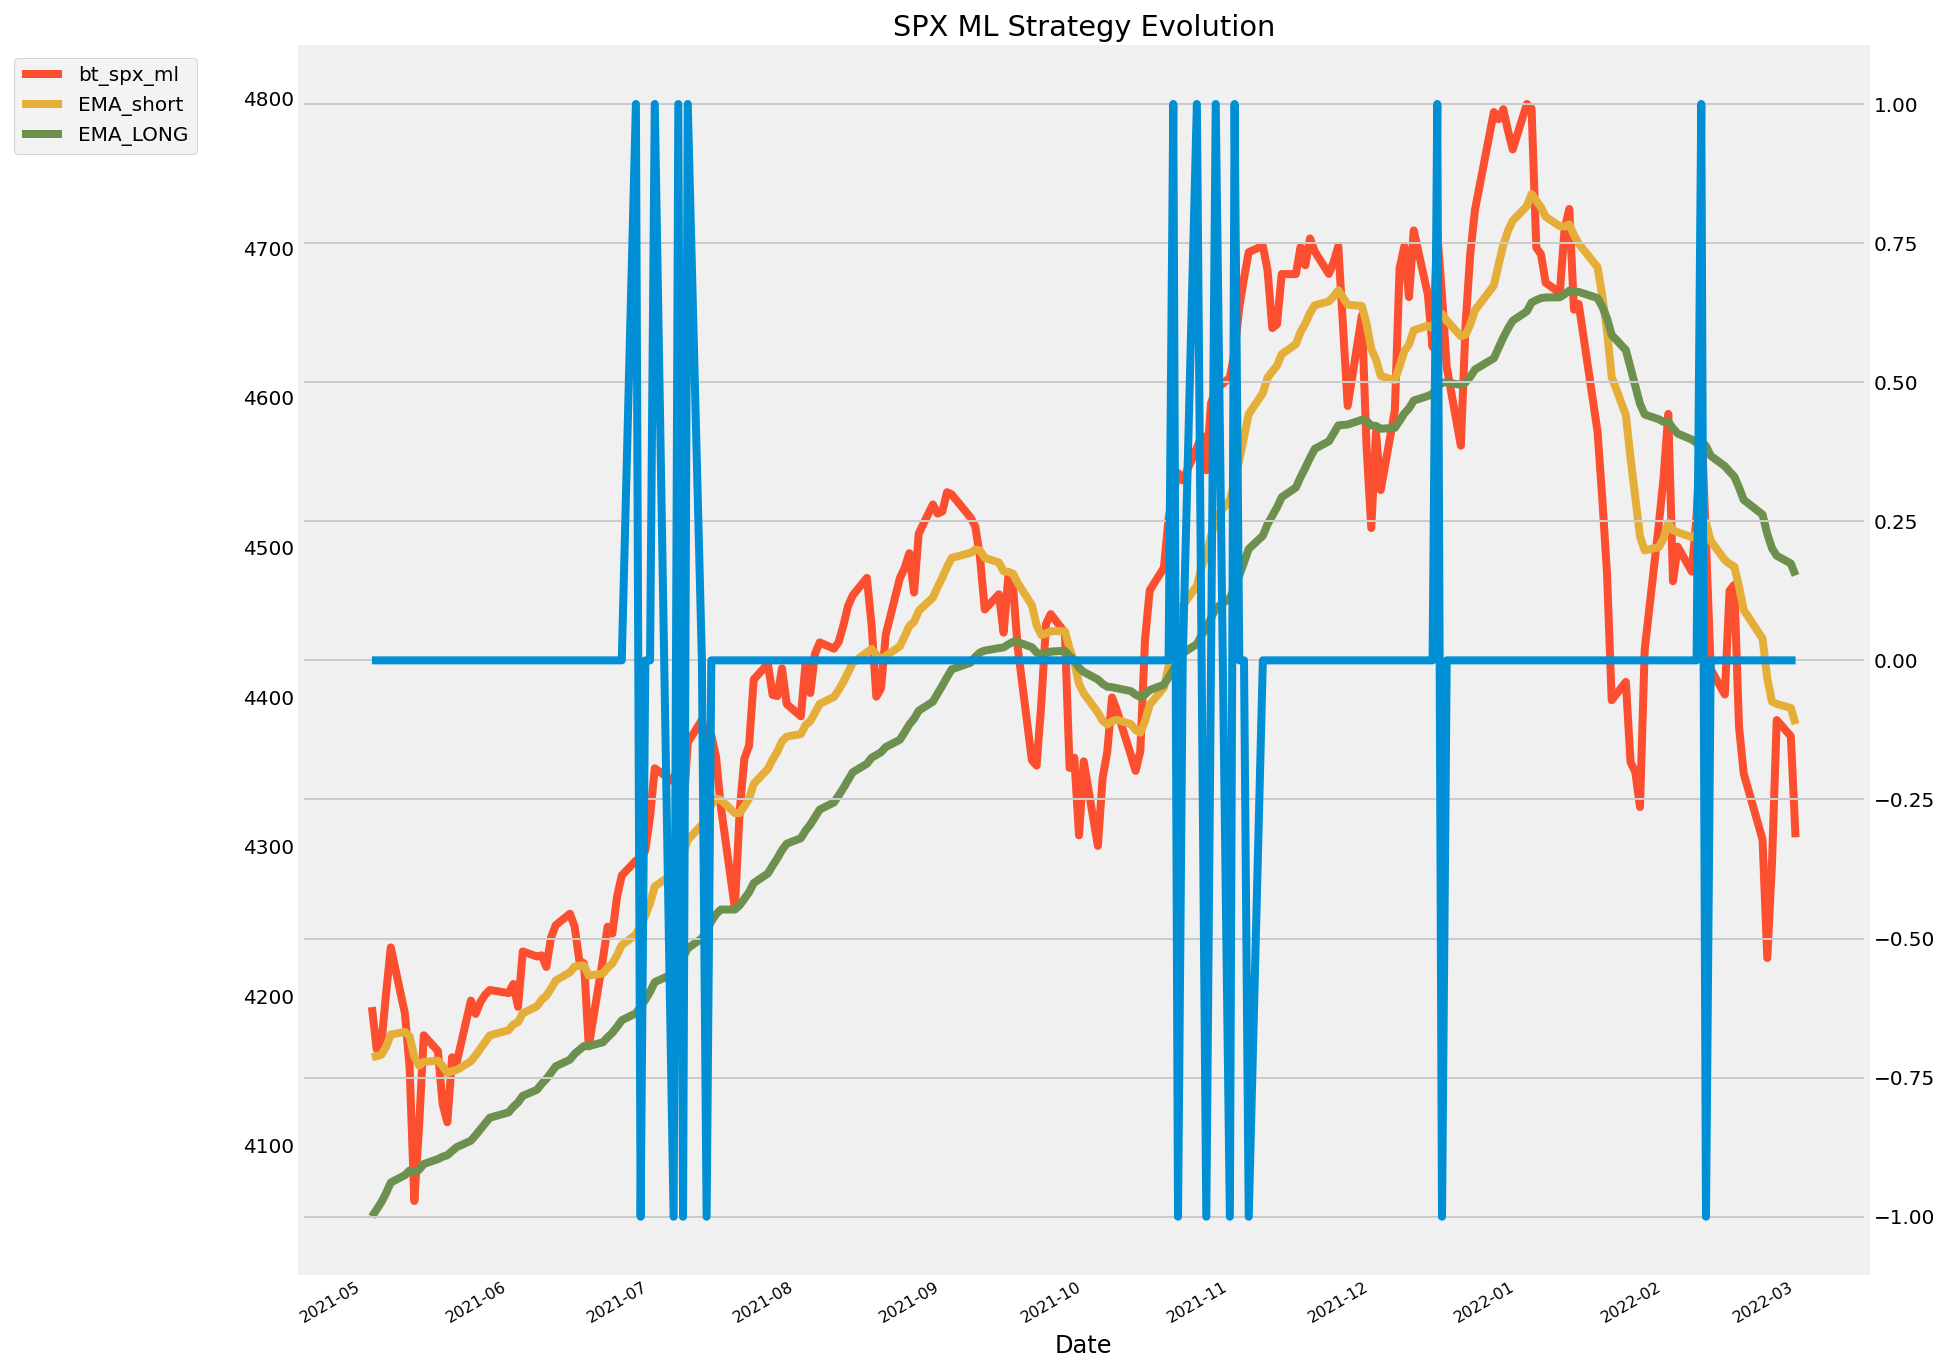

In [51]:

plot_data_spx_ml['2021-05':].plot(secondary_y = ax_name_spx_ml, title = 'SPX ML Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
# Use the following if the graph is no clear
plt.rcParams["figure.figsize"] = (12.5,12.5)
plt.savefig('./figures/23. SPX ML Strategy Evolution.png')

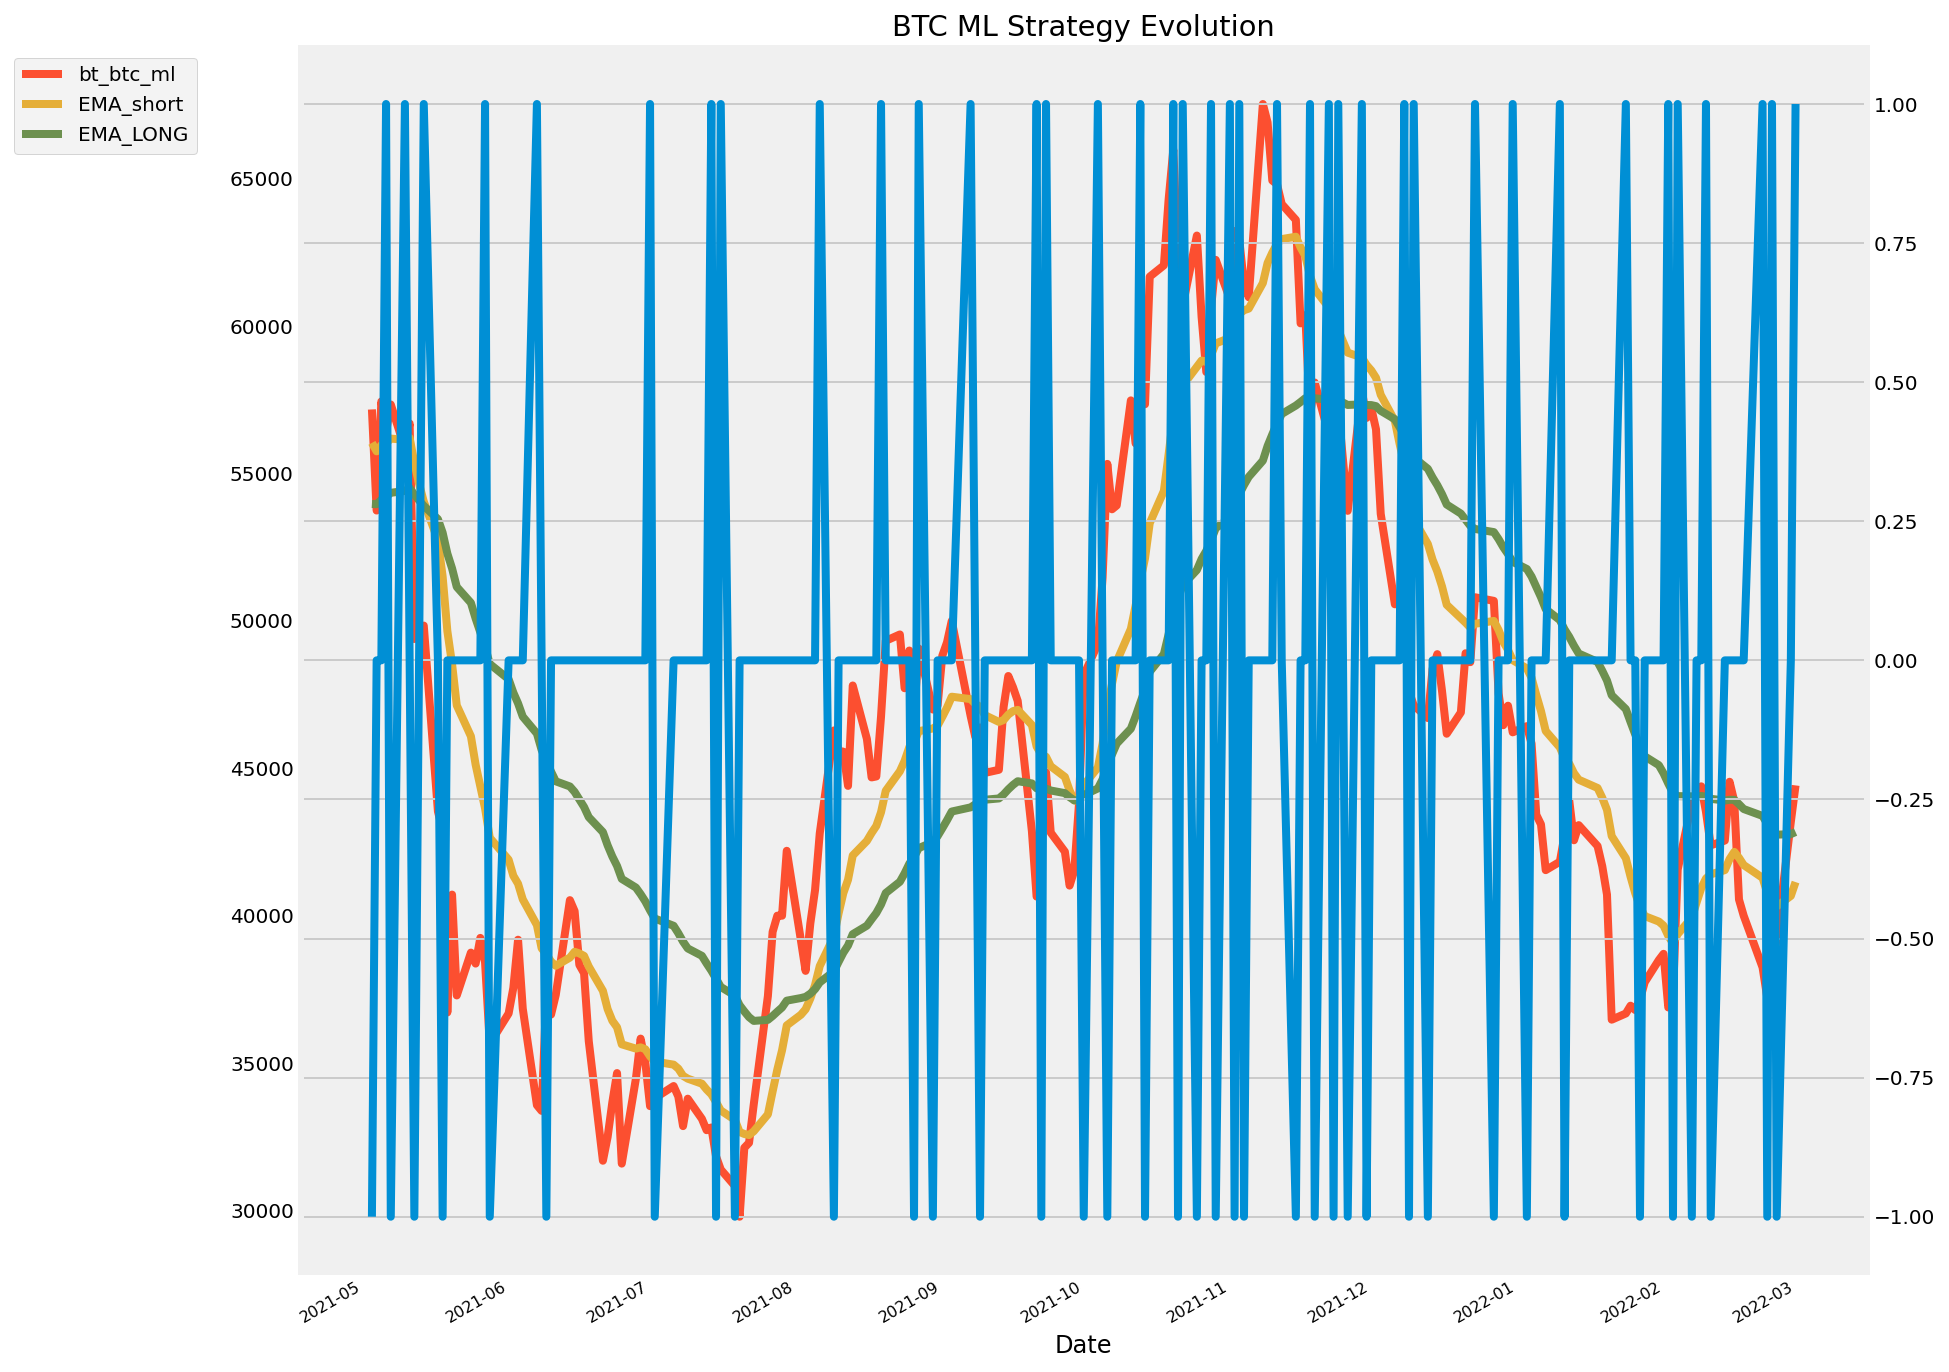

In [52]:

plot_data_btc_ml['2021-05':].plot(secondary_y = ax_name_btc_ml, title = 'BTC ML Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
# Use the following if the graph is no clear
plt.rcParams["figure.figsize"] = (12.5,12.5)
plt.savefig('./figures/24. Bitcoin ML Strategy Evolution.png')

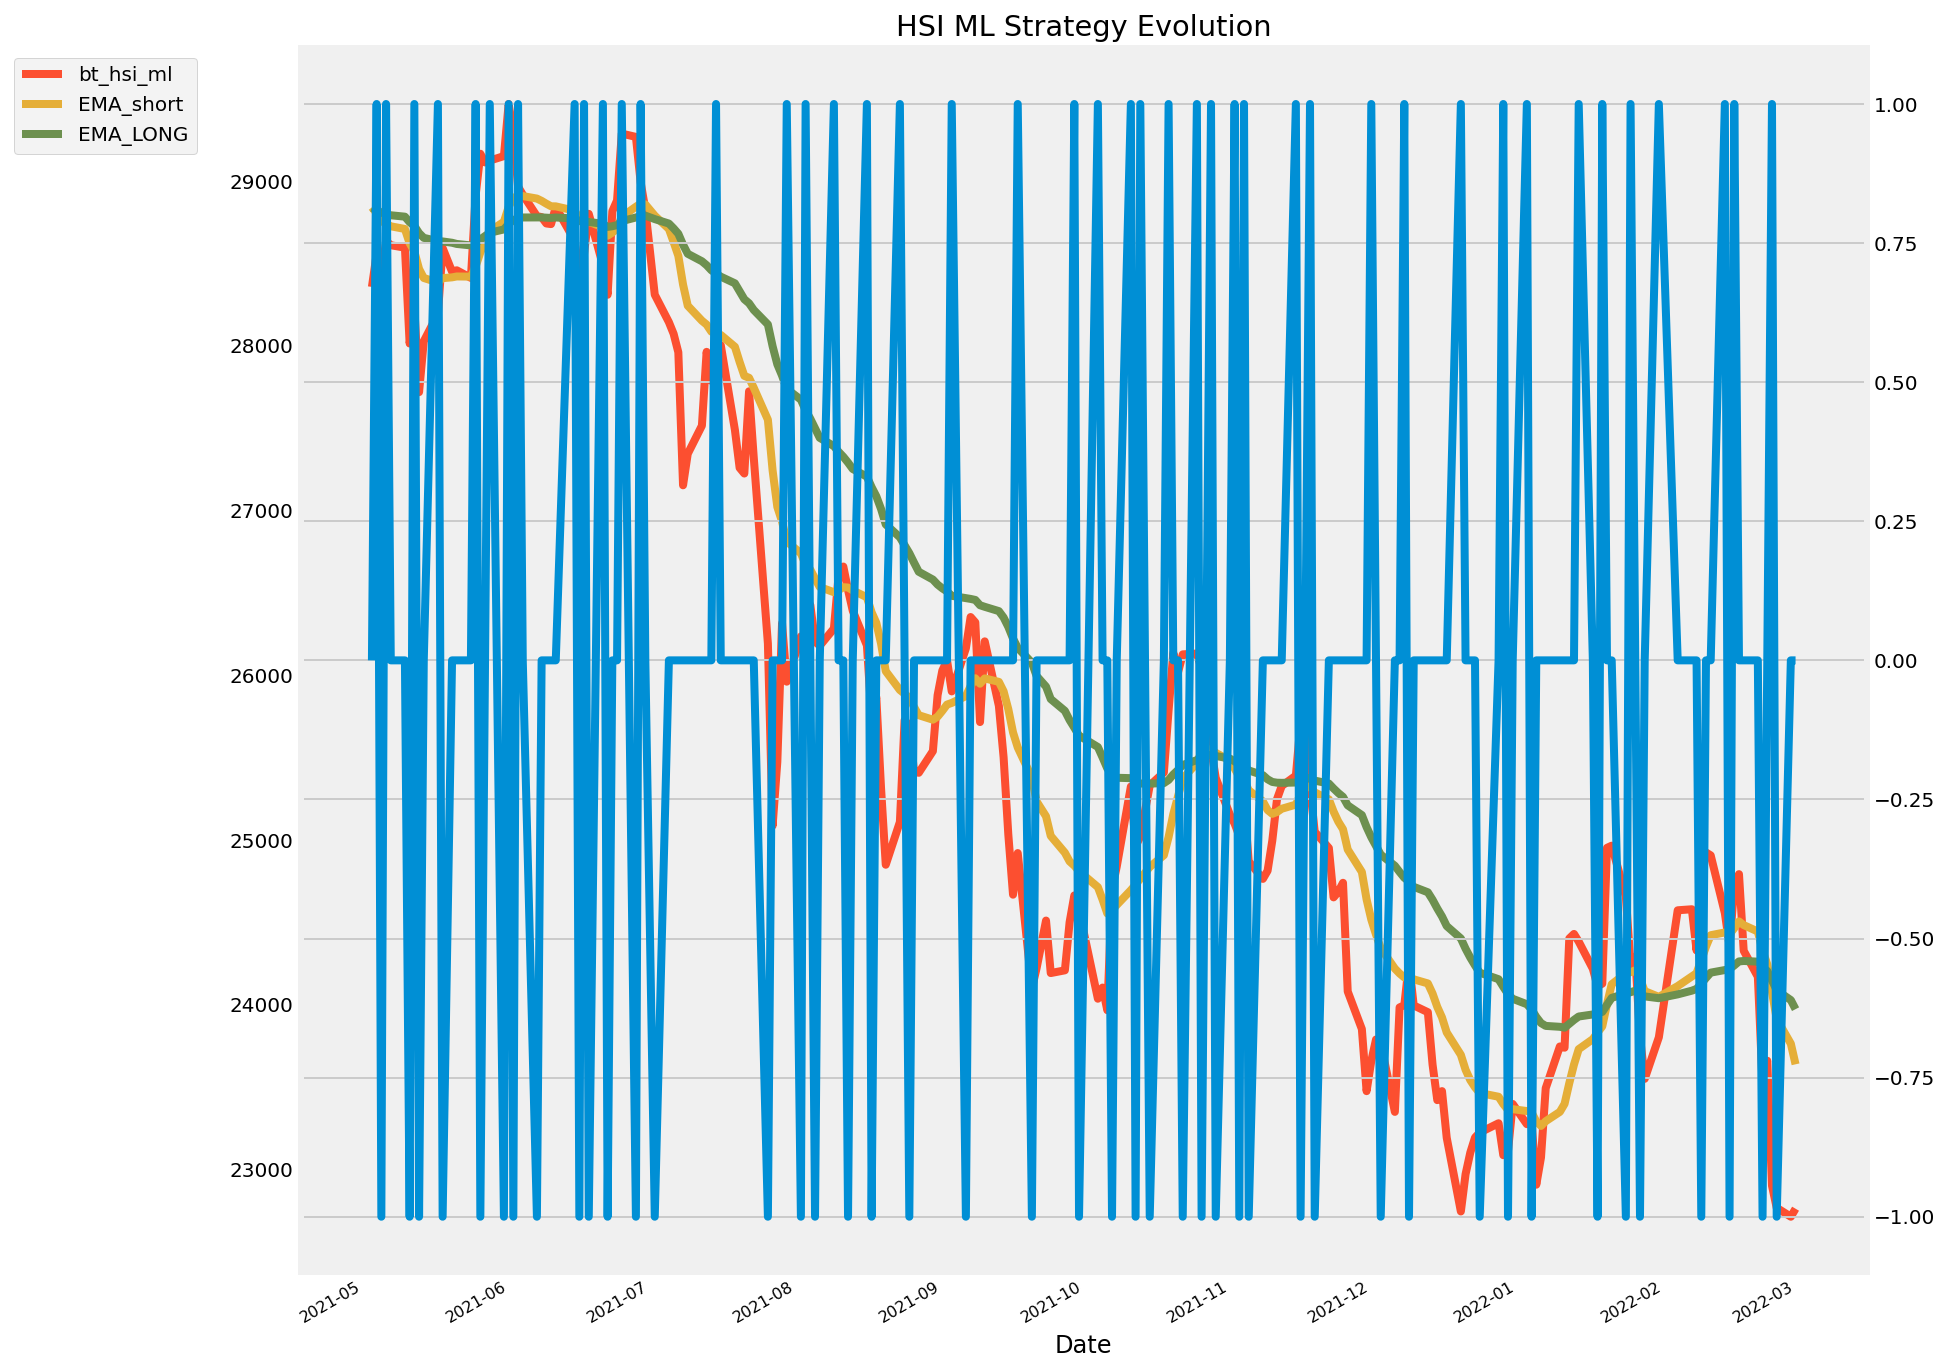

In [53]:

plot_data_hsi_ml['2021-05':].plot(secondary_y = ax_name_hsi_ml, title = 'HSI ML Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
# Use the following if the graph is no clear
plt.rcParams["figure.figsize"] = (12.5,12.5)
plt.savefig('./figures/25. HSI ML Strategy Evolution.png')

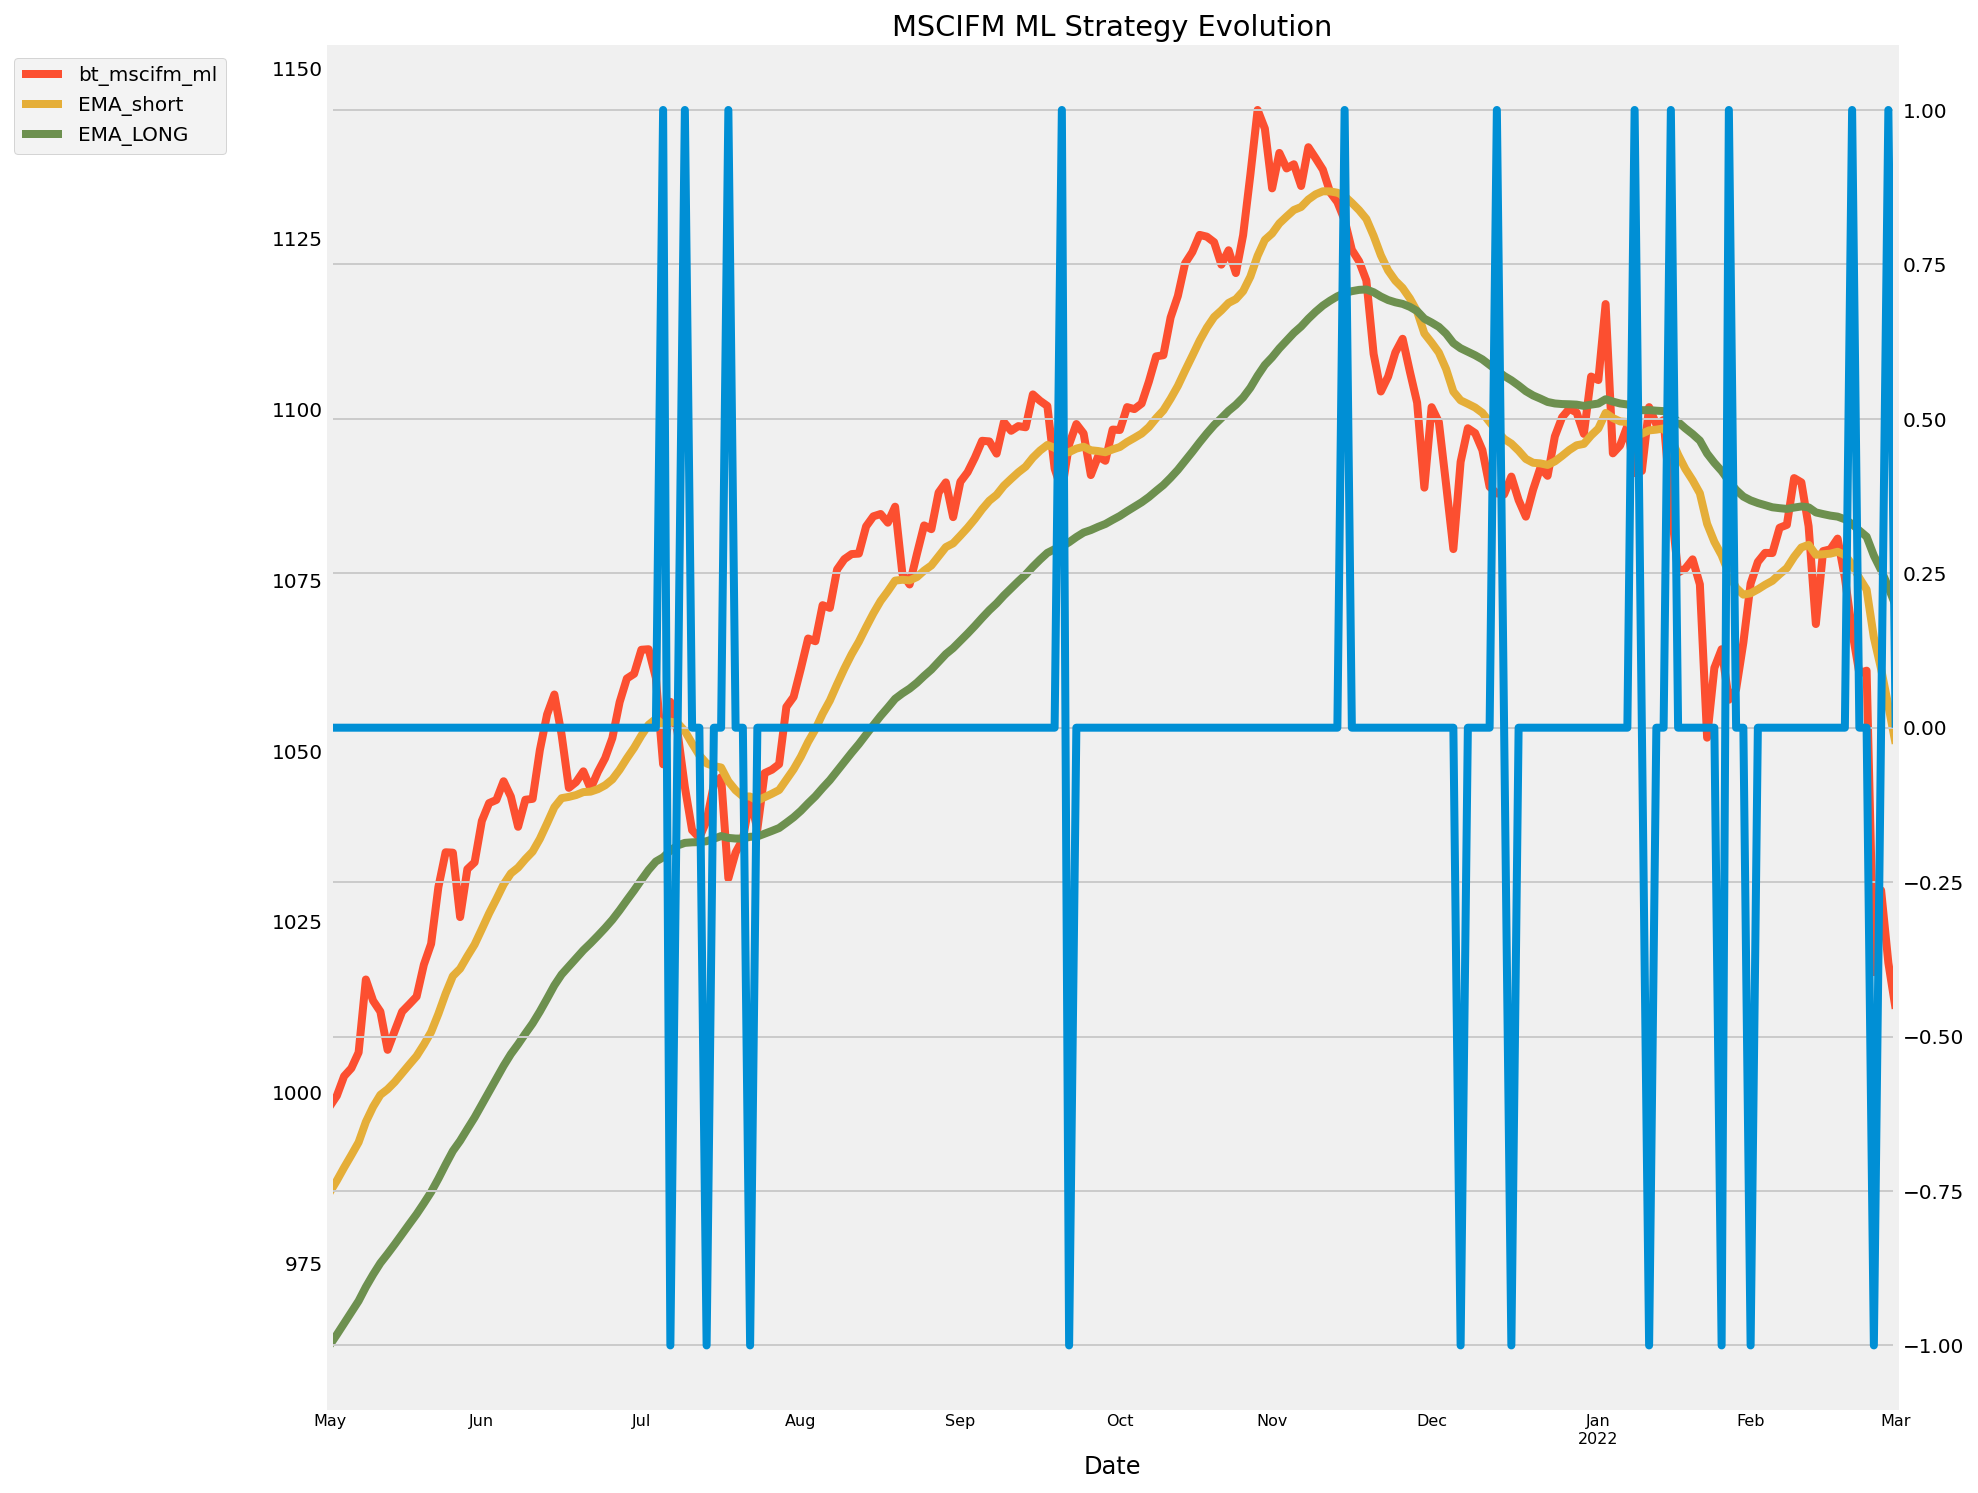

In [54]:

plot_data_mscifm_ml['2021-05':].plot(secondary_y = ax_name_mscifm_ml, title = 'MSCIFM ML Strategy Evolution').legend(bbox_to_anchor =(-0.06, 1.0))
# Use the following if the graph is no clear
plt.rcParams["figure.figsize"] = (12.5,12.5)
plt.savefig('./figures/26. MSCIFM ML Strategy Evolution.png')

#### Results from our ML STRATEGY

In [55]:
res_spx_ml.display()

Stat                 EMA_crossover with ML model for bt_spx_ml
-------------------  -------------------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         -2.92%
Daily Sharpe         -0.38
Daily Sortino        -0.50
CAGR                 -0.68%
Max Drawdown         -4.73%
Calmar Ratio         -0.14

MTD                  0.00%
3m                   0.21%
6m                   0.17%
YTD                  0.06%
1Y                   -2.92%
3Y (ann.)            -0.98%
5Y (ann.)            -0.68%
10Y (ann.)           -
Since Incep. (ann.)  -0.68%

Daily Sharpe         -0.38
Daily Sortino        -0.50
Daily Mean (ann.)    -0.67%
Daily Vol (ann.)     1.75%
Daily Skew           -1.14
Daily Kurt           178.61
Best Day             1.90%
Worst Day            -1.81%

Monthly Sharpe       -0.57
Monthly Sortino      -0.58
Monthly Mean (ann.)  -0.66%
Monthly Vol (ann.)   1.17%
Monthly Skew         -5.91
Monthly Kurt  

In [56]:
res_btc_ml.display()

Stat                 EMA_crossover with ML model for bt_btc_ml
-------------------  -------------------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         -7.70%
Daily Sharpe         -0.00
Daily Sortino        -0.00
CAGR                 -1.83%
Max Drawdown         -35.40%
Calmar Ratio         -0.05

MTD                  0.00%
3m                   -23.99%
6m                   -19.46%
YTD                  -21.19%
1Y                   -7.70%
3Y (ann.)            -2.63%
5Y (ann.)            -1.83%
10Y (ann.)           -
Since Incep. (ann.)  -1.83%

Daily Sharpe         -0.00
Daily Sortino        -0.00
Daily Mean (ann.)    -0.06%
Daily Vol (ann.)     18.89%
Daily Skew           -0.47
Daily Kurt           57.63
Best Day             14.78%
Worst Day            -12.18%

Monthly Sharpe       -0.09
Monthly Sortino      -0.10
Monthly Mean (ann.)  -1.07%
Monthly Vol (ann.)   11.65%
Monthly Skew         -4.67
Mont

In [57]:
res_hsi_ml.display()

Stat                 EMA_crossover with ML model for bt_hsi_ml
-------------------  -------------------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         15.57%
Daily Sharpe         0.65
Daily Sortino        1.15
CAGR                 3.40%
Max Drawdown         -6.16%
Calmar Ratio         0.55

MTD                  0.00%
3m                   11.74%
6m                   10.26%
YTD                  7.34%
1Y                   15.57%
3Y (ann.)            4.94%
5Y (ann.)            3.40%
10Y (ann.)           -
Since Incep. (ann.)  3.40%

Daily Sharpe         0.65
Daily Sortino        1.15
Daily Mean (ann.)    3.56%
Daily Vol (ann.)     5.50%
Daily Skew           3.21
Daily Kurt           53.54
Best Day             4.29%
Worst Day            -3.28%

Monthly Sharpe       0.57
Monthly Sortino      1.36
Monthly Mean (ann.)  3.46%
Monthly Vol (ann.)   6.11%
Monthly Skew         2.05
Monthly Kurt         7.29
Be

In [58]:
res_mscifm_ml.display()

Stat                 EMA_crossover with ML model for bt_mscifm_ml
-------------------  ----------------------------------------------
Start                2017-10-31
End                  2022-03-01
Risk-free rate       0.00%

Total Return         -1.46%
Daily Sharpe         -0.26
Daily Sortino        -0.33
CAGR                 -0.34%
Max Drawdown         -3.31%
Calmar Ratio         -0.10

MTD                  -0.66%
3m                   -2.67%
6m                   -2.72%
YTD                  -2.53%
1Y                   -1.46%
3Y (ann.)            -0.49%
5Y (ann.)            -0.34%
10Y (ann.)           -
Since Incep. (ann.)  -0.34%

Daily Sharpe         -0.26
Daily Sortino        -0.33
Daily Mean (ann.)    -0.32%
Daily Vol (ann.)     1.21%
Daily Skew           -3.81
Daily Kurt           110.57
Best Day             0.87%
Worst Day            -1.18%

Monthly Sharpe       -0.28
Monthly Sortino      -0.32
Monthly Mean (ann.)  -0.33%
Monthly Vol (ann.)   1.18%
Monthly Skew         -3.80
Mont